# Discovering the Kraichnan-Orszag system from data

### Main Article-
- https://readmedium.com/discovering-differential-equations-with-physics-informed-neural-networks-and-symbolic-regression-c28d279c0b4d

### Some more articles to read-
- https://readmedium.com/operator-learning-via-physics-informed-deeponet-lets-implement-it-from-scratch-6659f3179887
- https://i-systems.github.io/tutorial/KSME/CAE/220520/01_PINN.html
- https://docs.sciml.ai/NeuralPDE/stable/manual/ode/

### Objective

In this notebook, we investigate combining PINN with symbolic regression to discover ODE systems. Our target ODE system can be written as follows:

Let u_1 = psi_e, u_2 = b_e, u_3 = psi_plus, u_4 = b_plus. u_5 = U

\begin{align}
    \frac{d \psi_e}{dt} &= -\psi_e + (k / k_e^2)b_e + U  (-(k  (k_+^2 - m_U^2)) / (2  k_e^2))  \psi_+ + \sqrt(\epsilon) \times noise \\
    \frac{d b_e}{dt} &= -kN_0^2  \psi_e - b_e + (k / 2)  U  \psi_+ \\
    \frac{d \psi_+}{dt} &= -\psi_+ - (k / k_+^2)  b_+ + U  (-(k  (m_U^2 - k_e^2)) / (2  k_+^2))  \psi_e \\
    \frac{d b_+}{dt} &= k  N_0^2  \psi_+ - b_+ - (k / 2)  U  \psi_e \\
    \frac{d U}{dt} &= 0.25  k  (k_p^2 - k_e^2)  \psi_e  \psi_p - (r_m  U) \\
\end{align}

Substituting,in python,

\begin{align}
    \frac{d u_1}{dt} &= -u_1 + (k / k_e**2) * u_2 + u_5 * (-(k * (k_plus**2 - m_U**2)) / (2 * k_e**2)) * u_3 + np.sqrt(epsilon) * noise \\
    \frac{d u_2}{dt} &= -k * N0_squared * u_1 - u_2 + (k / 2) * u_5 * u_3 \\
    \frac{d u_3}{dt} &= -u_3 - (k / k_plus**2) * u_4 + u_5 * (-(k * (m_U**2 - k_e**2)) / (2 * k_plus**2)) * u_1 \\
    \frac{d u_4}{dt} &= k * N0_squared * u_3 - u_4 - (k / 2) * u_5 * u_1 \\
    \frac{d u_5}{dt} &= 0.25 * k * (k_plus**2 - k_e**2) * u_1 * u_3 - r_m * u_5 \\
\end{align}


with an initial condition of $u_1(0)=0, u_2(0)=0, u_3(0)=0, u_4(0)=0, u_5(0)=0.001$.

For our case study, we assume that we only know the right-hand side of the third equation to be a linear transformation of $u_1u_2$, and have no knowledge of the first two equations. Essentially, we can rewrite the ODE system as follows:

\begin{align}
    \frac{du_1}{dt} &= f_1(t, u_1, u_2, u_3, u_5) \\
    \frac{du_2}{dt} &= f_2(t, u_1, u_2, u_3) \\
    \frac{du_3}{dt} &= f_3(t, u_1, u_3, u_4, u_5) \\
    \frac{du_4}{dt} &= f_4(t, u_1, u_3, u_4, u_5) \\
    \frac{du_5}{dt} &= a u_1u_3 - r_m u_5 + b \\
\end{align}

where $a, b$ are unknown coefficients and $f_1, f_2, f_3, f_4$ are the unknown functions. By using PINN and symbolic regression, we aim to calibrate the values of $a$ and $b$, as well as the functional forms of $f_1, f_2, f_3, and f_4$.

### 0. Import libraries

In [1]:
# Common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy.integrate import solve_ivp
from collections import defaultdict
import sdeint
import time

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

2023-12-29 02:29:45.444666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 1. Observational data generation

To begin with, we need to generate simulation data of the investigated ODE system, which will be used later for inverse calibration.

In [2]:
# Define all the constants
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi

r_m = 0.1
N0_squared = 100


k_e = np.sqrt(k**2 + m**2)
k_plus = np.sqrt(k**2 +(m+m_U)**2)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
             [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
             [L_plus, np.zeros((2, 2))]])

epsilon = 0.01

noise = np.random.normal(0, 1)

In [14]:
# def simulate_ODEs(u_init, t_span, obs_num):
#     """Simulate the ODE system and obtain observational data. 
    
#     Args:
#     ----
#     u_init: list of initial condition for u1, u2, and u3
#     t_span: lower and upper time limit for simulation
#     obs_num: number of observational data points
    
#     Outputs:
#     --------
#     u_obs: observed data for u's
#     """
    
#     # Define the target ODEs
#     def odes(t, u):
#         du1dt = -u[0] + (k / k_e**2) * u[1] + u[4] * (-(k * (k_plus**2 - m_U**2)) / (2 * k_e**2)) * u[2] + np.sqrt(epsilon) * noise
#         du2dt = -k * N0_squared * u[0] - u[1] + (k / 2) * u[4] * u[2]
#         du3dt = -u[2] - (k / k_plus**2) * u[3] + u[4] * (-(k * (m_U**2 - k_e**2)) / (2 * k_plus**2)) * u[0]
#         du4dt = k * N0_squared * u[2] - u[3] - (k / 2) * u[4] * u[0]
#         du5dt = 0.25 * k * (k_plus**2 - k_e**2) * u[0] * u[2] - r_m * u[4]
#         return [du1dt, du2dt, du3dt, du4dt, du5dt]
    
#     # Solve ODEs
#     t_eval = np.linspace(t_span[0], t_span[1], obs_num)
#     sol = solve_ivp(odes, t_span, u_init, method='RK45', t_eval=t_eval)
    
#     # Restrcture obtained data
#     u_obs = np.column_stack((sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4]))
    
#     return u_obs


In [52]:
# import sdeint

# def f(u, t):
#     du1dt = -u[0] + (k / k_e**2) * u[1] + u[4] * (-(k * (k_plus**2 - m_U**2)) / (2 * k_e**2)) * u[2]
#     du2dt = -k * N0_squared * u[0] - u[1] + (k / 2) * u[4] * u[2]
#     du3dt = -u[2] - (k / k_plus**2) * u[3] + u[4] * (-(k * (m_U**2 - k_e**2)) / (2 * k_plus**2)) * u[0]
#     du4dt = k * N0_squared * u[2] - u[3] - (k / 2) * u[4] * u[0]
#     du5dt = 0.25 * k * (k_plus**2 - k_e**2) * u[0] * u[2] - r_m * u[4]
#     return np.array([du1dt, du2dt, du3dt, du4dt, du5dt])

# def g(u, t):
#     return np.array([[np.sqrt(epsilon)], [0], [0], [0], [0]])


# y0 = [0, 0, 0, 0, 0.001]
# obs_num = 1000000
# tspan = np.linspace(0, 200, obs_num) 
# rng = np.random.default_rng()

# u_obs = sdeint.itoEuler(f, g, y0, tspan, generator=rng)

In [15]:
# # Set up simulation
# u_init = [0, 0, 0, 0, 0.001]
# t_span = [0, 200]
# obs_num = 10000

# # Solve ODEs
# u_obs = simulate_ODEs(u_init, t_span, obs_num)

In [81]:
initial_state = np.array([[0, 0, 0, 0, 0.001]]).T  #The initial state for the y_em output where the concatenated array looks like [psi_e, b_e, psi_plus, b_plus, U]
t_span = (0, 200)
dt = 0.001
epsilon = 0.01  #noise strength (0.01 has been well used)


#The function below uses the Euler Maruyama method which is used to solve Stochastic Differential Equations (SDEs)
def euler_maruyama(y0, t_span, dt, epsilon, seed=None):
    np.random.seed(seed)
    t0, tf = t_span
    t = np.linspace(t0, tf, int((tf - t0) / dt))
    s = np.zeros((4, len(t)))
    U = np.zeros(len(t))

    s[:, 0] = y0[:4].ravel()
    U[0] = y0[4]

    for i in range(len(t) - 1):
        noise_forcing = np.sqrt(dt) * (2 * np.sqrt(2) / k_e) * np.random.normal(0, 1)
        noise_forcing_vector = np.array([noise_forcing, 0, 0, 0])
        psi_e = s[0, i]
        psi_p = s[2, i]
        s[:, i + 1] = s[:, i] + dt * (W @ s[:, i] + U[i] * (L @ s[:, i])) + np.sqrt(epsilon) * noise_forcing_vector
        U[i + 1] = U[i] + dt * ((0.25 * k * (k_plus**2 - k_e**2) * psi_e * psi_p) - (r_m * U[i]))

    y = np.column_stack((t, s.T, U))
    return y

u_obs = euler_maruyama(initial_state, t_span, dt, epsilon)

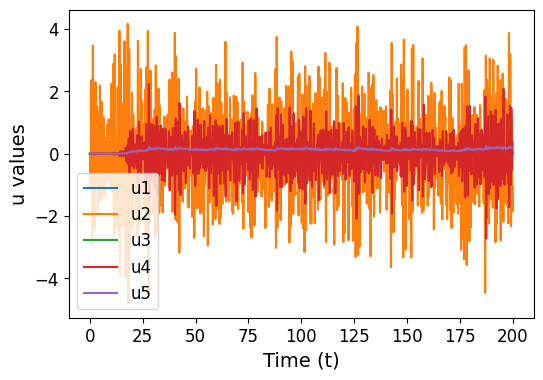

In [82]:
# Visualize the results
plt.figure(figsize=(6, 4))

plt.plot(u_obs[:, 0], u_obs[:, 1], label='u1')
plt.plot(u_obs[:, 0], u_obs[:, 2], label='u2')
plt.plot(u_obs[:, 0], u_obs[:, 3], label='u3')
plt.plot(u_obs[:, 0], u_obs[:, 4], label='u4')
plt.plot(u_obs[:, 0], u_obs[:, 5], label='u5')

plt.xlabel('Time (t)', fontsize=14)
plt.ylabel('u values', fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12, frameon=True)

plt.savefig('u_profile.png', bbox_inches='tight', transparent=True)

### 2. Organize dataset

In [83]:
# Set batch size
data_batch_size = 20000
ODE_batch_size = 200000

# Samples for enforcing data loss
X_train_data = tf.convert_to_tensor(u_obs[:, :1], dtype=tf.float32)
y_train_data = tf.convert_to_tensor(u_obs[:, 1:], dtype=tf.float32)
train_ds_data = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data))
train_ds_data = train_ds_data.shuffle(200000).batch(data_batch_size)

# Samples for enforcing ODE residual loss
N_collocation = 2000000
X_train_ODE = tf.convert_to_tensor(np.linspace(0, 200, N_collocation).reshape(-1, 1), dtype=tf.float32)
train_ds_ODE = tf.data.Dataset.from_tensor_slices((X_train_ODE))
train_ds_ODE = train_ds_ODE.shuffle(10*N_collocation).batch(ODE_batch_size)

# Generate testing data
u_obs_test = euler_maruyama(initial_state, t_span, dt/5, epsilon)
X_test, y_test = u_obs_test[:, :1], u_obs_test[:, 1:]

### 3. Physics-informed Neural Networks

#### Define a custom layer for hosting unknown parameters

In [84]:
class ParameterLayer(tf.keras.layers.Layer):
    def __init__(self, a, b, trainable=True):
        super(ParameterLayer, self).__init__()
        self._a = tf.convert_to_tensor(a, dtype=tf.float32)
        self._b = tf.convert_to_tensor(b, dtype=tf.float32)
        self.trainable = trainable
        
    def build(self, input_shape):
        self.a = self.add_weight("a", shape=(1,), 
                                 initializer=tf.keras.initializers.Constant(value=self._a),
                                 trainable=self.trainable)
        self.b = self.add_weight("b", shape=(1,), 
                                 initializer=tf.keras.initializers.Constant(value=self._b),
                                 trainable=self.trainable)
        
    def get_config(self):
        return super().get_config()
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

#### Define Physics-informed Neural Network

In [85]:
def u_net(input_layer):
    """Definition of the network for u prediction."""
    
    hidden = input_layer
    for _ in range(2):
        hidden = tf.keras.layers.Dense(50, activation="tanh")(hidden)
    output = tf.keras.layers.Dense(5)(hidden)
    return output


def f_net(input_layers, a_init=None, b_init=None):
    """Definition of the network for f prediction."""
    
    hidden = tf.keras.layers.Concatenate()(input_layers)
    for _ in range(2):
        hidden = tf.keras.layers.Dense(50, activation="tanh")(hidden)
    output = tf.keras.layers.Dense(2)(hidden)
    output = ParameterLayer(a_init, b_init)(output)
    return output


def create_PINN(a_init=None, b_init=None, verbose=False):
    """Definition of a physics-informed neural network.
    
    Args:
    ----
    a_init: initial value for parameter a
    b_init: initial value for parameter b
    verbose: boolean, indicate whether to show the model summary
    
    Outputs:
    --------
    model: the PINN model
    """
    # Input
    t_input = tf.keras.Input(shape=(1,), name="time")
    
    # u-NN
    u = u_net(t_input)
    
    # f-NN
    f = f_net([t_input, u], a_init, b_init)

    # PINN model
    model = tf.keras.models.Model(inputs=t_input, outputs=[u, f])
    
    if verbose:
        model.summary()
        
    return model

#### ODE loss

In [112]:
@tf.function
def ODE_residual_calculator(t, model):
    """ODE residual calculation.
    
    Args:
    ----
    t: temporal coordinate
    model: PINN model
    
    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """
    
    # Retrieve parameters
    a = model.layers[-1].a
    b = model.layers[-1].b
    
    with tf.GradientTape() as tape:
        tape.watch(t)
        u, f = model(t)
    
    # Calculate gradients
    dudt = tape.batch_jacobian(u, t)[:, :, 0]
    du1_dt, du2_dt, du3_dt, du4_dt, du5_dt = dudt[:, :1], dudt[:, 1:2], dudt[:, 2:3], dudt[:, 3:4], dudt[:, 4:]
    
    '''
    \begin{align}
    \frac{du_1}{dt} &= f_1(t, u_1, u_2, u_3, u_5) \\
    \frac{du_2}{dt} &= f_2(t, u_1, u_2, u_3) \\
    \frac{du_3}{dt} &= f_3(t, u_1, u_3, u_4, u_5) \\
    \frac{du_4}{dt} &= f_4(t, u_1, u_3, u_4, u_5) \\
    \frac{du_5}{dt} &= a u_1u_3 - r_m u_5 + b \\
    \end{align}
    '''
    # Compute residuals
    res1 = du1_dt - f[:, 0:1]
    res2 = du2_dt - f[:, 1:2]
    res3 = du3_dt - f[:, 2:3]
    res4 = du4_dt - f[:, 3:4]
    res5 = du5_dt - a*((0.25 * k * (k_plus**2 - k_e**2))*u[:, 0:1]*u[:, 2:3] - r_m*u[:, 4:5] + b)
    ODE_residual = tf.concat([res1, res2, res3, res4, res5], axis=1)
    
    return ODE_residual

#### Gradient descent step

In [113]:
@tf.function
def train_step(X_ODE, X, y, IC_weight, ODE_weight, data_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.
    
    Args:
    ----
    X_ODE: Collocation points for evaluating ODE residuals
    X: observed samples
    y: target values of the observed samples
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    data_weight: weight for data loss
    model: PINN model
    
    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    data_loss: calculated data loss
    total_loss: weighted sum of ODE loss, initial condition loss, and data loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition prediction
        y_pred_IC, _ = model(tf.zeros((1, 1)))

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X_ODE, model=model)
        
        # Data loss
        y_pred_data, _ = model(X)

        # Calculate loss
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(tf.constant([[0, 0, 0, 0, 0.001]]), y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))
        data_loss = tf.reduce_mean(keras.losses.mean_squared_error(y, y_pred_data))
        
        # Weight loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight + data_loss*data_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, data_loss, total_loss, gradients

#### Define loss tracking class

In [114]:
class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.mean_data_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss, data_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)
        self.mean_data_loss(data_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()
        self.mean_data_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              data={self.mean_data_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")
        
    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())
        self.loss_history['Data_loss'].append(self.mean_data_loss.result().numpy())

#### Define callback

In [115]:
class PrintParameters(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\na: {self.model.layers[-1].a.numpy()}, b: {self.model.layers[-1].b.numpy()}")

#### Training

In [121]:
# Set up training configurations
n_epochs = 1000
IC_weight= tf.constant(1.0, dtype=tf.float32)   
ODE_weight= tf.constant(1.0, dtype=tf.float32)
data_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []
a_list, b_list = [], []

# Initial value for unknown parameters
a_init, b_init = 1, 0

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-2)

with tf.device("GPU:0"):
    
    # Instantiate the PINN model
    PINN = create_PINN(a_init=a_init, b_init=b_init)
    PINN.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=100),
                 tf.keras.callbacks.ModelCheckpoint('PINN_model_2.h5', monitor='val_loss', save_best_only=True),
                 PrintParameters()]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PINN)
    
    # Start training process
    for epoch in range(1, n_epochs + 1):  
        print(f"Epoch {epoch}:")

        for (X_ODE), (X, y) in zip(train_ds_ODE, train_ds_data):

            # Calculate gradients
            ODE_loss, IC_loss, data_loss, total_loss, gradients = train_step(X_ODE, X, y, IC_weight, 
                                                                             ODE_weight, data_weight, PINN)
            # Gradient descent
            PINN.optimizer.apply_gradients(zip(gradients, PINN.trainable_variables))

            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss, data_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()
        
        # Parameter recording
        a_list.append(PINN.layers[-1].a.numpy())
        b_list.append(PINN.layers[-1].b.numpy())

        ####### Validation
        val_res = ODE_residual_calculator(tf.reshape(tf.linspace(0.0, 200.0, 200000), [-1, 1]), PINN)
        val_ODE = tf.cast(tf.reduce_mean(tf.square(val_res)), tf.float32)

        u_init=tf.constant([[0, 0, 0, 0, 0.001]])
        val_pred_init, _ = PINN.predict(tf.zeros((1, 1)))
        val_IC = tf.reduce_mean(tf.square(val_pred_init - u_init))
        print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PINN.optimizer.lr.numpy():.2e}")

        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_IC+val_ODE})
        val_loss_hist.append(val_IC+val_ODE)

        # Test dataset
        pred_test, _ = PINN.predict(X_test, batch_size=12800)
        print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False)}")
        
        
        # Re-shuffle dataset
        train_ds_data = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data))
        train_ds_data = train_ds_data.shuffle(200000).batch(data_batch_size) 
        
        train_ds_ODE = tf.data.Dataset.from_tensor_slices((X_train_ODE))
        train_ds_ODE = train_ds_ODE.shuffle(10*N_collocation).batch(ODE_batch_size) 

Epoch 1:
IC=6.8975e-03,               ODE=1.0028e+09,               data=1.4335e+00,               total_loss=1.0028e+09
1/1 [==============================] - 0s 35ms/step
val_IC: 8.0555e-03, val_ODE: 3.3168e+08, lr: 1.00e-02

a: [0.94161373], b: [-0.0164104]
79/79 [==============================] - 0s 569us/step
RMSE: 1.0946637363367975
Epoch 2:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.2682e-03,               ODE=9.5019e+07,               data=9.3040e-01,               total_loss=9.5019e+07
1/1 [==============================] - 0s 13ms/step
val_IC: 5.1444e-03, val_ODE: 5.0935e+06, lr: 1.00e-02

a: [0.91325134], b: [-0.01175685]
79/79 [==============================] - 0s 592us/step
RMSE: 0.8272281361293383
Epoch 3:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.9444e-03,               ODE=1.8939e+06,               data=7.4491e-01,               total_loss=1.8939e+06
1/1 [==============================] - 0s 9ms/step
val_IC: 4.7170e-03, val_ODE: 1.1667e+06, lr: 1.00e-02

a: [0.9018357], b: [-0.01151048]
79/79 [==============================] - 0s 587us/step
RMSE: 0.8360768550561064
Epoch 4:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4102e-03,               ODE=3.3097e+06,               data=7.3628e-01,               total_loss=3.3097e+06
1/1 [==============================] - 0s 9ms/step
val_IC: 3.9311e-03, val_ODE: 2.9683e+06, lr: 1.00e-02

a: [0.897193], b: [-0.00778435]
79/79 [==============================] - 0s 553us/step
RMSE: 0.7680044548836944
Epoch 5:
IC=3.6332e-03,               ODE=1.0003e+06,               data=5.8412e-01,               total_loss=1.0003e+06
1/1 [==============================] - 0s 13ms/step
val_IC: 3.4123e-03, val_ODE: 1.1696e+05, lr: 1.00e-02

a: [0.89520824], b: [-0.00100574]
79/79 [==============================] - 0s 572us/step
RMSE: 0.6732659004796603
Epoch 6:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3533e-03,               ODE=4.3430e+05,               data=5.1116e-01,               total_loss=4.3430e+05
1/1 [==============================] - 0s 9ms/step
val_IC: 3.3081e-03, val_ODE: 3.8943e+05, lr: 1.00e-02

a: [0.8944138], b: [0.00047711]
79/79 [==============================] - 0s 682us/step
RMSE: 0.6598850290942264
Epoch 7:
IC=3.2642e-03,               ODE=1.3368e+05,               data=5.1031e-01,               total_loss=1.3368e+05
1/1 [==============================] - 0s 9ms/step
val_IC: 3.2174e-03, val_ODE: 3.9338e+04, lr: 1.00e-02

a: [0.89408463], b: [-0.0011692]
79/79 [==============================] - 0s 608us/step
RMSE: 0.6687973917017773
Epoch 8:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1847e-03,               ODE=7.5948e+04,               data=5.1820e-01,               total_loss=7.5949e+04
1/1 [==============================] - 0s 11ms/step
val_IC: 3.1389e-03, val_ODE: 5.4512e+04, lr: 1.00e-02

a: [0.8939545], b: [-0.00116903]
79/79 [==============================] - 0s 552us/step
RMSE: 0.6672342097271562
Epoch 9:
IC=3.1050e-03,               ODE=2.5210e+04,               data=5.1068e-01,               total_loss=2.5210e+04
1/1 [==============================] - 0s 12ms/step
val_IC: 3.0684e-03, val_ODE: 2.1125e+04, lr: 1.00e-02

a: [0.89390093], b: [-0.00035564]
79/79 [==============================] - 0s 617us/step
RMSE: 0.6602770072320439
Epoch 10:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0490e-03,               ODE=2.2393e+04,               data=5.0582e-01,               total_loss=2.2394e+04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.0287e-03, val_ODE: 1.5276e+04, lr: 1.00e-02

a: [0.89387876], b: [-0.00043085]
79/79 [==============================] - 0s 867us/step
RMSE: 0.6605110973215003
Epoch 11:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0137e-03,               ODE=1.3200e+04,               data=5.0784e-01,               total_loss=1.3200e+04
1/1 [==============================] - 0s 9ms/step
val_IC: 2.9952e-03, val_ODE: 1.3767e+04, lr: 1.00e-02

a: [0.8938686], b: [-0.00068328]
79/79 [==============================] - 0s 564us/step
RMSE: 0.6622312107556396
Epoch 12:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9785e-03,               ODE=1.2621e+04,               data=5.0835e-01,               total_loss=1.2622e+04
1/1 [==============================] - 0s 10ms/step
val_IC: 2.9577e-03, val_ODE: 1.1057e+04, lr: 1.00e-02

a: [0.8938633], b: [-0.00056973]
79/79 [==============================] - 0s 540us/step
RMSE: 0.6614332821305254
Epoch 13:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9410e-03,               ODE=1.0951e+04,               data=5.0725e-01,               total_loss=1.0951e+04
1/1 [==============================] - 0s 9ms/step
val_IC: 2.9216e-03, val_ODE: 1.0687e+04, lr: 1.00e-02

a: [0.8938599], b: [-0.00051505]
79/79 [==============================] - 0s 573us/step
RMSE: 0.6611300095325148
Epoch 14:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9068e-03,               ODE=1.0226e+04,               data=5.0761e-01,               total_loss=1.0227e+04
1/1 [==============================] - 0s 9ms/step
val_IC: 2.8885e-03, val_ODE: 9.8563e+03, lr: 1.00e-02

a: [0.89385724], b: [-0.00058142]
79/79 [==============================] - 0s 544us/step
RMSE: 0.6618366229761108
Epoch 15:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8738e-03,               ODE=9.6315e+03,               data=5.0824e-01,               total_loss=9.6320e+03
1/1 [==============================] - 0s 10ms/step
val_IC: 2.8558e-03, val_ODE: 9.3091e+03, lr: 1.00e-02

a: [0.89385486], b: [-0.00058043]
79/79 [==============================] - 0s 550us/step
RMSE: 0.6620341913636778
Epoch 16:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8412e-03,               ODE=9.0856e+03,               data=5.0848e-01,               total_loss=9.0861e+03
1/1 [==============================] - 0s 9ms/step
val_IC: 2.8238e-03, val_ODE: 8.8318e+03, lr: 1.00e-02

a: [0.8938525], b: [-0.00056998]
79/79 [==============================] - 0s 667us/step
RMSE: 0.6622522413717363
Epoch 17:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8104e-03,               ODE=8.6207e+03,               data=5.0900e-01,               total_loss=8.6212e+03
1/1 [==============================] - 0s 9ms/step
val_IC: 2.7951e-03, val_ODE: 8.3729e+03, lr: 1.00e-02

a: [0.8938501], b: [-0.0005923]
79/79 [==============================] - 0s 925us/step
RMSE: 0.6629185603225771
Epoch 18:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7821e-03,               ODE=8.1840e+03,               data=5.0969e-01,               total_loss=8.1845e+03
1/1 [==============================] - 0s 14ms/step
val_IC: 2.7667e-03, val_ODE: 7.9537e+03, lr: 1.00e-02

a: [0.8938481], b: [-0.00060394]
79/79 [==============================] - 0s 552us/step
RMSE: 0.6633946048378617
Epoch 19:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7553e-03,               ODE=7.7738e+03,               data=5.1027e-01,               total_loss=7.7744e+03
1/1 [==============================] - 0s 9ms/step
val_IC: 2.7415e-03, val_ODE: 7.5574e+03, lr: 1.00e-02

a: [0.89384633], b: [-0.00061338]
79/79 [==============================] - 0s 533us/step
RMSE: 0.6638514184043562
Epoch 20:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7321e-03,               ODE=7.3855e+03,               data=5.1101e-01,               total_loss=7.3860e+03
1/1 [==============================] - 0s 9ms/step
val_IC: 2.7208e-03, val_ODE: 7.1796e+03, lr: 1.00e-02

a: [0.89384454], b: [-0.0006311]
79/79 [==============================] - 0s 577us/step
RMSE: 0.6646857080361921
Epoch 21:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7134e-03,               ODE=7.0153e+03,               data=5.1204e-01,               total_loss=7.0158e+03
1/1 [==============================] - 0s 10ms/step
val_IC: 2.7040e-03, val_ODE: 6.8181e+03, lr: 1.00e-02

a: [0.89384276], b: [-0.00064665]
79/79 [==============================] - 0s 530us/step
RMSE: 0.6652836025199511
Epoch 22:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6982e-03,               ODE=6.6604e+03,               data=5.1277e-01,               total_loss=6.6609e+03
1/1 [==============================] - 0s 14ms/step
val_IC: 2.6925e-03, val_ODE: 6.4702e+03, lr: 1.00e-02

a: [0.89384097], b: [-0.00066323]
79/79 [==============================] - 0s 852us/step
RMSE: 0.6660111877779814
Epoch 23:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6885e-03,               ODE=6.3184e+03,               data=5.1375e-01,               total_loss=6.3189e+03
1/1 [==============================] - 0s 10ms/step
val_IC: 2.6846e-03, val_ODE: 6.1347e+03, lr: 1.00e-02

a: [0.8938392], b: [-0.00068239]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6668570212614596
Epoch 24:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6840e-03,               ODE=5.9880e+03,               data=5.1469e-01,               total_loss=5.9886e+03
1/1 [==============================] - 0s 9ms/step
val_IC: 2.6837e-03, val_ODE: 5.8112e+03, lr: 1.00e-02

a: [0.8938374], b: [-0.00070134]
79/79 [==============================] - 0s 555us/step
RMSE: 0.6676117562640566
Epoch 25:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6857e-03,               ODE=5.6693e+03,               data=5.1584e-01,               total_loss=5.6698e+03
1/1 [==============================] - 0s 10ms/step
val_IC: 2.6891e-03, val_ODE: 5.4987e+03, lr: 1.00e-02

a: [0.8938356], b: [-0.00072143]
79/79 [==============================] - 0s 533us/step
RMSE: 0.6684456797385017
Epoch 26:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6935e-03,               ODE=5.3621e+03,               data=5.1693e-01,               total_loss=5.3626e+03
1/1 [==============================] - 0s 13ms/step
val_IC: 2.7008e-03, val_ODE: 5.1965e+03, lr: 1.00e-02

a: [0.8938338], b: [-0.0007422]
79/79 [==============================] - 0s 561us/step
RMSE: 0.6692858455535051
Epoch 27:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7079e-03,               ODE=5.0648e+03,               data=5.1807e-01,               total_loss=5.0653e+03
1/1 [==============================] - 0s 9ms/step
val_IC: 2.7182e-03, val_ODE: 4.9058e+03, lr: 1.00e-02

a: [0.893832], b: [-0.00076323]
79/79 [==============================] - 0s 531us/step
RMSE: 0.670516125626154
Epoch 28:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7290e-03,               ODE=4.7792e+03,               data=5.1942e-01,               total_loss=4.7797e+03
1/1 [==============================] - 0s 13ms/step
val_IC: 2.7427e-03, val_ODE: 4.6265e+03, lr: 1.00e-02

a: [0.89383024], b: [-0.00078512]
79/79 [==============================] - 0s 594us/step
RMSE: 0.6711721872672823
Epoch 29:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7567e-03,               ODE=4.5052e+03,               data=5.2053e-01,               total_loss=4.5057e+03
1/1 [==============================] - 0s 11ms/step
val_IC: 2.7758e-03, val_ODE: 4.3592e+03, lr: 1.00e-02

a: [0.89382863], b: [-0.00080678]
79/79 [==============================] - 0s 611us/step
RMSE: 0.67245097314669
Epoch 30:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7916e-03,               ODE=4.2437e+03,               data=5.2183e-01,               total_loss=4.2442e+03
1/1 [==============================] - 0s 13ms/step
val_IC: 2.8135e-03, val_ODE: 4.1050e+03, lr: 1.00e-02

a: [0.89382744], b: [-0.00082881]
79/79 [==============================] - 0s 583us/step
RMSE: 0.6730696753988074
Epoch 31:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8333e-03,               ODE=3.9956e+03,               data=5.2308e-01,               total_loss=3.9962e+03
1/1 [==============================] - 0s 9ms/step
val_IC: 2.8589e-03, val_ODE: 3.8648e+03, lr: 1.00e-02

a: [0.89382625], b: [-0.00085095]
79/79 [==============================] - 0s 537us/step
RMSE: 0.674105771769617
Epoch 32:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8819e-03,               ODE=3.7622e+03,               data=5.2452e-01,               total_loss=3.7627e+03
1/1 [==============================] - 0s 10ms/step
val_IC: 2.9111e-03, val_ODE: 3.6393e+03, lr: 1.00e-02

a: [0.89382505], b: [-0.000873]
79/79 [==============================] - 0s 557us/step
RMSE: 0.6753773439562698
Epoch 33:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9369e-03,               ODE=3.5438e+03,               data=5.2572e-01,               total_loss=3.5443e+03
1/1 [==============================] - 0s 11ms/step
val_IC: 2.9695e-03, val_ODE: 3.4295e+03, lr: 1.00e-02

a: [0.89382386], b: [-0.00089524]
79/79 [==============================] - 0s 575us/step
RMSE: 0.6761581703890561
Epoch 34:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9985e-03,               ODE=3.3412e+03,               data=5.2705e-01,               total_loss=3.3417e+03
1/1 [==============================] - 0s 12ms/step
val_IC: 3.0359e-03, val_ODE: 3.2358e+03, lr: 1.00e-02

a: [0.89382267], b: [-0.00091716]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6773779928689797
Epoch 35:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0673e-03,               ODE=3.1544e+03,               data=5.2889e-01,               total_loss=3.1549e+03
1/1 [==============================] - 0s 13ms/step
val_IC: 3.1066e-03, val_ODE: 3.0581e+03, lr: 1.00e-02

a: [0.8938215], b: [-0.00093894]
79/79 [==============================] - 0s 539us/step
RMSE: 0.6782618790580235
Epoch 36:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1404e-03,               ODE=2.9835e+03,               data=5.2971e-01,               total_loss=2.9840e+03
1/1 [==============================] - 0s 9ms/step
val_IC: 3.1837e-03, val_ODE: 2.8954e+03, lr: 1.00e-02

a: [0.8938203], b: [-0.00096064]
79/79 [==============================] - 0s 838us/step
RMSE: 0.6792629762131183
Epoch 37:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.2201e-03,               ODE=2.8273e+03,               data=5.3102e-01,               total_loss=2.8278e+03
1/1 [==============================] - 0s 9ms/step
val_IC: 3.2662e-03, val_ODE: 2.7463e+03, lr: 1.00e-02

a: [0.8938191], b: [-0.00098239]
79/79 [==============================] - 0s 575us/step
RMSE: 0.6802779906107176
Epoch 38:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3053e-03,               ODE=2.6839e+03,               data=5.3233e-01,               total_loss=2.6845e+03
1/1 [==============================] - 0s 13ms/step
val_IC: 3.3542e-03, val_ODE: 2.6096e+03, lr: 1.00e-02

a: [0.8938179], b: [-0.00100431]
79/79 [==============================] - 0s 579us/step
RMSE: 0.6812708731732875


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 39:
IC=3.3959e-03,               ODE=2.5520e+03,               data=5.3370e-01,               total_loss=2.5526e+03
1/1 [==============================] - 0s 14ms/step
val_IC: 3.4471e-03, val_ODE: 2.4835e+03, lr: 1.00e-02

a: [0.8938167], b: [-0.00102597]
79/79 [==============================] - 0s 590us/step
RMSE: 0.6824011104431197
Epoch 40:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4912e-03,               ODE=2.4300e+03,               data=5.3513e-01,               total_loss=2.4305e+03
1/1 [==============================] - 0s 10ms/step
val_IC: 3.5446e-03, val_ODE: 2.3663e+03, lr: 1.00e-02

a: [0.8938155], b: [-0.00104779]
79/79 [==============================] - 0s 625us/step
RMSE: 0.6832256504203488
Epoch 41:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5905e-03,               ODE=2.3165e+03,               data=5.3618e-01,               total_loss=2.3170e+03
1/1 [==============================] - 0s 10ms/step
val_IC: 3.6468e-03, val_ODE: 2.2563e+03, lr: 1.00e-02

a: [0.8938143], b: [-0.0010695]
79/79 [==============================] - 0s 593us/step
RMSE: 0.6842455306297501
Epoch 42:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6938e-03,               ODE=2.2091e+03,               data=5.3729e-01,               total_loss=2.2097e+03
1/1 [==============================] - 0s 12ms/step
val_IC: 3.7520e-03, val_ODE: 2.1529e+03, lr: 1.00e-02

a: [0.89381313], b: [-0.00109141]
79/79 [==============================] - 0s 573us/step
RMSE: 0.6849429076371031
Epoch 43:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8004e-03,               ODE=2.1082e+03,               data=5.3844e-01,               total_loss=2.1088e+03
1/1 [==============================] - 0s 11ms/step
val_IC: 3.8604e-03, val_ODE: 2.0547e+03, lr: 1.00e-02

a: [0.89381254], b: [-0.00111261]
79/79 [==============================] - 0s 555us/step
RMSE: 0.6858196394206387
Epoch 44:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9104e-03,               ODE=2.0122e+03,               data=5.3955e-01,               total_loss=2.0127e+03
1/1 [==============================] - 0s 13ms/step
val_IC: 3.9717e-03, val_ODE: 1.9611e+03, lr: 1.00e-02

a: [0.89381194], b: [-0.00113431]
79/79 [==============================] - 0s 537us/step
RMSE: 0.6866277510517407
Epoch 45:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0226e-03,               ODE=1.9205e+03,               data=5.4055e-01,               total_loss=1.9211e+03
1/1 [==============================] - 0s 10ms/step
val_IC: 4.0856e-03, val_ODE: 1.8717e+03, lr: 1.00e-02

a: [0.89381135], b: [-0.00115503]
79/79 [==============================] - 0s 565us/step
RMSE: 0.6875610971871451
Epoch 46:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1376e-03,               ODE=1.8330e+03,               data=5.4159e-01,               total_loss=1.8335e+03
1/1 [==============================] - 0s 63ms/step
val_IC: 4.2019e-03, val_ODE: 1.7862e+03, lr: 1.00e-02

a: [0.89381075], b: [-0.0011761]
79/79 [==============================] - 0s 565us/step
RMSE: 0.6881431424265388
Epoch 47:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2544e-03,               ODE=1.7491e+03,               data=5.4257e-01,               total_loss=1.7496e+03
1/1 [==============================] - 0s 13ms/step
val_IC: 4.3191e-03, val_ODE: 1.7043e+03, lr: 1.00e-02

a: [0.89381015], b: [-0.00119609]
79/79 [==============================] - 0s 554us/step
RMSE: 0.6888962848972258
Epoch 48:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3725e-03,               ODE=1.6687e+03,               data=5.4350e-01,               total_loss=1.6693e+03
1/1 [==============================] - 0s 13ms/step
val_IC: 4.4380e-03, val_ODE: 1.6258e+03, lr: 1.00e-02

a: [0.89380956], b: [-0.00121618]
79/79 [==============================] - 0s 822us/step
RMSE: 0.6897095215179875
Epoch 49:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4916e-03,               ODE=1.5917e+03,               data=5.4435e-01,               total_loss=1.5923e+03
1/1 [==============================] - 0s 12ms/step
val_IC: 4.5574e-03, val_ODE: 1.5506e+03, lr: 1.00e-02

a: [0.89380896], b: [-0.0012353]
79/79 [==============================] - 0s 623us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.690078107483328
Epoch 50:
IC=4.6123e-03,               ODE=1.5179e+03,               data=5.4517e-01,               total_loss=1.5184e+03
1/1 [==============================] - 0s 10ms/step
val_IC: 4.6787e-03, val_ODE: 1.4784e+03, lr: 1.00e-02

a: [0.89380836], b: [-0.00125439]
79/79 [==============================] - 0s 554us/step
RMSE: 0.6907808629364758
Epoch 51:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.7330e-03,               ODE=1.4471e+03,               data=5.4589e-01,               total_loss=1.4477e+03
1/1 [==============================] - 0s 14ms/step
val_IC: 4.7995e-03, val_ODE: 1.4093e+03, lr: 1.00e-02

a: [0.89380777], b: [-0.00127249]
79/79 [==============================] - 0s 794us/step
RMSE: 0.6914378001356062
Epoch 52:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.8540e-03,               ODE=1.3793e+03,               data=5.4647e-01,               total_loss=1.3799e+03
1/1 [==============================] - 0s 10ms/step
val_IC: 4.9210e-03, val_ODE: 1.3432e+03, lr: 1.00e-02

a: [0.8938072], b: [-0.00129031]
79/79 [==============================] - 0s 564us/step
RMSE: 0.6916242256030443
Epoch 53:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.9754e-03,               ODE=1.3145e+03,               data=5.4707e-01,               total_loss=1.3150e+03
1/1 [==============================] - 0s 14ms/step
val_IC: 5.0424e-03, val_ODE: 1.2798e+03, lr: 1.00e-02

a: [0.8938066], b: [-0.00130733]
79/79 [==============================] - 0s 1ms/step
RMSE: 0.6921169968547284
Epoch 54:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.0966e-03,               ODE=1.2524e+03,               data=5.4760e-01,               total_loss=1.2529e+03
1/1 [==============================] - 0s 14ms/step
val_IC: 5.1632e-03, val_ODE: 1.2193e+03, lr: 1.00e-02

a: [0.893806], b: [-0.00132401]
79/79 [==============================] - 0s 547us/step
RMSE: 0.692435280024368
Epoch 55:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.2172e-03,               ODE=1.1930e+03,               data=5.4806e-01,               total_loss=1.1936e+03
1/1 [==============================] - 0s 14ms/step
val_IC: 5.2838e-03, val_ODE: 1.1615e+03, lr: 1.00e-02

a: [0.8938054], b: [-0.00133972]
79/79 [==============================] - 0s 539us/step
RMSE: 0.6928074234058277
Epoch 56:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.3372e-03,               ODE=1.1364e+03,               data=5.4847e-01,               total_loss=1.1370e+03
1/1 [==============================] - 0s 25ms/step
val_IC: 5.4033e-03, val_ODE: 1.1063e+03, lr: 1.00e-02

a: [0.8938048], b: [-0.00135525]
79/79 [==============================] - 0s 566us/step
RMSE: 0.6930898802284653
Epoch 57:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.4567e-03,               ODE=1.0824e+03,               data=5.4904e-01,               total_loss=1.0830e+03
1/1 [==============================] - 0s 15ms/step
val_IC: 5.5222e-03, val_ODE: 1.0536e+03, lr: 1.00e-02

a: [0.8938042], b: [-0.00136993]
79/79 [==============================] - 0s 545us/step
RMSE: 0.6933696069191146
Epoch 58:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.5752e-03,               ODE=1.0309e+03,               data=5.4928e-01,               total_loss=1.0314e+03
1/1 [==============================] - 0s 12ms/step
val_IC: 5.6403e-03, val_ODE: 1.0035e+03, lr: 1.00e-02

a: [0.8938036], b: [-0.00138401]
79/79 [==============================] - 0s 546us/step
RMSE: 0.6936341412086426
Epoch 59:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.6925e-03,               ODE=9.8188e+02,               data=5.4960e-01,               total_loss=9.8243e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 5.7560e-03, val_ODE: 9.5574e+02, lr: 1.00e-02

a: [0.893803], b: [-0.00139762]
79/79 [==============================] - 0s 554us/step
RMSE: 0.6936731126862942
Epoch 60:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.8079e-03,               ODE=9.3516e+02,               data=5.4987e-01,               total_loss=9.3571e+02
1/1 [==============================] - 0s 13ms/step
val_IC: 5.8713e-03, val_ODE: 9.1039e+02, lr: 1.00e-02

a: [0.8938024], b: [-0.00141028]
79/79 [==============================] - 0s 574us/step
RMSE: 0.694005491362923
Epoch 61:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.9213e-03,               ODE=8.9087e+02,               data=5.4974e-01,               total_loss=8.9143e+02
1/1 [==============================] - 0s 12ms/step
val_IC: 5.9830e-03, val_ODE: 8.6729e+02, lr: 1.00e-02

a: [0.8938018], b: [-0.00142267]
79/79 [==============================] - 0s 529us/step
RMSE: 0.6937991803979746
Epoch 62:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.0327e-03,               ODE=8.4874e+02,               data=5.4963e-01,               total_loss=8.4930e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 6.0934e-03, val_ODE: 8.2644e+02, lr: 1.00e-02

a: [0.8938012], b: [-0.00143423]
79/79 [==============================] - 0s 578us/step
RMSE: 0.693842215820791
Epoch 63:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.1426e-03,               ODE=8.0888e+02,               data=5.4969e-01,               total_loss=8.0944e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 6.2022e-03, val_ODE: 7.8770e+02, lr: 1.00e-02

a: [0.8938006], b: [-0.00144521]
79/79 [==============================] - 0s 557us/step
RMSE: 0.693807345720788
Epoch 64:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.2503e-03,               ODE=7.7102e+02,               data=5.4992e-01,               total_loss=7.7157e+02
1/1 [==============================] - 0s 11ms/step
val_IC: 6.3078e-03, val_ODE: 7.5109e+02, lr: 1.00e-02

a: [0.8938], b: [-0.00145556]
79/79 [==============================] - 0s 686us/step
RMSE: 0.6937990406566158
Epoch 65:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.3550e-03,               ODE=7.3533e+02,               data=5.4969e-01,               total_loss=7.3589e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 6.4112e-03, val_ODE: 7.1639e+02, lr: 1.00e-02

a: [0.8937994], b: [-0.00146524]
79/79 [==============================] - 0s 862us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6935518933275351
Epoch 66:
IC=6.4572e-03,               ODE=7.0151e+02,               data=5.4938e-01,               total_loss=7.0206e+02
1/1 [==============================] - 0s 14ms/step
val_IC: 6.5122e-03, val_ODE: 6.8361e+02, lr: 1.00e-02

a: [0.8937988], b: [-0.00147432]
79/79 [==============================] - 0s 537us/step
RMSE: 0.693418291692322
Epoch 67:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.5568e-03,               ODE=6.6957e+02,               data=5.4901e-01,               total_loss=6.7012e+02
1/1 [==============================] - 0s 13ms/step
val_IC: 6.6109e-03, val_ODE: 6.5268e+02, lr: 1.00e-02

a: [0.89379823], b: [-0.00148284]
79/79 [==============================] - 0s 604us/step
RMSE: 0.6931839213557593
Epoch 68:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.6540e-03,               ODE=6.3942e+02,               data=5.4873e-01,               total_loss=6.3998e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 6.7057e-03, val_ODE: 6.2352e+02, lr: 1.00e-02

a: [0.89379764], b: [-0.00149063]
79/79 [==============================] - 0s 557us/step
RMSE: 0.6930894414758052
Epoch 69:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.7478e-03,               ODE=6.1101e+02,               data=5.4834e-01,               total_loss=6.1156e+02
1/1 [==============================] - 0s 11ms/step
val_IC: 6.7975e-03, val_ODE: 5.9606e+02, lr: 1.00e-02

a: [0.89379704], b: [-0.00149786]
79/79 [==============================] - 0s 564us/step
RMSE: 0.692722758327771
Epoch 70:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.8378e-03,               ODE=5.8430e+02,               data=5.4786e-01,               total_loss=5.8485e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 6.8862e-03, val_ODE: 5.7016e+02, lr: 1.00e-02

a: [0.89379644], b: [-0.00150439]
79/79 [==============================] - 0s 774us/step
RMSE: 0.6923629055555051
Epoch 71:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.9249e-03,               ODE=5.5905e+02,               data=5.4741e-01,               total_loss=5.5960e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 6.9717e-03, val_ODE: 5.4585e+02, lr: 1.00e-02

a: [0.89379585], b: [-0.0015104]
79/79 [==============================] - 0s 780us/step
RMSE: 0.6919640899536801
Epoch 72:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.0085e-03,               ODE=5.3539e+02,               data=5.4688e-01,               total_loss=5.3595e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.0533e-03, val_ODE: 5.2295e+02, lr: 1.00e-02

a: [0.89379525], b: [-0.00151565]
79/79 [==============================] - 0s 546us/step
RMSE: 0.6915372656162291
Epoch 73:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.0888e-03,               ODE=5.1313e+02,               data=5.4629e-01,               total_loss=5.1368e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.1317e-03, val_ODE: 5.0144e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00152046]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6911902623774188
Epoch 74:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.1661e-03,               ODE=4.9222e+02,               data=5.4569e-01,               total_loss=4.9277e+02
1/1 [==============================] - 0s 12ms/step
val_IC: 7.2069e-03, val_ODE: 4.8123e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00152466]
79/79 [==============================] - 0s 576us/step
RMSE: 0.6906385617218902
Epoch 75:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.2398e-03,               ODE=4.7258e+02,               data=5.4517e-01,               total_loss=4.7313e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.2785e-03, val_ODE: 4.6226e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00152823]
79/79 [==============================] - 0s 560us/step
RMSE: 0.6900819113684291
Epoch 76:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.3100e-03,               ODE=4.5415e+02,               data=5.4433e-01,               total_loss=4.5470e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.3468e-03, val_ODE: 4.4445e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00153123]
79/79 [==============================] - 0s 610us/step
RMSE: 0.6895861704283516
Epoch 77:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.3758e-03,               ODE=4.3685e+02,               data=5.4354e-01,               total_loss=4.3740e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.4111e-03, val_ODE: 4.2775e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.0015337]
79/79 [==============================] - 0s 746us/step
RMSE: 0.6893196896761121
Epoch 78:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.4392e-03,               ODE=4.2060e+02,               data=5.4323e-01,               total_loss=4.2115e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.4744e-03, val_ODE: 4.1210e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00153541]
79/79 [==============================] - 0s 520us/step
RMSE: 0.6903071249570734
Epoch 79:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.4988e-03,               ODE=4.0540e+02,               data=5.4278e-01,               total_loss=4.0595e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.5302e-03, val_ODE: 3.9740e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00153687]
79/79 [==============================] - 0s 554us/step
RMSE: 0.6890069982954585
Epoch 80:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.5530e-03,               ODE=3.9113e+02,               data=5.4134e-01,               total_loss=3.9168e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.5814e-03, val_ODE: 3.8361e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00153756]
79/79 [==============================] - 0s 550us/step
RMSE: 0.6871002773437398
Epoch 81:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.6046e-03,               ODE=3.7773e+02,               data=5.4022e-01,               total_loss=3.7828e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.6312e-03, val_ODE: 3.7069e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00153786]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6863825167021292
Epoch 82:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.6517e-03,               ODE=3.6515e+02,               data=5.3922e-01,               total_loss=3.6570e+02
1/1 [==============================] - 0s 12ms/step
val_IC: 7.6766e-03, val_ODE: 3.5858e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00153744]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6857889618009679
Epoch 83:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.6959e-03,               ODE=3.5338e+02,               data=5.3829e-01,               total_loss=3.5393e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.7185e-03, val_ODE: 3.4719e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00153661]
79/79 [==============================] - 0s 561us/step
RMSE: 0.6849481455585384
Epoch 84:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.7366e-03,               ODE=3.4230e+02,               data=5.3730e-01,               total_loss=3.4285e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.7576e-03, val_ODE: 3.3650e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00153523]
79/79 [==============================] - 0s 568us/step
RMSE: 0.6843214712339161
Epoch 85:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.7741e-03,               ODE=3.3191e+02,               data=5.3624e-01,               total_loss=3.3246e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.7934e-03, val_ODE: 3.2644e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00153351]
79/79 [==============================] - 0s 534us/step
RMSE: 0.6834951242472818
Epoch 86:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.8081e-03,               ODE=3.2214e+02,               data=5.3512e-01,               total_loss=3.2268e+02
1/1 [==============================] - 0s 31ms/step
val_IC: 7.8254e-03, val_ODE: 3.1699e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00153117]
79/79 [==============================] - 0s 519us/step
RMSE: 0.68268916965796
Epoch 87:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.8386e-03,               ODE=3.1293e+02,               data=5.3408e-01,               total_loss=3.1347e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.8551e-03, val_ODE: 3.0811e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00152852]
79/79 [==============================] - 0s 566us/step
RMSE: 0.6819546353063289
Epoch 88:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.8660e-03,               ODE=3.0428e+02,               data=5.3322e-01,               total_loss=3.0482e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.8796e-03, val_ODE: 2.9974e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00152519]
79/79 [==============================] - 0s 561us/step
RMSE: 0.6809999796170734
Epoch 89:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.8899e-03,               ODE=2.9613e+02,               data=5.3220e-01,               total_loss=2.9667e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.9040e-03, val_ODE: 2.9184e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00152159]
79/79 [==============================] - 0s 1ms/step
RMSE: 0.680894353548803
Epoch 90:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9115e-03,               ODE=2.8845e+02,               data=5.3142e-01,               total_loss=2.8899e+02
1/1 [==============================] - 0s 13ms/step
val_IC: 7.9231e-03, val_ODE: 2.8439e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00151756]
79/79 [==============================] - 0s 554us/step
RMSE: 0.6797330826675623
Epoch 91:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9284e-03,               ODE=2.8116e+02,               data=5.2992e-01,               total_loss=2.8170e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.9364e-03, val_ODE: 2.7736e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00151285]
79/79 [==============================] - 0s 564us/step
RMSE: 0.6784848133182165
Epoch 92:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9425e-03,               ODE=2.7432e+02,               data=5.2858e-01,               total_loss=2.7486e+02
1/1 [==============================] - 0s 14ms/step
val_IC: 7.9494e-03, val_ODE: 2.7070e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00150809]
79/79 [==============================] - 0s 608us/step
RMSE: 0.67754629811841
Epoch 93:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9544e-03,               ODE=2.6781e+02,               data=5.2734e-01,               total_loss=2.6834e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.9600e-03, val_ODE: 2.6440e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00150266]
79/79 [==============================] - 0s 571us/step
RMSE: 0.6767159519759937
Epoch 94:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9631e-03,               ODE=2.6166e+02,               data=5.2620e-01,               total_loss=2.6220e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.9674e-03, val_ODE: 2.5841e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00149702]
79/79 [==============================] - 0s 663us/step
RMSE: 0.6758478862633712
Epoch 95:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9694e-03,               ODE=2.5580e+02,               data=5.2511e-01,               total_loss=2.5634e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.9718e-03, val_ODE: 2.5274e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00149087]
79/79 [==============================] - 0s 796us/step
RMSE: 0.6749545092713993
Epoch 96:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9730e-03,               ODE=2.5027e+02,               data=5.2408e-01,               total_loss=2.5080e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.9747e-03, val_ODE: 2.4733e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00148446]
79/79 [==============================] - 0s 823us/step
RMSE: 0.6742629086675813
Epoch 97:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9751e-03,               ODE=2.4498e+02,               data=5.2299e-01,               total_loss=2.4551e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.9746e-03, val_ODE: 2.4217e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00147781]
79/79 [==============================] - 0s 575us/step
RMSE: 0.6732748492191267
Epoch 98:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9737e-03,               ODE=2.3994e+02,               data=5.2168e-01,               total_loss=2.4047e+02
1/1 [==============================] - 0s 32ms/step
val_IC: 7.9723e-03, val_ODE: 2.3727e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00147064]
79/79 [==============================] - 0s 600us/step
RMSE: 0.6723695011837783
Epoch 99:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9697e-03,               ODE=2.3512e+02,               data=5.2040e-01,               total_loss=2.3565e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.9662e-03, val_ODE: 2.3258e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00146324]
79/79 [==============================] - 0s 843us/step
RMSE: 0.6713829599448824
Epoch 100:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9634e-03,               ODE=2.3053e+02,               data=5.1920e-01,               total_loss=2.3106e+02
1/1 [==============================] - 0s 13ms/step
val_IC: 7.9592e-03, val_ODE: 2.2809e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.0014554]
79/79 [==============================] - 0s 589us/step
RMSE: 0.6706532382627917
Epoch 101:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9552e-03,               ODE=2.2612e+02,               data=5.1804e-01,               total_loss=2.2665e+02
1/1 [==============================] - 0s 13ms/step
val_IC: 7.9503e-03, val_ODE: 2.2380e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00144736]
79/79 [==============================] - 0s 583us/step
RMSE: 0.669743589249055
Epoch 102:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9454e-03,               ODE=2.2190e+02,               data=5.1693e-01,               total_loss=2.2243e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.9391e-03, val_ODE: 2.1967e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00143904]
79/79 [==============================] - 0s 547us/step
RMSE: 0.6688723739749217
Epoch 103:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9336e-03,               ODE=2.1786e+02,               data=5.1577e-01,               total_loss=2.1838e+02
1/1 [==============================] - 0s 14ms/step
val_IC: 7.9273e-03, val_ODE: 2.1570e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00143039]
79/79 [==============================] - 0s 565us/step
RMSE: 0.6678302108654287
Epoch 104:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9201e-03,               ODE=2.1396e+02,               data=5.1459e-01,               total_loss=2.1448e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.9119e-03, val_ODE: 2.1188e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00142151]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6669621270467652
Epoch 105:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9046e-03,               ODE=2.1020e+02,               data=5.1350e-01,               total_loss=2.1072e+02
1/1 [==============================] - 0s 12ms/step
val_IC: 7.8959e-03, val_ODE: 2.0821e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00141233]
79/79 [==============================] - 0s 573us/step
RMSE: 0.6661113755494512
Epoch 106:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.8877e-03,               ODE=2.0658e+02,               data=5.1252e-01,               total_loss=2.0710e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.8771e-03, val_ODE: 2.0465e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00140293]
79/79 [==============================] - 0s 574us/step
RMSE: 0.6652613791598745
Epoch 107:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.8691e-03,               ODE=2.0308e+02,               data=5.1132e-01,               total_loss=2.0360e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.8580e-03, val_ODE: 2.0122e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.0013932]
79/79 [==============================] - 0s 539us/step
RMSE: 0.6644330815075487
Epoch 108:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.8486e-03,               ODE=1.9970e+02,               data=5.1021e-01,               total_loss=2.0022e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.8370e-03, val_ODE: 1.9789e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.0013834]
79/79 [==============================] - 0s 674us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6635985052185895
Epoch 109:
IC=7.8279e-03,               ODE=1.9642e+02,               data=5.0935e-01,               total_loss=1.9694e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.8148e-03, val_ODE: 1.9467e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00137315]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6629930852892308
Epoch 110:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.8043e-03,               ODE=1.9324e+02,               data=5.0810e-01,               total_loss=1.9376e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.7913e-03, val_ODE: 1.9155e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00136288]
79/79 [==============================] - 0s 649us/step
RMSE: 0.6619691092135442
Epoch 111:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.7804e-03,               ODE=1.9016e+02,               data=5.0707e-01,               total_loss=1.9068e+02
1/1 [==============================] - 0s 13ms/step
val_IC: 7.7663e-03, val_ODE: 1.8851e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00135233]
79/79 [==============================] - 0s 996us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6613126104426801
Epoch 112:
IC=7.7548e-03,               ODE=1.8716e+02,               data=5.0597e-01,               total_loss=1.8767e+02
1/1 [==============================] - 0s 13ms/step
val_IC: 7.7403e-03, val_ODE: 1.8556e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00134148]
79/79 [==============================] - 0s 622us/step
RMSE: 0.6602738909571786
Epoch 113:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.7282e-03,               ODE=1.8424e+02,               data=5.0493e-01,               total_loss=1.8476e+02
1/1 [==============================] - 0s 14ms/step
val_IC: 7.7132e-03, val_ODE: 1.8268e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00133058]
79/79 [==============================] - 0s 564us/step
RMSE: 0.6596201955231845
Epoch 114:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.7010e-03,               ODE=1.8140e+02,               data=5.0419e-01,               total_loss=1.8192e+02
1/1 [==============================] - 0s 11ms/step
val_IC: 7.6868e-03, val_ODE: 1.7988e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00131937]
79/79 [==============================] - 0s 568us/step
RMSE: 0.6591129729687283
Epoch 115:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.6732e-03,               ODE=1.7863e+02,               data=5.0342e-01,               total_loss=1.7914e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.6587e-03, val_ODE: 1.7715e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00130812]
79/79 [==============================] - 0s 998us/step
RMSE: 0.6585419927083269
Epoch 116:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.6441e-03,               ODE=1.7593e+02,               data=5.0231e-01,               total_loss=1.7644e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.6293e-03, val_ODE: 1.7448e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00129658]
79/79 [==============================] - 0s 666us/step
RMSE: 0.6575303379740346
Epoch 117:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.6143e-03,               ODE=1.7329e+02,               data=5.0139e-01,               total_loss=1.7380e+02
1/1 [==============================] - 0s 12ms/step
val_IC: 7.5977e-03, val_ODE: 1.7187e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00128487]
79/79 [==============================] - 0s 844us/step
RMSE: 0.6568503693054086
Epoch 118:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.5834e-03,               ODE=1.7071e+02,               data=5.0053e-01,               total_loss=1.7122e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.5688e-03, val_ODE: 1.6933e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00127304]
79/79 [==============================] - 0s 556us/step
RMSE: 0.6567320033038484
Epoch 119:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.5514e-03,               ODE=1.6818e+02,               data=4.9975e-01,               total_loss=1.6869e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.5335e-03, val_ODE: 1.6683e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00126099]
79/79 [==============================] - 0s 690us/step
RMSE: 0.6555267072818273
Epoch 120:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.5191e-03,               ODE=1.6571e+02,               data=4.9872e-01,               total_loss=1.6622e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.5010e-03, val_ODE: 1.6439e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00124899]
79/79 [==============================] - 0s 538us/step
RMSE: 0.6545313630100709
Epoch 121:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.4864e-03,               ODE=1.6329e+02,               data=4.9795e-01,               total_loss=1.6380e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.4690e-03, val_ODE: 1.6200e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00123657]
79/79 [==============================] - 0s 632us/step
RMSE: 0.6541196004662888
Epoch 122:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.4545e-03,               ODE=1.6092e+02,               data=4.9787e-01,               total_loss=1.6143e+02
1/1 [==============================] - 0s 20ms/step
val_IC: 7.4370e-03, val_ODE: 1.5965e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00122413]
79/79 [==============================] - 0s 613us/step
RMSE: 0.6539111037807331
Epoch 123:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.4193e-03,               ODE=1.5859e+02,               data=4.9634e-01,               total_loss=1.5910e+02
1/1 [==============================] - 0s 12ms/step
val_IC: 7.4004e-03, val_ODE: 1.5735e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00121162]
79/79 [==============================] - 0s 530us/step
RMSE: 0.6525701134062711
Epoch 124:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.3849e-03,               ODE=1.5631e+02,               data=4.9535e-01,               total_loss=1.5681e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.3658e-03, val_ODE: 1.5509e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00119889]
79/79 [==============================] - 0s 610us/step
RMSE: 0.651927813019206
Epoch 125:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.3497e-03,               ODE=1.5407e+02,               data=4.9450e-01,               total_loss=1.5457e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.3301e-03, val_ODE: 1.5287e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00118605]
79/79 [==============================] - 0s 551us/step
RMSE: 0.651645661621413
Epoch 126:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.3144e-03,               ODE=1.5187e+02,               data=4.9375e-01,               total_loss=1.5237e+02
1/1 [==============================] - 0s 14ms/step
val_IC: 7.2947e-03, val_ODE: 1.5069e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00117312]
79/79 [==============================] - 0s 601us/step
RMSE: 0.6507727477843152
Epoch 127:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.2789e-03,               ODE=1.4971e+02,               data=4.9296e-01,               total_loss=1.5021e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.2595e-03, val_ODE: 1.4855e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.0011601]
79/79 [==============================] - 0s 552us/step
RMSE: 0.6501440497709715
Epoch 128:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.2438e-03,               ODE=1.4759e+02,               data=4.9228e-01,               total_loss=1.4808e+02
1/1 [==============================] - 0s 47ms/step
val_IC: 7.2242e-03, val_ODE: 1.4644e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00114686]
79/79 [==============================] - 0s 557us/step
RMSE: 0.6496277319211726
Epoch 129:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.2085e-03,               ODE=1.4549e+02,               data=4.9172e-01,               total_loss=1.4599e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.1885e-03, val_ODE: 1.4436e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00113376]
79/79 [==============================] - 0s 576us/step
RMSE: 0.6490963895063248
Epoch 130:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.1719e-03,               ODE=1.4343e+02,               data=4.9103e-01,               total_loss=1.4393e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.1517e-03, val_ODE: 1.4233e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00112031]
79/79 [==============================] - 0s 812us/step
RMSE: 0.6485675118148141
Epoch 131:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.1353e-03,               ODE=1.4141e+02,               data=4.9044e-01,               total_loss=1.4191e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.1150e-03, val_ODE: 1.4032e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00110674]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6480987898956638
Epoch 132:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.0991e-03,               ODE=1.3942e+02,               data=4.8985e-01,               total_loss=1.3992e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 7.0785e-03, val_ODE: 1.3835e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00109319]
79/79 [==============================] - 0s 581us/step
RMSE: 0.6477647397564773
Epoch 133:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.0622e-03,               ODE=1.3746e+02,               data=4.8942e-01,               total_loss=1.3795e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.0424e-03, val_ODE: 1.3640e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00107954]
79/79 [==============================] - 0s 555us/step
RMSE: 0.6476230264958837
Epoch 134:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.0252e-03,               ODE=1.3553e+02,               data=4.8882e-01,               total_loss=1.3602e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.0046e-03, val_ODE: 1.3449e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00106564]
79/79 [==============================] - 0s 575us/step
RMSE: 0.6467406092980057
Epoch 135:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.9888e-03,               ODE=1.3363e+02,               data=4.8816e-01,               total_loss=1.3413e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 6.9694e-03, val_ODE: 1.3260e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.001052]
79/79 [==============================] - 0s 773us/step
RMSE: 0.646353410201672


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 136:
IC=6.9523e-03,               ODE=1.3176e+02,               data=4.8767e-01,               total_loss=1.3225e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 6.9324e-03, val_ODE: 1.3075e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00103796]
79/79 [==============================] - 0s 619us/step
RMSE: 0.6458961399596637
Epoch 137:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.9155e-03,               ODE=1.2991e+02,               data=4.8720e-01,               total_loss=1.3041e+02
1/1 [==============================] - 0s 12ms/step
val_IC: 6.8949e-03, val_ODE: 1.2892e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00102392]
79/79 [==============================] - 0s 570us/step
RMSE: 0.6455916113279029
Epoch 138:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.8785e-03,               ODE=1.2809e+02,               data=4.8667e-01,               total_loss=1.2859e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 6.8581e-03, val_ODE: 1.2712e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00100996]
79/79 [==============================] - 0s 975us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6452549710425464
Epoch 139:
IC=6.8416e-03,               ODE=1.2631e+02,               data=4.8621e-01,               total_loss=1.2680e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 6.8211e-03, val_ODE: 1.2534e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00099562]
79/79 [==============================] - 0s 830us/step
RMSE: 0.64478214670614
Epoch 140:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.8053e-03,               ODE=1.2454e+02,               data=4.8594e-01,               total_loss=1.2503e+02
1/1 [==============================] - 0s 12ms/step
val_IC: 6.7854e-03, val_ODE: 1.2359e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00098163]
79/79 [==============================] - 0s 614us/step
RMSE: 0.6445539461203249
Epoch 141:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.7688e-03,               ODE=1.2280e+02,               data=4.8544e-01,               total_loss=1.2330e+02
1/1 [==============================] - 0s 13ms/step
val_IC: 6.7481e-03, val_ODE: 1.2187e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00096716]
79/79 [==============================] - 0s 571us/step
RMSE: 0.64436768847772
Epoch 142:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.7319e-03,               ODE=1.2109e+02,               data=4.8514e-01,               total_loss=1.2158e+02
1/1 [==============================] - 0s 14ms/step
val_IC: 6.7121e-03, val_ODE: 1.2016e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00095273]
79/79 [==============================] - 0s 773us/step
RMSE: 0.6442186064809583
Epoch 143:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.6958e-03,               ODE=1.1940e+02,               data=4.8497e-01,               total_loss=1.1989e+02
1/1 [==============================] - 0s 13ms/step
val_IC: 6.6756e-03, val_ODE: 1.1849e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00093841]
79/79 [==============================] - 0s 556us/step
RMSE: 0.6434747881639418
Epoch 144:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.6598e-03,               ODE=1.1774e+02,               data=4.8451e-01,               total_loss=1.1823e+02
1/1 [==============================] - 0s 63ms/step
val_IC: 6.6397e-03, val_ODE: 1.1684e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00092397]
79/79 [==============================] - 0s 569us/step
RMSE: 0.6432991063754608
Epoch 145:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.6237e-03,               ODE=1.1609e+02,               data=4.8422e-01,               total_loss=1.1658e+02
1/1 [==============================] - 0s 13ms/step
val_IC: 6.6036e-03, val_ODE: 1.1521e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.0009093]
79/79 [==============================] - 0s 542us/step
RMSE: 0.6429884026782456
Epoch 146:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.5878e-03,               ODE=1.1447e+02,               data=4.8398e-01,               total_loss=1.1496e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 6.5698e-03, val_ODE: 1.1360e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00089473]
79/79 [==============================] - 0s 726us/step
RMSE: 0.6430045895677183
Epoch 147:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.5519e-03,               ODE=1.1288e+02,               data=4.8358e-01,               total_loss=1.1337e+02
1/1 [==============================] - 0s 17ms/step
val_IC: 6.5321e-03, val_ODE: 1.1202e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00088016]
79/79 [==============================] - 0s 623us/step
RMSE: 0.6425994832971271
Epoch 148:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.5158e-03,               ODE=1.1131e+02,               data=4.8328e-01,               total_loss=1.1180e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 6.4974e-03, val_ODE: 1.1045e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00086524]
79/79 [==============================] - 0s 745us/step
RMSE: 0.6425242803157032
Epoch 149:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.4811e-03,               ODE=1.0975e+02,               data=4.8334e-01,               total_loss=1.1024e+02
1/1 [==============================] - 0s 13ms/step
val_IC: 6.4633e-03, val_ODE: 1.0891e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00085057]
79/79 [==============================] - 0s 665us/step
RMSE: 0.6424734926153287
Epoch 150:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.4467e-03,               ODE=1.0822e+02,               data=4.8365e-01,               total_loss=1.0871e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 6.4264e-03, val_ODE: 1.0739e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00083579]
79/79 [==============================] - 0s 745us/step
RMSE: 0.642004818634562
Epoch 151:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.4101e-03,               ODE=1.0671e+02,               data=4.8278e-01,               total_loss=1.0720e+02
1/1 [==============================] - 0s 13ms/step
val_IC: 6.3903e-03, val_ODE: 1.0590e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00082076]
79/79 [==============================] - 0s 555us/step
RMSE: 0.6417327130859318
Epoch 152:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.3752e-03,               ODE=1.0522e+02,               data=4.8232e-01,               total_loss=1.0571e+02
1/1 [==============================] - 0s 11ms/step
val_IC: 6.3563e-03, val_ODE: 1.0442e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00080607]
79/79 [==============================] - 0s 570us/step
RMSE: 0.6415836080615468
Epoch 153:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.3413e-03,               ODE=1.0376e+02,               data=4.8220e-01,               total_loss=1.0425e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 6.3228e-03, val_ODE: 1.0296e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00079104]
79/79 [==============================] - 0s 572us/step
RMSE: 0.6416240125381677
Epoch 154:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.3067e-03,               ODE=1.0231e+02,               data=4.8217e-01,               total_loss=1.0280e+02
1/1 [==============================] - 0s 10ms/step
val_IC: 6.2874e-03, val_ODE: 1.0152e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00077598]
79/79 [==============================] - 0s 627us/step
RMSE: 0.6413751845097813
Epoch 155:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.2729e-03,               ODE=1.0088e+02,               data=4.8230e-01,               total_loss=1.0137e+02
1/1 [==============================] - 0s 9ms/step
val_IC: 6.2530e-03, val_ODE: 1.0011e+02, lr: 1.00e-02

a: [0.89379466], b: [-0.00076095]
79/79 [==============================] - 0s 693us/step
RMSE: 0.6412630323823042
Epoch 156:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.2391e-03,               ODE=9.9474e+01,               data=4.8217e-01,               total_loss=9.9962e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 6.2210e-03, val_ODE: 9.8713e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00074598]
79/79 [==============================] - 0s 555us/step
RMSE: 0.6415260618594101
Epoch 157:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.2054e-03,               ODE=9.8086e+01,               data=4.8188e-01,               total_loss=9.8574e+01
1/1 [==============================] - 0s 68ms/step
val_IC: 6.1866e-03, val_ODE: 9.7335e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00073078]
79/79 [==============================] - 0s 624us/step
RMSE: 0.6411210726555989
Epoch 158:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.1718e-03,               ODE=9.6717e+01,               data=4.8160e-01,               total_loss=9.7205e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 6.1536e-03, val_ODE: 9.5978e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00071564]
79/79 [==============================] - 0s 705us/step
RMSE: 0.6410404488475505
Epoch 159:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.1391e-03,               ODE=9.5370e+01,               data=4.8146e-01,               total_loss=9.5857e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 6.1207e-03, val_ODE: 9.4636e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00070051]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6407656864168421
Epoch 160:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.1062e-03,               ODE=9.4035e+01,               data=4.8129e-01,               total_loss=9.4522e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 6.0882e-03, val_ODE: 9.3318e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00068535]
79/79 [==============================] - 0s 651us/step
RMSE: 0.6406585827650096
Epoch 161:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.0740e-03,               ODE=9.2723e+01,               data=4.8123e-01,               total_loss=9.3211e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 6.0563e-03, val_ODE: 9.2018e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00067012]
79/79 [==============================] - 0s 561us/step
RMSE: 0.6407494428054505
Epoch 162:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.0420e-03,               ODE=9.1434e+01,               data=4.8130e-01,               total_loss=9.1921e+01
1/1 [==============================] - 0s 15ms/step
val_IC: 6.0241e-03, val_ODE: 9.0733e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00065476]
79/79 [==============================] - 0s 534us/step
RMSE: 0.6410595671408715
Epoch 163:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.0097e-03,               ODE=9.0156e+01,               data=4.8139e-01,               total_loss=9.0643e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 5.9923e-03, val_ODE: 8.9467e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00063945]
79/79 [==============================] - 0s 570us/step
RMSE: 0.6407485741926395


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 164:
IC=5.9779e-03,               ODE=8.8896e+01,               data=4.8111e-01,               total_loss=8.9383e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 5.9604e-03, val_ODE: 8.8220e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00062405]
79/79 [==============================] - 0s 548us/step
RMSE: 0.6406546157137337
Epoch 165:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.9470e-03,               ODE=8.7659e+01,               data=4.8117e-01,               total_loss=8.8147e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 5.9294e-03, val_ODE: 8.6988e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.0006087]
79/79 [==============================] - 0s 619us/step
RMSE: 0.6405471127019081
Epoch 166:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.9155e-03,               ODE=8.6437e+01,               data=4.8117e-01,               total_loss=8.6924e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 5.8996e-03, val_ODE: 8.5773e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00059331]
79/79 [==============================] - 0s 829us/step
RMSE: 0.6409886884871103
Epoch 167:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.8848e-03,               ODE=8.5230e+01,               data=4.8115e-01,               total_loss=8.5717e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 5.8680e-03, val_ODE: 8.4576e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00057784]
79/79 [==============================] - 0s 556us/step
RMSE: 0.6405235867414473
Epoch 168:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.8554e-03,               ODE=8.4040e+01,               data=4.8131e-01,               total_loss=8.4527e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 5.8390e-03, val_ODE: 8.3398e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00056244]
 1/79 [..............................] - ETA: 1s

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


79/79 [==============================] - 0s 5ms/step
RMSE: 0.6411717159861868
Epoch 169:
IC=5.8256e-03,               ODE=8.2868e+01,               data=4.8162e-01,               total_loss=8.3356e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 5.8080e-03, val_ODE: 8.2237e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00054696]
79/79 [==============================] - 0s 574us/step
RMSE: 0.6403319641279579
Epoch 170:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.7953e-03,               ODE=8.1718e+01,               data=4.8151e-01,               total_loss=8.2205e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 5.7783e-03, val_ODE: 8.1088e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00053137]
79/79 [==============================] - 0s 577us/step
RMSE: 0.6403887388222422
Epoch 171:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.7662e-03,               ODE=8.0575e+01,               data=4.8157e-01,               total_loss=8.1062e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 5.7496e-03, val_ODE: 7.9959e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00051594]
79/79 [==============================] - 0s 554us/step
RMSE: 0.6405386816396739
Epoch 172:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.7370e-03,               ODE=7.9453e+01,               data=4.8148e-01,               total_loss=7.9940e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 5.7206e-03, val_ODE: 7.8846e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00050044]
79/79 [==============================] - 0s 625us/step
RMSE: 0.640545709649606
Epoch 173:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.7082e-03,               ODE=7.8346e+01,               data=4.8149e-01,               total_loss=7.8833e+01
1/1 [==============================] - 0s 15ms/step
val_IC: 5.6937e-03, val_ODE: 7.7748e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00048492]
79/79 [==============================] - 0s 684us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6416930035839583
Epoch 174:
IC=5.6804e-03,               ODE=7.7256e+01,               data=4.8181e-01,               total_loss=7.7743e+01
1/1 [==============================] - 0s 15ms/step
val_IC: 5.6643e-03, val_ODE: 7.6667e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00046935]
79/79 [==============================] - 0s 586us/step
RMSE: 0.6408183177959004
Epoch 175:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.6515e-03,               ODE=7.6183e+01,               data=4.8153e-01,               total_loss=7.6670e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 5.6356e-03, val_ODE: 7.5599e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00045365]
79/79 [==============================] - 0s 915us/step
RMSE: 0.6405042224498874
Epoch 176:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.6236e-03,               ODE=7.5120e+01,               data=4.8160e-01,               total_loss=7.5607e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 5.6086e-03, val_ODE: 7.4550e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00043821]
79/79 [==============================] - 0s 558us/step
RMSE: 0.6406293312719443
Epoch 177:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.5960e-03,               ODE=7.4079e+01,               data=4.8171e-01,               total_loss=7.4566e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 5.5808e-03, val_ODE: 7.3512e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00042243]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6407484041137772
Epoch 178:
IC=5.5690e-03,               ODE=7.3049e+01,               data=4.8179e-01,               total_loss=7.3536e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 5.5541e-03, val_ODE: 7.2490e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00040687]
79/79 [==============================] - 0s 760us/step
RMSE: 0.6406227911079567
Epoch 179:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.5417e-03,               ODE=7.2036e+01,               data=4.8184e-01,               total_loss=7.2523e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 5.5266e-03, val_ODE: 7.1482e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00039113]
79/79 [==============================] - 0s 539us/step
RMSE: 0.6406909947230928
Epoch 180:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.5153e-03,               ODE=7.1032e+01,               data=4.8197e-01,               total_loss=7.1520e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 5.5009e-03, val_ODE: 7.0493e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00037551]
79/79 [==============================] - 0s 638us/step
RMSE: 0.640770482142123
Epoch 181:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.4892e-03,               ODE=7.0048e+01,               data=4.8207e-01,               total_loss=7.0536e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 5.4744e-03, val_ODE: 6.9516e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00035982]
79/79 [==============================] - 0s 537us/step
RMSE: 0.6408445958848322
Epoch 182:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.4630e-03,               ODE=6.9080e+01,               data=4.8226e-01,               total_loss=6.9568e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 5.4487e-03, val_ODE: 6.8552e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00034413]
79/79 [==============================] - 0s 882us/step
RMSE: 0.6409430762578834
Epoch 183:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.4372e-03,               ODE=6.8120e+01,               data=4.8228e-01,               total_loss=6.8608e+01
1/1 [==============================] - 0s 57ms/step
val_IC: 5.4230e-03, val_ODE: 6.7604e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00032843]
79/79 [==============================] - 0s 528us/step
RMSE: 0.6410660681251922
Epoch 184:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.4119e-03,               ODE=6.7180e+01,               data=4.8231e-01,               total_loss=6.7668e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 5.3982e-03, val_ODE: 6.6667e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00031266]
79/79 [==============================] - 0s 604us/step
RMSE: 0.6412236912523346
Epoch 185:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.3872e-03,               ODE=6.6250e+01,               data=4.8260e-01,               total_loss=6.6738e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 5.3734e-03, val_ODE: 6.5746e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00029686]
79/79 [==============================] - 0s 650us/step
RMSE: 0.6413523162100403
Epoch 186:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.3624e-03,               ODE=6.5335e+01,               data=4.8269e-01,               total_loss=6.5823e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 5.3489e-03, val_ODE: 6.4837e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00028121]
79/79 [==============================] - 0s 547us/step
RMSE: 0.6412831431294488


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 187:
IC=5.3382e-03,               ODE=6.4431e+01,               data=4.8280e-01,               total_loss=6.4920e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 5.3260e-03, val_ODE: 6.3945e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00026556]
79/79 [==============================] - 0s 590us/step
RMSE: 0.6414870483865641
Epoch 188:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.3144e-03,               ODE=6.3545e+01,               data=4.8297e-01,               total_loss=6.4033e+01
1/1 [==============================] - 0s 15ms/step
val_IC: 5.3011e-03, val_ODE: 6.3064e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00024985]
79/79 [==============================] - 0s 556us/step
RMSE: 0.6416064729354622
Epoch 189:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.2903e-03,               ODE=6.2669e+01,               data=4.8303e-01,               total_loss=6.3158e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 5.2770e-03, val_ODE: 6.2196e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00023399]
79/79 [==============================] - 0s 1ms/step
RMSE: 0.6415883502005632
Epoch 190:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.2667e-03,               ODE=6.1809e+01,               data=4.8321e-01,               total_loss=6.2298e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 5.2535e-03, val_ODE: 6.1340e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00021814]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6418406055384268
Epoch 191:
IC=5.2441e-03,               ODE=6.0958e+01,               data=4.8351e-01,               total_loss=6.1447e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 5.2315e-03, val_ODE: 6.0498e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00020245]
79/79 [==============================] - 0s 600us/step
RMSE: 0.6418037805642297
Epoch 192:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.2213e-03,               ODE=6.0122e+01,               data=4.8353e-01,               total_loss=6.0611e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 5.2085e-03, val_ODE: 5.9668e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00018666]
79/79 [==============================] - 0s 631us/step
RMSE: 0.6419676374755412
Epoch 193:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.1986e-03,               ODE=5.9298e+01,               data=4.8373e-01,               total_loss=5.9787e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 5.1866e-03, val_ODE: 5.8850e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00017085]
79/79 [==============================] - 0s 588us/step
RMSE: 0.6426052200541355
Epoch 194:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.1765e-03,               ODE=5.8485e+01,               data=4.8396e-01,               total_loss=5.8974e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 5.1638e-03, val_ODE: 5.8046e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00015507]
79/79 [==============================] - 0s 563us/step
RMSE: 0.6421633648652876
Epoch 195:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.1543e-03,               ODE=5.7686e+01,               data=4.8399e-01,               total_loss=5.8176e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 5.1421e-03, val_ODE: 5.7253e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00013926]
79/79 [==============================] - 0s 585us/step
RMSE: 0.6421639582515896
Epoch 196:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.1323e-03,               ODE=5.6899e+01,               data=4.8401e-01,               total_loss=5.7388e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 5.1207e-03, val_ODE: 5.6471e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00012341]
79/79 [==============================] - 0s 567us/step
RMSE: 0.6422850406632488
Epoch 197:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.1111e-03,               ODE=5.6123e+01,               data=4.8425e-01,               total_loss=5.6612e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 5.0995e-03, val_ODE: 5.5703e+01, lr: 1.00e-02

a: [0.89379466], b: [-0.00010763]
79/79 [==============================] - 0s 594us/step
RMSE: 0.6424132337045384
Epoch 198:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.0905e-03,               ODE=5.5360e+01,               data=4.8451e-01,               total_loss=5.5849e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 5.0791e-03, val_ODE: 5.4945e+01, lr: 1.00e-02

a: [0.89379466], b: [-9.182792e-05]
79/79 [==============================] - 0s 616us/step
RMSE: 0.642680024458013
Epoch 199:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.0694e-03,               ODE=5.4607e+01,               data=4.8462e-01,               total_loss=5.5097e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 5.0601e-03, val_ODE: 5.4198e+01, lr: 1.00e-02

a: [0.89379466], b: [-7.597722e-05]
79/79 [==============================] - 0s 553us/step
RMSE: 0.6434002129262665
Epoch 200:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.0494e-03,               ODE=5.3865e+01,               data=4.8498e-01,               total_loss=5.4355e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 5.0410e-03, val_ODE: 5.3463e+01, lr: 1.00e-02

a: [0.89379466], b: [-6.0189446e-05]
79/79 [==============================] - 0s 537us/step
RMSE: 0.6434679143964532
Epoch 201:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.0297e-03,               ODE=5.3136e+01,               data=4.8536e-01,               total_loss=5.3627e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 5.0183e-03, val_ODE: 5.2739e+01, lr: 1.00e-02

a: [0.89379466], b: [-4.435118e-05]
79/79 [==============================] - 0s 551us/step
RMSE: 0.6431381333393776
Epoch 202:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.0091e-03,               ODE=5.2416e+01,               data=4.8524e-01,               total_loss=5.2906e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 4.9986e-03, val_ODE: 5.2027e+01, lr: 1.00e-02

a: [0.89379466], b: [-2.8547765e-05]
79/79 [==============================] - 0s 545us/step
RMSE: 0.6429710939358725
Epoch 203:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.9889e-03,               ODE=5.1710e+01,               data=4.8508e-01,               total_loss=5.2200e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 4.9779e-03, val_ODE: 5.1325e+01, lr: 1.00e-02

a: [0.89379466], b: [-1.2708436e-05]
79/79 [==============================] - 0s 939us/step
RMSE: 0.6431724628070762
Epoch 204:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.9692e-03,               ODE=5.1014e+01,               data=4.8530e-01,               total_loss=5.1504e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 4.9586e-03, val_ODE: 5.0634e+01, lr: 1.00e-02

a: [0.89379466], b: [3.0840959e-06]
79/79 [==============================] - 0s 569us/step
RMSE: 0.6433745285829816
Epoch 205:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.9501e-03,               ODE=5.0326e+01,               data=4.8549e-01,               total_loss=5.0817e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.9406e-03, val_ODE: 4.9954e+01, lr: 1.00e-02

a: [0.89379466], b: [1.8871195e-05]
79/79 [==============================] - 0s 577us/step
RMSE: 0.6433874597776443
Epoch 206:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.9317e-03,               ODE=4.9650e+01,               data=4.8565e-01,               total_loss=5.0141e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 4.9215e-03, val_ODE: 4.9284e+01, lr: 1.00e-02

a: [0.89379466], b: [3.465163e-05]
79/79 [==============================] - 0s 544us/step
RMSE: 0.6433476050597317
Epoch 207:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.9130e-03,               ODE=4.8986e+01,               data=4.8584e-01,               total_loss=4.9476e+01
1/1 [==============================] - 0s 45ms/step
val_IC: 4.9034e-03, val_ODE: 4.8625e+01, lr: 1.00e-02

a: [0.89379466], b: [5.0510134e-05]
79/79 [==============================] - 0s 591us/step
RMSE: 0.643767575759572
Epoch 208:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.8948e-03,               ODE=4.8332e+01,               data=4.8602e-01,               total_loss=4.8823e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.8858e-03, val_ODE: 4.7975e+01, lr: 1.00e-02

a: [0.89379466], b: [6.6359986e-05]
79/79 [==============================] - 0s 802us/step
RMSE: 0.6437015433241304
Epoch 209:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.8765e-03,               ODE=4.7686e+01,               data=4.8600e-01,               total_loss=4.8177e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 4.8662e-03, val_ODE: 4.7335e+01, lr: 1.00e-02

a: [0.89379466], b: [8.2139886e-05]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6436066114980609
Epoch 210:
IC=4.8584e-03,               ODE=4.7051e+01,               data=4.8616e-01,               total_loss=4.7542e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.8487e-03, val_ODE: 4.6707e+01, lr: 1.00e-02

a: [0.89379466], b: [9.7831246e-05]
79/79 [==============================] - 0s 553us/step
RMSE: 0.6437914281305285
Epoch 211:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.8410e-03,               ODE=4.6427e+01,               data=4.8632e-01,               total_loss=4.6918e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 4.8311e-03, val_ODE: 4.6086e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00011371]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6438008593129013
Epoch 212:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.8238e-03,               ODE=4.5810e+01,               data=4.8650e-01,               total_loss=4.6302e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.8148e-03, val_ODE: 4.5476e+01, lr: 1.00e-02

a: [0.89379466], b: [0.0001295]
79/79 [==============================] - 0s 547us/step
RMSE: 0.6442762129330218
Epoch 213:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.8071e-03,               ODE=4.5203e+01,               data=4.8675e-01,               total_loss=4.5695e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 4.7974e-03, val_ODE: 4.4877e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00014517]
79/79 [==============================] - 0s 551us/step
RMSE: 0.6439794191181686
Epoch 214:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.7900e-03,               ODE=4.4609e+01,               data=4.8670e-01,               total_loss=4.5101e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 4.7809e-03, val_ODE: 4.4285e+01, lr: 1.00e-02

a: [0.89379466], b: [0.000161]
79/79 [==============================] - 0s 620us/step
RMSE: 0.6447211726765797
Epoch 215:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.7741e-03,               ODE=4.4022e+01,               data=4.8702e-01,               total_loss=4.4514e+01
1/1 [==============================] - 0s 44ms/step
val_IC: 4.7650e-03, val_ODE: 4.3702e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00017674]
79/79 [==============================] - 0s 859us/step
RMSE: 0.6449272133545413
Epoch 216:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.7576e-03,               ODE=4.3442e+01,               data=4.8722e-01,               total_loss=4.3934e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.7482e-03, val_ODE: 4.3130e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00019255]
79/79 [==============================] - 0s 535us/step
RMSE: 0.6445294630869223
Epoch 217:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.7410e-03,               ODE=4.2876e+01,               data=4.8715e-01,               total_loss=4.3367e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.7324e-03, val_ODE: 4.2566e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00020836]
79/79 [==============================] - 0s 547us/step
RMSE: 0.6444870867144727
Epoch 218:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.7252e-03,               ODE=4.2315e+01,               data=4.8730e-01,               total_loss=4.2807e+01
1/1 [==============================] - 0s 53ms/step
val_IC: 4.7189e-03, val_ODE: 4.2011e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00022413]
79/79 [==============================] - 0s 553us/step
RMSE: 0.6449788000126627
Epoch 219:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.7106e-03,               ODE=4.1763e+01,               data=4.8802e-01,               total_loss=4.2256e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 4.7021e-03, val_ODE: 4.1465e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00023979]
79/79 [==============================] - 0s 581us/step
RMSE: 0.6447810928124035
Epoch 220:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.6943e-03,               ODE=4.1223e+01,               data=4.8768e-01,               total_loss=4.1715e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 4.6852e-03, val_ODE: 4.0926e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00025561]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6446056735509417
Epoch 221:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.6787e-03,               ODE=4.0687e+01,               data=4.8753e-01,               total_loss=4.1180e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 4.6702e-03, val_ODE: 4.0397e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00027135]
79/79 [==============================] - 0s 887us/step
RMSE: 0.644723620106387
Epoch 222:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.6634e-03,               ODE=4.0161e+01,               data=4.8753e-01,               total_loss=4.0654e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.6551e-03, val_ODE: 3.9876e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00028703]
79/79 [==============================] - 0s 559us/step
RMSE: 0.6447707981408641
Epoch 223:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.6489e-03,               ODE=3.9645e+01,               data=4.8769e-01,               total_loss=4.0137e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 4.6410e-03, val_ODE: 3.9363e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00030278]
79/79 [==============================] - 0s 572us/step
RMSE: 0.6448520880688324
Epoch 224:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.6347e-03,               ODE=3.9134e+01,               data=4.8799e-01,               total_loss=3.9627e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.6267e-03, val_ODE: 3.8860e+01, lr: 1.00e-02

a: [0.89379466], b: [0.0003184]
79/79 [==============================] - 0s 636us/step
RMSE: 0.644923833283251
Epoch 225:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.6208e-03,               ODE=3.8635e+01,               data=4.8814e-01,               total_loss=3.9128e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.6124e-03, val_ODE: 3.8362e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00033408]
79/79 [==============================] - 0s 630us/step
RMSE: 0.6449963867184436
Epoch 226:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.6068e-03,               ODE=3.8142e+01,               data=4.8809e-01,               total_loss=3.8635e+01
1/1 [==============================] - 0s 50ms/step
val_IC: 4.5982e-03, val_ODE: 3.7873e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00034986]
79/79 [==============================] - 0s 891us/step
RMSE: 0.6450401281098194
Epoch 227:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.5926e-03,               ODE=3.7656e+01,               data=4.8824e-01,               total_loss=3.8149e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.5844e-03, val_ODE: 3.7392e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00036549]
79/79 [==============================] - 0s 598us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6450872976592107
Epoch 228:
IC=4.5786e-03,               ODE=3.7180e+01,               data=4.8819e-01,               total_loss=3.7672e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.5712e-03, val_ODE: 3.6919e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00038112]
79/79 [==============================] - 0s 707us/step
RMSE: 0.6452676258441098
Epoch 229:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.5650e-03,               ODE=3.6709e+01,               data=4.8821e-01,               total_loss=3.7202e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 4.5577e-03, val_ODE: 3.6452e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00039682]
79/79 [==============================] - 0s 955us/step
RMSE: 0.6453880563583444
Epoch 230:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.5516e-03,               ODE=3.6246e+01,               data=4.8823e-01,               total_loss=3.6739e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 4.5444e-03, val_ODE: 3.5994e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00041245]
79/79 [==============================] - 0s 623us/step
RMSE: 0.6453443187603684
Epoch 231:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.5387e-03,               ODE=3.5791e+01,               data=4.8848e-01,               total_loss=3.6284e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 4.5317e-03, val_ODE: 3.5543e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00042808]
79/79 [==============================] - 0s 561us/step
RMSE: 0.6458941739410816
Epoch 232:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.5258e-03,               ODE=3.5343e+01,               data=4.8861e-01,               total_loss=3.5836e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 4.5188e-03, val_ODE: 3.5099e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00044373]
79/79 [==============================] - 0s 640us/step
RMSE: 0.6454208838171404
Epoch 233:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.5128e-03,               ODE=3.4902e+01,               data=4.8864e-01,               total_loss=3.5395e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 4.5058e-03, val_ODE: 3.4663e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00045934]
79/79 [==============================] - 0s 566us/step
RMSE: 0.6455818140713026
Epoch 234:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.5004e-03,               ODE=3.4468e+01,               data=4.8869e-01,               total_loss=3.4961e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 4.4932e-03, val_ODE: 3.4234e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00047489]
79/79 [==============================] - 0s 563us/step
RMSE: 0.6455572905191587
Epoch 235:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4880e-03,               ODE=3.4044e+01,               data=4.8866e-01,               total_loss=3.4537e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.4813e-03, val_ODE: 3.3810e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00049054]
79/79 [==============================] - 0s 561us/step
RMSE: 0.6457010127656062
Epoch 236:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4757e-03,               ODE=3.3623e+01,               data=4.8874e-01,               total_loss=3.4116e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.4688e-03, val_ODE: 3.3393e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00050609]
79/79 [==============================] - 0s 556us/step
RMSE: 0.6455601763575815
Epoch 237:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4641e-03,               ODE=3.3208e+01,               data=4.8887e-01,               total_loss=3.3701e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.4575e-03, val_ODE: 3.2984e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00052159]
79/79 [==============================] - 0s 569us/step
RMSE: 0.6459798050693526
Epoch 238:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4520e-03,               ODE=3.2802e+01,               data=4.8886e-01,               total_loss=3.3295e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 4.4455e-03, val_ODE: 3.2581e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00053713]
79/79 [==============================] - 0s 911us/step
RMSE: 0.6456443034270994
Epoch 239:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4404e-03,               ODE=3.2403e+01,               data=4.8887e-01,               total_loss=3.2896e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 4.4334e-03, val_ODE: 3.2184e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00055275]
79/79 [==============================] - 0s 568us/step
RMSE: 0.6456810520414172
Epoch 240:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4290e-03,               ODE=3.2008e+01,               data=4.8906e-01,               total_loss=3.2501e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 4.4225e-03, val_ODE: 3.1793e+01, lr: 1.00e-02

a: [0.89379466], b: [0.0005682]
79/79 [==============================] - 0s 650us/step
RMSE: 0.6457578896278462
Epoch 241:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4181e-03,               ODE=3.1620e+01,               data=4.8936e-01,               total_loss=3.2114e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 4.4110e-03, val_ODE: 3.1409e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00058376]
79/79 [==============================] - 0s 550us/step
RMSE: 0.6457300938066648
Epoch 242:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4064e-03,               ODE=3.1238e+01,               data=4.8904e-01,               total_loss=3.1732e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 4.4003e-03, val_ODE: 3.1032e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00059913]
79/79 [==============================] - 0s 629us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6458292662098609
Epoch 243:
IC=4.3956e-03,               ODE=3.0865e+01,               data=4.8913e-01,               total_loss=3.1358e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.3900e-03, val_ODE: 3.0659e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00061465]
79/79 [==============================] - 0s 543us/step
RMSE: 0.6463832326424583
Epoch 244:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3848e-03,               ODE=3.0494e+01,               data=4.8924e-01,               total_loss=3.0988e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.3784e-03, val_ODE: 3.0294e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00063013]
79/79 [==============================] - 0s 958us/step
RMSE: 0.6460871455988928
Epoch 245:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3737e-03,               ODE=3.0132e+01,               data=4.8918e-01,               total_loss=3.0625e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.3681e-03, val_ODE: 2.9934e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00064563]
79/79 [==============================] - 0s 649us/step
RMSE: 0.6458907205163819
Epoch 246:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3635e-03,               ODE=2.9774e+01,               data=4.8927e-01,               total_loss=3.0267e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.3584e-03, val_ODE: 2.9580e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00066093]
79/79 [==============================] - 0s 522us/step
RMSE: 0.6459677828192951
Epoch 247:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3532e-03,               ODE=2.9423e+01,               data=4.8929e-01,               total_loss=2.9917e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 4.3475e-03, val_ODE: 2.9231e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00067634]
79/79 [==============================] - 0s 548us/step
RMSE: 0.6459750365962015
Epoch 248:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3426e-03,               ODE=2.9077e+01,               data=4.8934e-01,               total_loss=2.9570e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 4.3370e-03, val_ODE: 2.8888e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00069176]
79/79 [==============================] - 0s 548us/step
RMSE: 0.6460842723661284
Epoch 249:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3328e-03,               ODE=2.8736e+01,               data=4.8946e-01,               total_loss=2.9230e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 4.3272e-03, val_ODE: 2.8551e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00070716]
79/79 [==============================] - 0s 540us/step
RMSE: 0.646548867786408
Epoch 250:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3228e-03,               ODE=2.8401e+01,               data=4.8946e-01,               total_loss=2.8894e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.3174e-03, val_ODE: 2.8219e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00072243]
79/79 [==============================] - 0s 561us/step
RMSE: 0.6463376664351825
Epoch 251:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3133e-03,               ODE=2.8072e+01,               data=4.8950e-01,               total_loss=2.8565e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.3075e-03, val_ODE: 2.7891e+01, lr: 1.00e-02

a: [0.89379466], b: [0.0007378]
79/79 [==============================] - 0s 537us/step
RMSE: 0.6461757531240955
Epoch 252:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3035e-03,               ODE=2.7747e+01,               data=4.8941e-01,               total_loss=2.8240e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.2976e-03, val_ODE: 2.7570e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00075309]
79/79 [==============================] - 0s 686us/step
RMSE: 0.6459393243967055
Epoch 253:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2938e-03,               ODE=2.7427e+01,               data=4.8925e-01,               total_loss=2.7921e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 4.2887e-03, val_ODE: 2.7254e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00076839]
79/79 [==============================] - 0s 874us/step
RMSE: 0.6460790885358869
Epoch 254:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2843e-03,               ODE=2.7114e+01,               data=4.8928e-01,               total_loss=2.7607e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.2791e-03, val_ODE: 2.6942e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00078372]
79/79 [==============================] - 0s 533us/step
RMSE: 0.6461121593910377
Epoch 255:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2749e-03,               ODE=2.6804e+01,               data=4.8921e-01,               total_loss=2.7297e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 4.2698e-03, val_ODE: 2.6636e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00079898]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6462608402549394
Epoch 256:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2659e-03,               ODE=2.6500e+01,               data=4.8946e-01,               total_loss=2.6994e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.2608e-03, val_ODE: 2.6335e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00081427]
79/79 [==============================] - 0s 526us/step
RMSE: 0.6460194766082472
Epoch 257:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2573e-03,               ODE=2.6201e+01,               data=4.8970e-01,               total_loss=2.6695e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.2514e-03, val_ODE: 2.6038e+01, lr: 1.00e-02

a: [0.89379466], b: [0.0008295]
79/79 [==============================] - 0s 539us/step
RMSE: 0.6460339237618861
Epoch 258:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2481e-03,               ODE=2.5906e+01,               data=4.8962e-01,               total_loss=2.6400e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.2434e-03, val_ODE: 2.5746e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00084471]
79/79 [==============================] - 0s 557us/step
RMSE: 0.646130781793459
Epoch 259:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2390e-03,               ODE=2.5615e+01,               data=4.8920e-01,               total_loss=2.6109e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 4.2340e-03, val_ODE: 2.5459e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00085975]
79/79 [==============================] - 0s 546us/step
RMSE: 0.6458778749534662
Epoch 260:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2302e-03,               ODE=2.5332e+01,               data=4.8914e-01,               total_loss=2.5825e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.2251e-03, val_ODE: 2.5176e+01, lr: 1.00e-02

a: [0.89379466], b: [0.000875]
79/79 [==============================] - 0s 545us/step
RMSE: 0.6459416124982669
Epoch 261:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2218e-03,               ODE=2.5051e+01,               data=4.8941e-01,               total_loss=2.5544e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.2178e-03, val_ODE: 2.4897e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00089028]
79/79 [==============================] - 0s 527us/step
RMSE: 0.6461701980304286
Epoch 262:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2137e-03,               ODE=2.4773e+01,               data=4.8955e-01,               total_loss=2.5267e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 4.2115e-03, val_ODE: 2.4623e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00090536]
79/79 [==============================] - 0s 585us/step
RMSE: 0.6467460491108871
Epoch 263:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2063e-03,               ODE=2.4501e+01,               data=4.9001e-01,               total_loss=2.4996e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.2019e-03, val_ODE: 2.4354e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00092043]
79/79 [==============================] - 0s 559us/step
RMSE: 0.6463955083090528
Epoch 264:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1972e-03,               ODE=2.4235e+01,               data=4.8959e-01,               total_loss=2.4728e+01
1/1 [==============================] - 0s 51ms/step
val_IC: 4.1924e-03, val_ODE: 2.4089e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00093562]
79/79 [==============================] - 0s 588us/step
RMSE: 0.645866921143904
Epoch 265:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1895e-03,               ODE=2.3971e+01,               data=4.9005e-01,               total_loss=2.4466e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 4.1833e-03, val_ODE: 2.3827e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00095071]
79/79 [==============================] - 0s 580us/step
RMSE: 0.6458362397553167
Epoch 266:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1809e-03,               ODE=2.3711e+01,               data=4.8955e-01,               total_loss=2.4205e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.1759e-03, val_ODE: 2.3570e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00096567]
79/79 [==============================] - 0s 554us/step
RMSE: 0.6458095494935704
Epoch 267:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1723e-03,               ODE=2.3456e+01,               data=4.8903e-01,               total_loss=2.3950e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 4.1680e-03, val_ODE: 2.3317e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00098076]
79/79 [==============================] - 0s 613us/step
RMSE: 0.6457688047806842
Epoch 268:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1640e-03,               ODE=2.3205e+01,               data=4.8894e-01,               total_loss=2.3698e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.1596e-03, val_ODE: 2.3068e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00099581]
79/79 [==============================] - 0s 571us/step
RMSE: 0.6458482728095156
Epoch 269:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1571e-03,               ODE=2.2957e+01,               data=4.8929e-01,               total_loss=2.3451e+01
1/1 [==============================] - 0s 20ms/step
val_IC: 4.1532e-03, val_ODE: 2.2823e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00101071]
79/79 [==============================] - 0s 535us/step
RMSE: 0.6465808793041272
Epoch 270:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1499e-03,               ODE=2.2714e+01,               data=4.8949e-01,               total_loss=2.3207e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 4.1477e-03, val_ODE: 2.2582e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00102567]
79/79 [==============================] - 0s 536us/step
RMSE: 0.6475457244476863
Epoch 271:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1427e-03,               ODE=2.2475e+01,               data=4.8975e-01,               total_loss=2.2969e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.1379e-03, val_ODE: 2.2344e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00104071]
79/79 [==============================] - 0s 566us/step
RMSE: 0.6466780995432897
Epoch 272:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1343e-03,               ODE=2.2238e+01,               data=4.8924e-01,               total_loss=2.2732e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.1295e-03, val_ODE: 2.2111e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00105557]
79/79 [==============================] - 0s 550us/step
RMSE: 0.6458890080115519
Epoch 273:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1270e-03,               ODE=2.2007e+01,               data=4.8908e-01,               total_loss=2.2500e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 4.1218e-03, val_ODE: 2.1880e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00107057]
79/79 [==============================] - 0s 536us/step
RMSE: 0.6455472017181452
Epoch 274:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1188e-03,               ODE=2.1778e+01,               data=4.8897e-01,               total_loss=2.2271e+01
1/1 [==============================] - 0s 48ms/step
val_IC: 4.1143e-03, val_ODE: 2.1653e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00108548]
79/79 [==============================] - 0s 586us/step
RMSE: 0.645616293123802
Epoch 275:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1114e-03,               ODE=2.1553e+01,               data=4.8868e-01,               total_loss=2.2045e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.1079e-03, val_ODE: 2.1430e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00110021]
79/79 [==============================] - 0s 530us/step
RMSE: 0.6461758300843402
Epoch 276:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1046e-03,               ODE=2.1332e+01,               data=4.8873e-01,               total_loss=2.1825e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.1006e-03, val_ODE: 2.1210e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00111517]
79/79 [==============================] - 0s 537us/step
RMSE: 0.6456189119049978
Epoch 277:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0978e-03,               ODE=2.1113e+01,               data=4.8911e-01,               total_loss=2.1606e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 4.0937e-03, val_ODE: 2.0994e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00113003]
79/79 [==============================] - 0s 848us/step
RMSE: 0.6455870223830693


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 278:
IC=4.0912e-03,               ODE=2.0898e+01,               data=4.8944e-01,               total_loss=2.1391e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.0871e-03, val_ODE: 2.0781e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00114477]
79/79 [==============================] - 0s 524us/step
RMSE: 0.6458020850243782
Epoch 279:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0833e-03,               ODE=2.0687e+01,               data=4.8863e-01,               total_loss=2.1179e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 4.0792e-03, val_ODE: 2.0572e+01, lr: 1.00e-02

a: [0.89379466], b: [0.0011595]
79/79 [==============================] - 0s 542us/step
RMSE: 0.6454127024993094
Epoch 280:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0764e-03,               ODE=2.0479e+01,               data=4.8853e-01,               total_loss=2.0971e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.0726e-03, val_ODE: 2.0365e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00117427]
79/79 [==============================] - 0s 609us/step
RMSE: 0.6456192217402951
Epoch 281:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0698e-03,               ODE=2.0273e+01,               data=4.8858e-01,               total_loss=2.0766e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.0655e-03, val_ODE: 2.0162e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00118896]
79/79 [==============================] - 0s 669us/step
RMSE: 0.6453225711849179
Epoch 282:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0625e-03,               ODE=2.0071e+01,               data=4.8838e-01,               total_loss=2.0564e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.0587e-03, val_ODE: 1.9961e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00120376]
79/79 [==============================] - 0s 544us/step
RMSE: 0.6454187054251623
Epoch 283:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0556e-03,               ODE=1.9872e+01,               data=4.8843e-01,               total_loss=2.0365e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.0516e-03, val_ODE: 1.9764e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00121849]
79/79 [==============================] - 0s 534us/step
RMSE: 0.6452800263265633
Epoch 284:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0488e-03,               ODE=1.9676e+01,               data=4.8815e-01,               total_loss=2.0169e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 4.0451e-03, val_ODE: 1.9570e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00123314]
79/79 [==============================] - 0s 616us/step
RMSE: 0.6452121381590443


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 285:
IC=4.0422e-03,               ODE=1.9484e+01,               data=4.8808e-01,               total_loss=1.9976e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.0386e-03, val_ODE: 1.9378e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00124776]
79/79 [==============================] - 0s 718us/step
RMSE: 0.6450879558231615
Epoch 286:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0361e-03,               ODE=1.9293e+01,               data=4.8815e-01,               total_loss=1.9786e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.0326e-03, val_ODE: 1.9190e+01, lr: 1.00e-02

a: [0.89379466], b: [0.0012624]
79/79 [==============================] - 0s 548us/step
RMSE: 0.645057770222751
Epoch 287:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0294e-03,               ODE=1.9106e+01,               data=4.8807e-01,               total_loss=1.9598e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 4.0253e-03, val_ODE: 1.9004e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00127703]
79/79 [==============================] - 0s 916us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6449859474833577
Epoch 288:
IC=4.0229e-03,               ODE=1.8922e+01,               data=4.8809e-01,               total_loss=1.9414e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 4.0188e-03, val_ODE: 1.8822e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00129166]
79/79 [==============================] - 0s 555us/step
RMSE: 0.6449844312056736
Epoch 289:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0162e-03,               ODE=1.8741e+01,               data=4.8788e-01,               total_loss=1.9233e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 4.0129e-03, val_ODE: 1.8641e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00130629]
79/79 [==============================] - 0s 571us/step
RMSE: 0.6449005323107979
Epoch 290:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0101e-03,               ODE=1.8561e+01,               data=4.8799e-01,               total_loss=1.9053e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.0064e-03, val_ODE: 1.8464e+01, lr: 1.00e-02

a: [0.89379466], b: [0.0013208]
79/79 [==============================] - 0s 536us/step
RMSE: 0.6449925007923497
Epoch 291:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0041e-03,               ODE=1.8385e+01,               data=4.8808e-01,               total_loss=1.8877e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.9998e-03, val_ODE: 1.8289e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00133528]
79/79 [==============================] - 0s 558us/step
RMSE: 0.6447858985909294
Epoch 292:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9974e-03,               ODE=1.8211e+01,               data=4.8790e-01,               total_loss=1.8703e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.9937e-03, val_ODE: 1.8117e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00134982]
79/79 [==============================] - 0s 655us/step
RMSE: 0.6449960385179803
Epoch 293:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9913e-03,               ODE=1.8040e+01,               data=4.8788e-01,               total_loss=1.8532e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 3.9877e-03, val_ODE: 1.7947e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00136429]
79/79 [==============================] - 0s 705us/step
RMSE: 0.6450087102322076
Epoch 294:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9850e-03,               ODE=1.7872e+01,               data=4.8769e-01,               total_loss=1.8363e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.9818e-03, val_ODE: 1.7779e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00137867]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.644642495816734
Epoch 295:
IC=3.9788e-03,               ODE=1.7705e+01,               data=4.8750e-01,               total_loss=1.8197e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 3.9750e-03, val_ODE: 1.7615e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00139313]
79/79 [==============================] - 0s 551us/step
RMSE: 0.6446359856088681
Epoch 296:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9723e-03,               ODE=1.7542e+01,               data=4.8737e-01,               total_loss=1.8033e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.9687e-03, val_ODE: 1.7453e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00140759]
79/79 [==============================] - 0s 586us/step
RMSE: 0.644810831655078
Epoch 297:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9664e-03,               ODE=1.7380e+01,               data=4.8729e-01,               total_loss=1.7871e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.9630e-03, val_ODE: 1.7292e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00142192]
79/79 [==============================] - 0s 656us/step
RMSE: 0.6444997076953595
Epoch 298:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9602e-03,               ODE=1.7221e+01,               data=4.8721e-01,               total_loss=1.7712e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.9567e-03, val_ODE: 1.7134e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00143633]
79/79 [==============================] - 0s 1ms/step
RMSE: 0.6444897900309603


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 299:
IC=3.9541e-03,               ODE=1.7064e+01,               data=4.8717e-01,               total_loss=1.7555e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 3.9512e-03, val_ODE: 1.6979e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00145065]
79/79 [==============================] - 0s 635us/step
RMSE: 0.644398639508763
Epoch 300:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9484e-03,               ODE=1.6909e+01,               data=4.8716e-01,               total_loss=1.7400e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.9455e-03, val_ODE: 1.6825e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00146491]
79/79 [==============================] - 0s 607us/step
RMSE: 0.6446469806610848
Epoch 301:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9424e-03,               ODE=1.6758e+01,               data=4.8719e-01,               total_loss=1.7249e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.9386e-03, val_ODE: 1.6674e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00147932]
79/79 [==============================] - 0s 572us/step
RMSE: 0.6443959863406319
Epoch 302:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9363e-03,               ODE=1.6607e+01,               data=4.8694e-01,               total_loss=1.7098e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.9331e-03, val_ODE: 1.6525e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00149356]
79/79 [==============================] - 0s 742us/step
RMSE: 0.6442586491823648
Epoch 303:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9304e-03,               ODE=1.6459e+01,               data=4.8688e-01,               total_loss=1.6949e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.9273e-03, val_ODE: 1.6379e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00150769]
79/79 [==============================] - 0s 565us/step
RMSE: 0.6442463892857573
Epoch 304:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9248e-03,               ODE=1.6313e+01,               data=4.8684e-01,               total_loss=1.6804e+01
1/1 [==============================] - 0s 48ms/step
val_IC: 3.9215e-03, val_ODE: 1.6234e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00152191]
79/79 [==============================] - 0s 572us/step
RMSE: 0.6444481946672718
Epoch 305:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9188e-03,               ODE=1.6169e+01,               data=4.8682e-01,               total_loss=1.6660e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.9154e-03, val_ODE: 1.6091e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00153619]
79/79 [==============================] - 0s 579us/step
RMSE: 0.6443404026753511


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 306:
IC=3.9128e-03,               ODE=1.6027e+01,               data=4.8670e-01,               total_loss=1.6518e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.9099e-03, val_ODE: 1.5951e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00155034]
79/79 [==============================] - 0s 1ms/step
RMSE: 0.6445719878262784
Epoch 307:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9074e-03,               ODE=1.5888e+01,               data=4.8674e-01,               total_loss=1.6379e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.9039e-03, val_ODE: 1.5813e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00156449]
79/79 [==============================] - 0s 714us/step
RMSE: 0.6442747466010319
Epoch 308:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9011e-03,               ODE=1.5751e+01,               data=4.8660e-01,               total_loss=1.6241e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 3.8977e-03, val_ODE: 1.5676e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00157869]
79/79 [==============================] - 0s 563us/step
RMSE: 0.6439855433412927
Epoch 309:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8954e-03,               ODE=1.5614e+01,               data=4.8650e-01,               total_loss=1.6105e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 3.8921e-03, val_ODE: 1.5540e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00159278]
79/79 [==============================] - 0s 561us/step
RMSE: 0.6440818810445882
Epoch 310:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8898e-03,               ODE=1.5480e+01,               data=4.8650e-01,               total_loss=1.5970e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 3.8864e-03, val_ODE: 1.5407e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00160682]
79/79 [==============================] - 0s 571us/step
RMSE: 0.643861061892989
Epoch 311:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8837e-03,               ODE=1.5348e+01,               data=4.8634e-01,               total_loss=1.5838e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.8806e-03, val_ODE: 1.5276e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00162101]
79/79 [==============================] - 0s 561us/step
RMSE: 0.6438057982687664
Epoch 312:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8781e-03,               ODE=1.5217e+01,               data=4.8621e-01,               total_loss=1.5707e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.8750e-03, val_ODE: 1.5147e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00163495]
79/79 [==============================] - 0s 848us/step
RMSE: 0.6439314066428536
Epoch 313:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8726e-03,               ODE=1.5089e+01,               data=4.8632e-01,               total_loss=1.5579e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.8690e-03, val_ODE: 1.5019e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00164903]
79/79 [==============================] - 0s 579us/step
RMSE: 0.6436783810698132
Epoch 314:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8666e-03,               ODE=1.4962e+01,               data=4.8618e-01,               total_loss=1.5452e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.8633e-03, val_ODE: 1.4893e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00166305]
79/79 [==============================] - 0s 684us/step
RMSE: 0.6438105768379297
Epoch 315:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8608e-03,               ODE=1.4836e+01,               data=4.8613e-01,               total_loss=1.5326e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.8576e-03, val_ODE: 1.4768e+01, lr: 1.00e-02

a: [0.89379466], b: [0.001677]
79/79 [==============================] - 0s 635us/step
RMSE: 0.6437788320516123
Epoch 316:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8551e-03,               ODE=1.4713e+01,               data=4.8597e-01,               total_loss=1.5203e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.8518e-03, val_ODE: 1.4646e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00169089]
79/79 [==============================] - 0s 584us/step
RMSE: 0.6435324671793334
Epoch 317:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8494e-03,               ODE=1.4591e+01,               data=4.8591e-01,               total_loss=1.5081e+01
1/1 [==============================] - 0s 62ms/step
val_IC: 3.8464e-03, val_ODE: 1.4525e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00170488]
79/79 [==============================] - 0s 651us/step
RMSE: 0.6436244930672417
Epoch 318:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8439e-03,               ODE=1.4471e+01,               data=4.8589e-01,               total_loss=1.4960e+01
1/1 [==============================] - 0s 65ms/step
val_IC: 3.8408e-03, val_ODE: 1.4406e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00171878]
79/79 [==============================] - 0s 578us/step
RMSE: 0.6434061389716763
Epoch 319:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8383e-03,               ODE=1.4352e+01,               data=4.8587e-01,               total_loss=1.4842e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.8367e-03, val_ODE: 1.4288e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00173273]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6437837315656765
Epoch 320:
IC=3.8329e-03,               ODE=1.4235e+01,               data=4.8601e-01,               total_loss=1.4725e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.8292e-03, val_ODE: 1.4172e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00174655]
79/79 [==============================] - 0s 2ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6434252415388046
Epoch 321:
IC=3.8267e-03,               ODE=1.4120e+01,               data=4.8569e-01,               total_loss=1.4609e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.8240e-03, val_ODE: 1.4057e+01, lr: 1.00e-02

a: [0.89379466], b: [0.0017604]
79/79 [==============================] - 0s 693us/step
RMSE: 0.6435732599407923
Epoch 322:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8212e-03,               ODE=1.4006e+01,               data=4.8575e-01,               total_loss=1.4495e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.8179e-03, val_ODE: 1.3944e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00177423]
79/79 [==============================] - 0s 957us/step
RMSE: 0.6432434420555898
Epoch 323:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8162e-03,               ODE=1.3893e+01,               data=4.8608e-01,               total_loss=1.4383e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.8121e-03, val_ODE: 1.3832e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00178801]
79/79 [==============================] - 0s 587us/step
RMSE: 0.643169723293404
Epoch 324:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8097e-03,               ODE=1.3783e+01,               data=4.8554e-01,               total_loss=1.4272e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.8064e-03, val_ODE: 1.3722e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00180175]
79/79 [==============================] - 0s 605us/step
RMSE: 0.6433120174385187
Epoch 325:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8041e-03,               ODE=1.3673e+01,               data=4.8536e-01,               total_loss=1.4162e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.8009e-03, val_ODE: 1.3614e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00181543]
79/79 [==============================] - 0s 594us/step
RMSE: 0.6430627561799828
Epoch 326:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7985e-03,               ODE=1.3565e+01,               data=4.8524e-01,               total_loss=1.4054e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.7950e-03, val_ODE: 1.3506e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00182925]
79/79 [==============================] - 0s 634us/step
RMSE: 0.6431811318079697
Epoch 327:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7925e-03,               ODE=1.3458e+01,               data=4.8522e-01,               total_loss=1.3947e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 3.7891e-03, val_ODE: 1.3400e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00184303]
79/79 [==============================] - 0s 758us/step
RMSE: 0.6431140142503724
Epoch 328:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7865e-03,               ODE=1.3352e+01,               data=4.8508e-01,               total_loss=1.3841e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 3.7834e-03, val_ODE: 1.3295e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00185669]
79/79 [==============================] - 0s 550us/step
RMSE: 0.6429045283981576
Epoch 329:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7811e-03,               ODE=1.3248e+01,               data=4.8499e-01,               total_loss=1.3737e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.7778e-03, val_ODE: 1.3192e+01, lr: 1.00e-02

a: [0.89379466], b: [0.0018703]
79/79 [==============================] - 0s 563us/step
RMSE: 0.6429555591312606
Epoch 330:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7754e-03,               ODE=1.3146e+01,               data=4.8506e-01,               total_loss=1.3634e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 3.7720e-03, val_ODE: 1.3090e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00188399]
79/79 [==============================] - 0s 538us/step
RMSE: 0.6428611718103266
Epoch 331:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7697e-03,               ODE=1.3044e+01,               data=4.8498e-01,               total_loss=1.3533e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.7671e-03, val_ODE: 1.2989e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00189762]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6428747186819722
Epoch 332:
IC=3.7641e-03,               ODE=1.2944e+01,               data=4.8494e-01,               total_loss=1.3433e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.7610e-03, val_ODE: 1.2890e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00191124]
79/79 [==============================] - 0s 574us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6428790531140045
Epoch 333:
IC=3.7581e-03,               ODE=1.2846e+01,               data=4.8489e-01,               total_loss=1.3334e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.7552e-03, val_ODE: 1.2792e+01, lr: 1.00e-02

a: [0.89379466], b: [0.0019248]
79/79 [==============================] - 0s 603us/step
RMSE: 0.6429335728297964
Epoch 334:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7524e-03,               ODE=1.2748e+01,               data=4.8473e-01,               total_loss=1.3236e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.7518e-03, val_ODE: 1.2695e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00193838]
79/79 [==============================] - 0s 577us/step
RMSE: 0.6432060219147272
Epoch 335:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7474e-03,               ODE=1.2651e+01,               data=4.8510e-01,               total_loss=1.3140e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.7436e-03, val_ODE: 1.2599e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00195187]
79/79 [==============================] - 0s 579us/step
RMSE: 0.6426697671995042
Epoch 336:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7413e-03,               ODE=1.2556e+01,               data=4.8477e-01,               total_loss=1.3045e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.7377e-03, val_ODE: 1.2505e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00196544]
79/79 [==============================] - 0s 606us/step
RMSE: 0.6425742398790576
Epoch 337:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7358e-03,               ODE=1.2462e+01,               data=4.8487e-01,               total_loss=1.2951e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.7319e-03, val_ODE: 1.2411e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00197895]
79/79 [==============================] - 0s 565us/step
RMSE: 0.6425479542835133
Epoch 338:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7300e-03,               ODE=1.2369e+01,               data=4.8464e-01,               total_loss=1.2858e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.7262e-03, val_ODE: 1.2319e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00199242]
79/79 [==============================] - 0s 697us/step
RMSE: 0.6425647270290742
Epoch 339:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7239e-03,               ODE=1.2277e+01,               data=4.8457e-01,               total_loss=1.2766e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.7204e-03, val_ODE: 1.2228e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00200595]
79/79 [==============================] - 0s 627us/step
RMSE: 0.6426452600333165
Epoch 340:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7178e-03,               ODE=1.2187e+01,               data=4.8449e-01,               total_loss=1.2675e+01
1/1 [==============================] - 0s 42ms/step
val_IC: 3.7144e-03, val_ODE: 1.2138e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00201936]
79/79 [==============================] - 0s 823us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.642371938693034
Epoch 341:
IC=3.7123e-03,               ODE=1.2097e+01,               data=4.8445e-01,               total_loss=1.2586e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 3.7089e-03, val_ODE: 1.2049e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00203282]
79/79 [==============================] - 0s 594us/step
RMSE: 0.642358043035707
Epoch 342:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7062e-03,               ODE=1.2009e+01,               data=4.8428e-01,               total_loss=1.2497e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.7028e-03, val_ODE: 1.1962e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00204614]
79/79 [==============================] - 0s 876us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.642325524600408
Epoch 343:
IC=3.7002e-03,               ODE=1.1922e+01,               data=4.8418e-01,               total_loss=1.2410e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.6970e-03, val_ODE: 1.1875e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00205958]
79/79 [==============================] - 0s 591us/step
RMSE: 0.6422318969057919
Epoch 344:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6948e-03,               ODE=1.1836e+01,               data=4.8426e-01,               total_loss=1.2324e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.6930e-03, val_ODE: 1.1789e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00207297]
79/79 [==============================] - 0s 635us/step
RMSE: 0.642436328533289
Epoch 345:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6890e-03,               ODE=1.1750e+01,               data=4.8429e-01,               total_loss=1.2238e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.6856e-03, val_ODE: 1.1704e+01, lr: 1.00e-02

a: [0.89379466], b: [0.0020863]
79/79 [==============================] - 0s 592us/step
RMSE: 0.6424508040407233
Epoch 346:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6830e-03,               ODE=1.1666e+01,               data=4.8413e-01,               total_loss=1.2154e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.6794e-03, val_ODE: 1.1621e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00209952]
79/79 [==============================] - 0s 613us/step
RMSE: 0.6421581810202991
Epoch 347:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6770e-03,               ODE=1.1583e+01,               data=4.8406e-01,               total_loss=1.2071e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 3.6750e-03, val_ODE: 1.1538e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00211284]
79/79 [==============================] - 0s 601us/step
RMSE: 0.6430643703335105
Epoch 348:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6719e-03,               ODE=1.1501e+01,               data=4.8447e-01,               total_loss=1.1989e+01
1/1 [==============================] - 0s 44ms/step
val_IC: 3.6679e-03, val_ODE: 1.1456e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00212611]
79/79 [==============================] - 0s 615us/step
RMSE: 0.6425702516589291
Epoch 349:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6653e-03,               ODE=1.1420e+01,               data=4.8406e-01,               total_loss=1.1907e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 3.6613e-03, val_ODE: 1.1377e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00213939]
79/79 [==============================] - 0s 583us/step
RMSE: 0.6419889027906565
Epoch 350:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6588e-03,               ODE=1.1340e+01,               data=4.8380e-01,               total_loss=1.1827e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.6558e-03, val_ODE: 1.1296e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00215261]
79/79 [==============================] - 0s 676us/step
RMSE: 0.642089343875072
Epoch 351:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6530e-03,               ODE=1.1260e+01,               data=4.8394e-01,               total_loss=1.1748e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.6497e-03, val_ODE: 1.1217e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00216593]
79/79 [==============================] - 0s 597us/step
RMSE: 0.6420198589908631
Epoch 352:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6470e-03,               ODE=1.1182e+01,               data=4.8376e-01,               total_loss=1.1669e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.6440e-03, val_ODE: 1.1139e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00217907]
79/79 [==============================] - 0s 564us/step
RMSE: 0.6420828737345592
Epoch 353:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6409e-03,               ODE=1.1104e+01,               data=4.8375e-01,               total_loss=1.1592e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.6373e-03, val_ODE: 1.1062e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00219229]
79/79 [==============================] - 0s 575us/step
RMSE: 0.6418978716064392
Epoch 354:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6348e-03,               ODE=1.1028e+01,               data=4.8372e-01,               total_loss=1.1515e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.6312e-03, val_ODE: 1.0987e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00220549]
79/79 [==============================] - 0s 590us/step
RMSE: 0.6418411010252716
Epoch 355:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6287e-03,               ODE=1.0952e+01,               data=4.8363e-01,               total_loss=1.1439e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.6253e-03, val_ODE: 1.0911e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00221857]
79/79 [==============================] - 0s 612us/step
RMSE: 0.6420169417469949
Epoch 356:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6227e-03,               ODE=1.0877e+01,               data=4.8354e-01,               total_loss=1.1364e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.6192e-03, val_ODE: 1.0837e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00223164]
79/79 [==============================] - 0s 588us/step
RMSE: 0.6420192836682331
Epoch 357:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6164e-03,               ODE=1.0803e+01,               data=4.8352e-01,               total_loss=1.1291e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 3.6131e-03, val_ODE: 1.0764e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00224478]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6417096876443829
Epoch 358:
IC=3.6104e-03,               ODE=1.0730e+01,               data=4.8349e-01,               total_loss=1.1217e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.6071e-03, val_ODE: 1.0691e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00225784]
79/79 [==============================] - 0s 597us/step
RMSE: 0.6417172701729357
Epoch 359:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6043e-03,               ODE=1.0659e+01,               data=4.8338e-01,               total_loss=1.1146e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.6007e-03, val_ODE: 1.0619e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00227092]
79/79 [==============================] - 0s 712us/step
RMSE: 0.6416862902164616
Epoch 360:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5983e-03,               ODE=1.0587e+01,               data=4.8335e-01,               total_loss=1.1074e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.5945e-03, val_ODE: 1.0549e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00228401]
79/79 [==============================] - 0s 581us/step
RMSE: 0.6419407688884886
Epoch 361:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5919e-03,               ODE=1.0517e+01,               data=4.8344e-01,               total_loss=1.1004e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 3.5898e-03, val_ODE: 1.0478e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00229708]
79/79 [==============================] - 0s 659us/step
RMSE: 0.6425780011681176
Epoch 362:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5856e-03,               ODE=1.0447e+01,               data=4.8328e-01,               total_loss=1.0934e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 3.5829e-03, val_ODE: 1.0409e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00230999]
79/79 [==============================] - 0s 579us/step
RMSE: 0.641598698313272
Epoch 363:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5794e-03,               ODE=1.0378e+01,               data=4.8317e-01,               total_loss=1.0864e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.5757e-03, val_ODE: 1.0341e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00232301]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6414814152505908
Epoch 364:
IC=3.5729e-03,               ODE=1.0310e+01,               data=4.8313e-01,               total_loss=1.0796e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.5692e-03, val_ODE: 1.0273e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00233603]
79/79 [==============================] - 0s 588us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6414825158993214
Epoch 365:
IC=3.5665e-03,               ODE=1.0242e+01,               data=4.8298e-01,               total_loss=1.0729e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.5631e-03, val_ODE: 1.0206e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00234894]
79/79 [==============================] - 0s 585us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6414212633568218
Epoch 366:
IC=3.5603e-03,               ODE=1.0176e+01,               data=4.8307e-01,               total_loss=1.0662e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 3.5568e-03, val_ODE: 1.0140e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00236192]
79/79 [==============================] - 0s 564us/step
RMSE: 0.641767460433262
Epoch 367:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5542e-03,               ODE=1.0110e+01,               data=4.8316e-01,               total_loss=1.0596e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.5505e-03, val_ODE: 1.0074e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00237475]
79/79 [==============================] - 0s 581us/step
RMSE: 0.6413843735546095
Epoch 368:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5483e-03,               ODE=1.0045e+01,               data=4.8324e-01,               total_loss=1.0531e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.5447e-03, val_ODE: 1.0010e+01, lr: 1.00e-02

a: [0.89379466], b: [0.00238763]
79/79 [==============================] - 0s 648us/step
RMSE: 0.6415220293404275
Epoch 369:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5417e-03,               ODE=9.9801e+00,               data=4.8311e-01,               total_loss=1.0467e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.5388e-03, val_ODE: 9.9456e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0024006]
79/79 [==============================] - 0s 575us/step
RMSE: 0.641585613092694
Epoch 370:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5350e-03,               ODE=9.9164e+00,               data=4.8288e-01,               total_loss=1.0403e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.5312e-03, val_ODE: 9.8822e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00241352]
79/79 [==============================] - 0s 980us/step
RMSE: 0.6412825010575748
Epoch 371:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5283e-03,               ODE=9.8535e+00,               data=4.8280e-01,               total_loss=1.0340e+01
1/1 [==============================] - 0s 10ms/step
val_IC: 3.5247e-03, val_ODE: 9.8200e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00242639]
79/79 [==============================] - 0s 590us/step
RMSE: 0.6415050694895847
Epoch 372:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5219e-03,               ODE=9.7911e+00,               data=4.8284e-01,               total_loss=1.0277e+01
1/1 [==============================] - 0s 13ms/step
val_IC: 3.5182e-03, val_ODE: 9.7577e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00243912]
79/79 [==============================] - 0s 579us/step
RMSE: 0.6414440032720996
Epoch 373:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5158e-03,               ODE=9.7296e+00,               data=4.8296e-01,               total_loss=1.0216e+01
1/1 [==============================] - 0s 9ms/step
val_IC: 3.5115e-03, val_ODE: 9.6964e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00245202]
79/79 [==============================] - 0s 621us/step
RMSE: 0.6414644187081964
Epoch 374:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5095e-03,               ODE=9.6682e+00,               data=4.8312e-01,               total_loss=1.0155e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 3.5055e-03, val_ODE: 9.6355e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00246486]
79/79 [==============================] - 0s 632us/step
RMSE: 0.6413388177646207
Epoch 375:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5029e-03,               ODE=9.6080e+00,               data=4.8302e-01,               total_loss=1.0095e+01
1/1 [==============================] - 0s 11ms/step
val_IC: 3.4995e-03, val_ODE: 9.5755e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00247763]
79/79 [==============================] - 0s 591us/step
RMSE: 0.6412214860851394
Epoch 376:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4958e-03,               ODE=9.5481e+00,               data=4.8263e-01,               total_loss=1.0034e+01
1/1 [==============================] - 0s 14ms/step
val_IC: 3.4920e-03, val_ODE: 9.5161e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00249043]
79/79 [==============================] - 0s 577us/step
RMSE: 0.6412366582622145
Epoch 377:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4893e-03,               ODE=9.4889e+00,               data=4.8261e-01,               total_loss=9.9750e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 3.4867e-03, val_ODE: 9.4575e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00250313]
79/79 [==============================] - 0s 581us/step
RMSE: 0.64125793706141
Epoch 378:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4830e-03,               ODE=9.4307e+00,               data=4.8274e-01,               total_loss=9.9169e+00
1/1 [==============================] - 0s 59ms/step
val_IC: 3.4792e-03, val_ODE: 9.3996e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00251576]
79/79 [==============================] - 0s 637us/step
RMSE: 0.6412431542339515
Epoch 379:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4765e-03,               ODE=9.3729e+00,               data=4.8291e-01,               total_loss=9.8593e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 3.4720e-03, val_ODE: 9.3420e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00252855]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6414131031817553
Epoch 380:
IC=3.4700e-03,               ODE=9.3158e+00,               data=4.8288e-01,               total_loss=9.8022e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.4667e-03, val_ODE: 9.2851e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00254133]
79/79 [==============================] - 0s 605us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6420615429469129
Epoch 381:
IC=3.4631e-03,               ODE=9.2590e+00,               data=4.8295e-01,               total_loss=9.7454e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 3.4586e-03, val_ODE: 9.2287e+00, lr: 1.00e-02

a: [0.89379466], b: [0.002554]
79/79 [==============================] - 0s 625us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6412009030547353
Epoch 382:
IC=3.4558e-03,               ODE=9.2029e+00,               data=4.8251e-01,               total_loss=9.6889e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 3.4521e-03, val_ODE: 9.1734e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00256666]
79/79 [==============================] - 0s 581us/step
RMSE: 0.6413840374753242
Epoch 383:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4494e-03,               ODE=9.1480e+00,               data=4.8281e-01,               total_loss=9.6343e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 3.4456e-03, val_ODE: 9.1184e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00257925]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6410513039762348
Epoch 384:
IC=3.4422e-03,               ODE=9.0930e+00,               data=4.8233e-01,               total_loss=9.5787e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.4386e-03, val_ODE: 9.0635e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0025919]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6409215614278326
Epoch 385:
IC=3.4357e-03,               ODE=9.0383e+00,               data=4.8259e-01,               total_loss=9.5244e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 3.4322e-03, val_ODE: 9.0094e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00260452]
79/79 [==============================] - 0s 738us/step
RMSE: 0.6411536552869497
Epoch 386:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4294e-03,               ODE=8.9846e+00,               data=4.8286e-01,               total_loss=9.4709e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 3.4245e-03, val_ODE: 8.9557e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00261712]
79/79 [==============================] - 0s 587us/step
RMSE: 0.6409799416699005
Epoch 387:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4217e-03,               ODE=8.9311e+00,               data=4.8248e-01,               total_loss=9.4170e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.4188e-03, val_ODE: 8.9029e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00262974]
79/79 [==============================] - 0s 624us/step
RMSE: 0.6418489118899512
Epoch 388:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4153e-03,               ODE=8.8784e+00,               data=4.8257e-01,               total_loss=9.3644e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 3.4117e-03, val_ODE: 8.8504e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00264226]
79/79 [==============================] - 0s 616us/step
RMSE: 0.6417192733755961
Epoch 389:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4083e-03,               ODE=8.8262e+00,               data=4.8255e-01,               total_loss=9.3122e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.4041e-03, val_ODE: 8.7984e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00265482]
79/79 [==============================] - 0s 595us/step
RMSE: 0.6410534910038792
Epoch 390:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4011e-03,               ODE=8.7744e+00,               data=4.8234e-01,               total_loss=9.2602e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.3967e-03, val_ODE: 8.7471e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00266734]
79/79 [==============================] - 0s 732us/step
RMSE: 0.6409224670217205
Epoch 391:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3949e-03,               ODE=8.7234e+00,               data=4.8272e-01,               total_loss=9.2095e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 3.3916e-03, val_ODE: 8.6960e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0026799]
79/79 [==============================] - 0s 855us/step
RMSE: 0.6419926724403402
Epoch 392:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3875e-03,               ODE=8.6727e+00,               data=4.8264e-01,               total_loss=9.1587e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.3834e-03, val_ODE: 8.6456e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00269243]
79/79 [==============================] - 0s 559us/step
RMSE: 0.6411872992860175
Epoch 393:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3796e-03,               ODE=8.6224e+00,               data=4.8212e-01,               total_loss=9.1079e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.3757e-03, val_ODE: 8.5956e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00270496]
79/79 [==============================] - 0s 584us/step
RMSE: 0.6408216260583327
Epoch 394:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3730e-03,               ODE=8.5727e+00,               data=4.8227e-01,               total_loss=9.0583e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.3684e-03, val_ODE: 8.5459e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00271749]
79/79 [==============================] - 0s 674us/step
RMSE: 0.6406727520722165
Epoch 395:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3663e-03,               ODE=8.5233e+00,               data=4.8248e-01,               total_loss=9.0092e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.3616e-03, val_ODE: 8.4973e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00272991]
79/79 [==============================] - 0s 588us/step
RMSE: 0.6408538679263505


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 396:
IC=3.3594e-03,               ODE=8.4749e+00,               data=4.8264e-01,               total_loss=8.9609e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 3.3545e-03, val_ODE: 8.4488e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0027423]
79/79 [==============================] - 0s 596us/step
RMSE: 0.640682346390688
Epoch 397:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3515e-03,               ODE=8.4261e+00,               data=4.8197e-01,               total_loss=8.9114e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.3484e-03, val_ODE: 8.4006e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00275464]
79/79 [==============================] - 0s 586us/step
RMSE: 0.6409237681416113
Epoch 398:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3445e-03,               ODE=8.3782e+00,               data=4.8204e-01,               total_loss=8.8635e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 3.3399e-03, val_ODE: 8.3527e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00276712]
79/79 [==============================] - 0s 608us/step
RMSE: 0.6405802487022662
Epoch 399:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3367e-03,               ODE=8.3307e+00,               data=4.8182e-01,               total_loss=8.8159e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.3330e-03, val_ODE: 8.3053e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00277964]
79/79 [==============================] - 0s 574us/step
RMSE: 0.6409907069440797
Epoch 400:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3299e-03,               ODE=8.2834e+00,               data=4.8200e-01,               total_loss=8.7687e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.3255e-03, val_ODE: 8.2584e+00, lr: 1.00e-02

a: [0.89379466], b: [0.002792]
79/79 [==============================] - 0s 632us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.641057782879225
Epoch 401:
IC=3.3228e-03,               ODE=8.2369e+00,               data=4.8196e-01,               total_loss=8.7222e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 3.3181e-03, val_ODE: 8.2120e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00280432]
79/79 [==============================] - 0s 598us/step
RMSE: 0.6405366633930578
Epoch 402:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3149e-03,               ODE=8.1906e+00,               data=4.8177e-01,               total_loss=8.6757e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 3.3108e-03, val_ODE: 8.1658e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00281673]
79/79 [==============================] - 0s 576us/step
RMSE: 0.6404965888371436
Epoch 403:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3078e-03,               ODE=8.1445e+00,               data=4.8172e-01,               total_loss=8.6295e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 3.3041e-03, val_ODE: 8.1202e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00282897]
79/79 [==============================] - 0s 577us/step
RMSE: 0.6405820823037832
Epoch 404:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3013e-03,               ODE=8.0992e+00,               data=4.8208e-01,               total_loss=8.5846e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.2963e-03, val_ODE: 8.0750e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00284133]
79/79 [==============================] - 0s 593us/step
RMSE: 0.6404797460762993
Epoch 405:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.2936e-03,               ODE=8.0539e+00,               data=4.8206e-01,               total_loss=8.5392e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 3.2892e-03, val_ODE: 8.0301e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00285363]
79/79 [==============================] - 0s 873us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.640676534013988
Epoch 406:
IC=3.2856e-03,               ODE=8.0093e+00,               data=4.8164e-01,               total_loss=8.4942e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 3.2814e-03, val_ODE: 7.9856e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00286598]
63/79 [======================>.......] - ETA: 0s

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


79/79 [==============================] - 0s 2ms/step
RMSE: 0.640576397935267
Epoch 407:
IC=3.2785e-03,               ODE=7.9655e+00,               data=4.8175e-01,               total_loss=8.4505e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.2740e-03, val_ODE: 7.9415e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00287823]
79/79 [==============================] - 0s 659us/step
RMSE: 0.6405159701040475
Epoch 408:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.2710e-03,               ODE=7.9210e+00,               data=4.8165e-01,               total_loss=8.4059e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.2667e-03, val_ODE: 7.8976e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00289056]
79/79 [==============================] - 0s 641us/step
RMSE: 0.6404670694549286
Epoch 409:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.2636e-03,               ODE=7.8772e+00,               data=4.8169e-01,               total_loss=8.3621e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 3.2598e-03, val_ODE: 7.8541e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00290277]
79/79 [==============================] - 0s 588us/step
RMSE: 0.6405311856386587
Epoch 410:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.2563e-03,               ODE=7.8339e+00,               data=4.8162e-01,               total_loss=8.3188e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.2527e-03, val_ODE: 7.8112e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00291491]
79/79 [==============================] - 0s 623us/step
RMSE: 0.6405161280113335
Epoch 411:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.2486e-03,               ODE=7.7910e+00,               data=4.8160e-01,               total_loss=8.2758e+00
1/1 [==============================] - 0s 56ms/step
val_IC: 3.2443e-03, val_ODE: 7.7683e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00292723]
79/79 [==============================] - 0s 590us/step
RMSE: 0.6403919782206576
Epoch 412:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.2414e-03,               ODE=7.7482e+00,               data=4.8175e-01,               total_loss=8.2332e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 3.2364e-03, val_ODE: 7.7258e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00293941]
79/79 [==============================] - 0s 572us/step
RMSE: 0.6404254026297402
Epoch 413:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.2334e-03,               ODE=7.7061e+00,               data=4.8150e-01,               total_loss=8.1908e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.2290e-03, val_ODE: 7.6841e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00295164]
79/79 [==============================] - 0s 579us/step
RMSE: 0.6404279976565352
Epoch 414:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.2254e-03,               ODE=7.6646e+00,               data=4.8137e-01,               total_loss=8.1492e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.2212e-03, val_ODE: 7.6420e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00296396]
79/79 [==============================] - 0s 655us/step
RMSE: 0.640464163882083
Epoch 415:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.2178e-03,               ODE=7.6225e+00,               data=4.8148e-01,               total_loss=8.1072e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 3.2138e-03, val_ODE: 7.6004e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00297612]
79/79 [==============================] - 0s 661us/step
RMSE: 0.6403594416770496
Epoch 416:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.2101e-03,               ODE=7.5810e+00,               data=4.8138e-01,               total_loss=8.0656e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 3.2061e-03, val_ODE: 7.5595e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00298828]
79/79 [==============================] - 0s 577us/step
RMSE: 0.6402591860279814
Epoch 417:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.2027e-03,               ODE=7.5399e+00,               data=4.8134e-01,               total_loss=8.0245e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 3.1982e-03, val_ODE: 7.5183e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00300029]
79/79 [==============================] - 0s 820us/step
RMSE: 0.6402953158106374
Epoch 418:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1952e-03,               ODE=7.4990e+00,               data=4.8140e-01,               total_loss=7.9836e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.1908e-03, val_ODE: 7.4776e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00301237]
79/79 [==============================] - 0s 574us/step
RMSE: 0.6402402789494858
Epoch 419:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1875e-03,               ODE=7.4586e+00,               data=4.8130e-01,               total_loss=7.9431e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 3.1829e-03, val_ODE: 7.4371e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0030246]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6402263734158046
Epoch 420:
IC=3.1798e-03,               ODE=7.4183e+00,               data=4.8149e-01,               total_loss=7.9030e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.1751e-03, val_ODE: 7.3972e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00303674]
79/79 [==============================] - 0s 586us/step
RMSE: 0.6402487095806685

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 421:
IC=3.1725e-03,               ODE=7.3784e+00,               data=4.8150e-01,               total_loss=7.8630e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 3.1673e-03, val_ODE: 7.3572e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00304882]
79/79 [==============================] - 0s 606us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6405161090916422
Epoch 422:
IC=3.1645e-03,               ODE=7.3387e+00,               data=4.8159e-01,               total_loss=7.8235e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 3.1610e-03, val_ODE: 7.3178e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00306085]
79/79 [==============================] - 0s 564us/step
RMSE: 0.6409205393462947
Epoch 423:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1567e-03,               ODE=7.2993e+00,               data=4.8153e-01,               total_loss=7.7840e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.1518e-03, val_ODE: 7.2786e+00, lr: 1.00e-02

a: [0.89379466], b: [0.003073]
79/79 [==============================] - 0s 623us/step
RMSE: 0.6405688116841597
Epoch 424:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1484e-03,               ODE=7.2602e+00,               data=4.8124e-01,               total_loss=7.7446e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 3.1440e-03, val_ODE: 7.2395e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00308496]
79/79 [==============================] - 0s 606us/step
RMSE: 0.64021241641949
Epoch 425:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1405e-03,               ODE=7.2212e+00,               data=4.8123e-01,               total_loss=7.7056e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 3.1359e-03, val_ODE: 7.2007e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00309703]
79/79 [==============================] - 0s 658us/step
RMSE: 0.6402034944484266
Epoch 426:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1327e-03,               ODE=7.1824e+00,               data=4.8115e-01,               total_loss=7.6667e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 3.1280e-03, val_ODE: 7.1622e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00310905]
79/79 [==============================] - 0s 581us/step
RMSE: 0.6402652996834145
Epoch 427:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1247e-03,               ODE=7.1443e+00,               data=4.8115e-01,               total_loss=7.6286e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 3.1205e-03, val_ODE: 7.1242e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0031211]
79/79 [==============================] - 0s 748us/step
RMSE: 0.6402267531893403
Epoch 428:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1167e-03,               ODE=7.1063e+00,               data=4.8116e-01,               total_loss=7.5906e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 3.1126e-03, val_ODE: 7.0857e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00313312]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6402509693576498
Epoch 429:
IC=3.1090e-03,               ODE=7.0680e+00,               data=4.8115e-01,               total_loss=7.5523e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 3.1048e-03, val_ODE: 7.0481e+00, lr: 1.00e-02

a: [0.89379466], b: [0.003145]
79/79 [==============================] - 0s 599us/step
RMSE: 0.640321554697066
Epoch 430:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1012e-03,               ODE=7.0301e+00,               data=4.8119e-01,               total_loss=7.5144e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.0967e-03, val_ODE: 7.0103e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00315706]
79/79 [==============================] - 0s 682us/step
RMSE: 0.6405468559300087
Epoch 431:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0931e-03,               ODE=6.9927e+00,               data=4.8122e-01,               total_loss=7.4770e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 3.0890e-03, val_ODE: 6.9732e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00316909]
79/79 [==============================] - 0s 578us/step
RMSE: 0.6401080656031098
Epoch 432:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0849e-03,               ODE=6.9555e+00,               data=4.8113e-01,               total_loss=7.4397e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 3.0804e-03, val_ODE: 6.9356e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00318101]
79/79 [==============================] - 0s 1ms/step
RMSE: 0.64017038977215

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 433:
IC=3.0771e-03,               ODE=6.9182e+00,               data=4.8122e-01,               total_loss=7.4025e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 3.0727e-03, val_ODE: 6.8986e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00319296]
79/79 [==============================] - 0s 564us/step
RMSE: 0.6406324390356625
Epoch 434:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0692e-03,               ODE=6.8812e+00,               data=4.8123e-01,               total_loss=7.3655e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 3.0648e-03, val_ODE: 6.8620e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00320473]
79/79 [==============================] - 0s 932us/step
RMSE: 0.6401205609108113
Epoch 435:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0610e-03,               ODE=6.8447e+00,               data=4.8102e-01,               total_loss=7.3288e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 3.0561e-03, val_ODE: 6.8255e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00321678]
79/79 [==============================] - 0s 810us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6400150435725502
Epoch 436:
IC=3.0525e-03,               ODE=6.8086e+00,               data=4.8095e-01,               total_loss=7.2926e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 3.0481e-03, val_ODE: 6.7894e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0032286]
79/79 [==============================] - 0s 554us/step
RMSE: 0.6400119464791019
Epoch 437:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0447e-03,               ODE=6.7721e+00,               data=4.8095e-01,               total_loss=7.2561e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 3.0403e-03, val_ODE: 6.7529e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00324049]
79/79 [==============================] - 0s 567us/step
RMSE: 0.6400756647429694
Epoch 438:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0368e-03,               ODE=6.7358e+00,               data=4.8107e-01,               total_loss=7.2199e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 3.0328e-03, val_ODE: 6.7168e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00325231]
79/79 [==============================] - 0s 587us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.640287435450309
Epoch 439:
IC=3.0286e-03,               ODE=6.6997e+00,               data=4.8115e-01,               total_loss=7.1838e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 3.0240e-03, val_ODE: 6.6810e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00326426]
79/79 [==============================] - 0s 582us/step
RMSE: 0.6400005991980647
Epoch 440:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0201e-03,               ODE=6.6641e+00,               data=4.8101e-01,               total_loss=7.1481e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 3.0157e-03, val_ODE: 6.6455e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00327617]
79/79 [==============================] - 0s 565us/step
RMSE: 0.6400079522824638
Epoch 441:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0118e-03,               ODE=6.6285e+00,               data=4.8099e-01,               total_loss=7.1125e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 3.0070e-03, val_ODE: 6.6096e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00328804]
79/79 [==============================] - 0s 561us/step
RMSE: 0.6399104499635322
Epoch 442:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0039e-03,               ODE=6.5929e+00,               data=4.8101e-01,               total_loss=7.0770e+00
1/1 [==============================] - 0s 50ms/step
val_IC: 2.9997e-03, val_ODE: 6.5744e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00329975]
79/79 [==============================] - 0s 547us/step
RMSE: 0.6401886743281774
Epoch 443:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9958e-03,               ODE=6.5577e+00,               data=4.8100e-01,               total_loss=7.0417e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.9921e-03, val_ODE: 6.5392e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00331153]
79/79 [==============================] - 0s 619us/step
RMSE: 0.6405144493875645
Epoch 444:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9873e-03,               ODE=6.5227e+00,               data=4.8098e-01,               total_loss=7.0067e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.9823e-03, val_ODE: 6.5043e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00332349]
79/79 [==============================] - 0s 578us/step
RMSE: 0.6400289001409138
Epoch 445:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9786e-03,               ODE=6.4880e+00,               data=4.8082e-01,               total_loss=6.9718e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.9744e-03, val_ODE: 6.4697e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00333532]
79/79 [==============================] - 0s 603us/step
RMSE: 0.6400178170484888
Epoch 446:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9704e-03,               ODE=6.4531e+00,               data=4.8086e-01,               total_loss=6.9369e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.9658e-03, val_ODE: 6.4347e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00334706]
79/79 [==============================] - 0s 563us/step
RMSE: 0.6402168756003928
Epoch 447:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9622e-03,               ODE=6.4182e+00,               data=4.8087e-01,               total_loss=6.9021e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.9573e-03, val_ODE: 6.4001e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00335879]
79/79 [==============================] - 0s 584us/step
RMSE: 0.6399448659977222
Epoch 448:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9538e-03,               ODE=6.3838e+00,               data=4.8076e-01,               total_loss=6.8675e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.9491e-03, val_ODE: 6.3657e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0033705]
79/79 [==============================] - 0s 581us/step
RMSE: 0.6401217327735568
Epoch 449:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9456e-03,               ODE=6.3496e+00,               data=4.8090e-01,               total_loss=6.8334e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.9406e-03, val_ODE: 6.3316e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00338233]
79/79 [==============================] - 0s 558us/step
RMSE: 0.6398738257414077
Epoch 450:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9373e-03,               ODE=6.3153e+00,               data=4.8091e-01,               total_loss=6.7992e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.9327e-03, val_ODE: 6.2975e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00339401]
79/79 [==============================] - 0s 625us/step
RMSE: 0.6399461605255304
Epoch 451:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9288e-03,               ODE=6.2813e+00,               data=4.8088e-01,               total_loss=6.7652e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 2.9242e-03, val_ODE: 6.2633e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00340584]
79/79 [==============================] - 0s 566us/step
RMSE: 0.6399944530130548
Epoch 452:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9204e-03,               ODE=6.2473e+00,               data=4.8086e-01,               total_loss=6.7310e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.9154e-03, val_ODE: 6.2296e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00341755]
79/79 [==============================] - 0s 628us/step
RMSE: 0.640002741790238
Epoch 453:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9119e-03,               ODE=6.2136e+00,               data=4.8079e-01,               total_loss=6.6973e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.9068e-03, val_ODE: 6.1959e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00342923]
79/79 [==============================] - 0s 923us/step
RMSE: 0.6399517972674722
Epoch 454:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9033e-03,               ODE=6.1799e+00,               data=4.8069e-01,               total_loss=6.6635e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.8984e-03, val_ODE: 6.1623e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00344093]
79/79 [==============================] - 0s 625us/step
RMSE: 0.6399027070504202
Epoch 455:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8952e-03,               ODE=6.1464e+00,               data=4.8088e-01,               total_loss=6.6302e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.8907e-03, val_ODE: 6.1289e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00345256]
79/79 [==============================] - 0s 585us/step
RMSE: 0.6398889644695086
Epoch 456:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8870e-03,               ODE=6.1130e+00,               data=4.8120e-01,               total_loss=6.5971e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 2.8815e-03, val_ODE: 6.0957e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0034642]
79/79 [==============================] - 0s 623us/step
RMSE: 0.6398633412304081
Epoch 457:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8780e-03,               ODE=6.0800e+00,               data=4.8069e-01,               total_loss=6.5636e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.8734e-03, val_ODE: 6.0631e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00347592]
79/79 [==============================] - 0s 585us/step
RMSE: 0.6398377804542099
Epoch 458:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8696e-03,               ODE=6.0473e+00,               data=4.8074e-01,               total_loss=6.5309e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.8655e-03, val_ODE: 6.0296e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00348766]
79/79 [==============================] - 0s 674us/step
RMSE: 0.6401924551765689
Epoch 459:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8612e-03,               ODE=6.0137e+00,               data=4.8094e-01,               total_loss=6.4975e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 2.8574e-03, val_ODE: 5.9963e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00349924]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6400399062956966
Epoch 460:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8523e-03,               ODE=5.9807e+00,               data=4.8070e-01,               total_loss=6.4643e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 2.8471e-03, val_ODE: 5.9635e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0035109]
79/79 [==============================] - 0s 554us/step
RMSE: 0.6397467899696754
Epoch 461:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8436e-03,               ODE=5.9480e+00,               data=4.8061e-01,               total_loss=6.4315e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 2.8387e-03, val_ODE: 5.9307e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00352247]
79/79 [==============================] - 0s 550us/step
RMSE: 0.6398785011352155
Epoch 462:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8350e-03,               ODE=5.9152e+00,               data=4.8056e-01,               total_loss=6.3986e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 2.8306e-03, val_ODE: 5.8981e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00353408]
79/79 [==============================] - 0s 850us/step
RMSE: 0.6402585811758059
Epoch 463:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8269e-03,               ODE=5.8825e+00,               data=4.8094e-01,               total_loss=6.3663e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 2.8220e-03, val_ODE: 5.8655e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00354573]
79/79 [==============================] - 0s 682us/step
RMSE: 0.6402423101179429
Epoch 464:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8180e-03,               ODE=5.8501e+00,               data=4.8065e-01,               total_loss=6.3335e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.8135e-03, val_ODE: 5.8331e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0035574]
79/79 [==============================] - 0s 800us/step
RMSE: 0.6404149695974313
Epoch 465:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8090e-03,               ODE=5.8178e+00,               data=4.8065e-01,               total_loss=6.3013e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.8040e-03, val_ODE: 5.8007e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00356905]
79/79 [==============================] - 0s 577us/step
RMSE: 0.639850107745915
Epoch 466:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8001e-03,               ODE=5.7855e+00,               data=4.8051e-01,               total_loss=6.2688e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.7954e-03, val_ODE: 5.7686e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00358055]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6396667769392195
Epoch 467:
IC=2.7917e-03,               ODE=5.7536e+00,               data=4.8047e-01,               total_loss=6.2369e+00
1/1 [==============================] - 0s 15ms/step
val_IC: 2.7868e-03, val_ODE: 5.7368e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00359214]
79/79 [==============================] - 0s 563us/step
RMSE: 0.6398954087106344
Epoch 468:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7830e-03,               ODE=5.7214e+00,               data=4.8052e-01,               total_loss=6.2047e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 2.7782e-03, val_ODE: 5.7044e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00360365]
79/79 [==============================] - 0s 583us/step
RMSE: 0.6397993144124612
Epoch 469:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7743e-03,               ODE=5.6894e+00,               data=4.8052e-01,               total_loss=6.1727e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 2.7694e-03, val_ODE: 5.6726e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0036152]
79/79 [==============================] - 0s 717us/step
RMSE: 0.6397457848996893
Epoch 470:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7657e-03,               ODE=5.6577e+00,               data=4.8054e-01,               total_loss=6.1410e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 2.7608e-03, val_ODE: 5.6410e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00362677]
79/79 [==============================] - 0s 658us/step
RMSE: 0.6396930874536285
Epoch 471:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7569e-03,               ODE=5.6256e+00,               data=4.8055e-01,               total_loss=6.1089e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 2.7521e-03, val_ODE: 5.6089e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00363831]
79/79 [==============================] - 0s 619us/step
RMSE: 0.6397594103132851
Epoch 472:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7483e-03,               ODE=5.5938e+00,               data=4.8045e-01,               total_loss=6.0770e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 2.7434e-03, val_ODE: 5.5773e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00364979]
79/79 [==============================] - 0s 563us/step
RMSE: 0.6396551127016112
Epoch 473:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7396e-03,               ODE=5.5624e+00,               data=4.8059e-01,               total_loss=6.0458e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.7350e-03, val_ODE: 5.5458e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00366138]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.639990330660043
Epoch 474:
IC=2.7309e-03,               ODE=5.5308e+00,               data=4.8079e-01,               total_loss=6.0143e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 2.7267e-03, val_ODE: 5.5144e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00367289]
79/79 [==============================] - 0s 609us/step
RMSE: 0.6399746810380706
Epoch 475:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7220e-03,               ODE=5.4993e+00,               data=4.8047e-01,               total_loss=5.9825e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.7176e-03, val_ODE: 5.4829e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00368434]
79/79 [==============================] - 0s 630us/step
RMSE: 0.6398313642388319
Epoch 476:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7132e-03,               ODE=5.4679e+00,               data=4.8048e-01,               total_loss=5.9511e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 2.7085e-03, val_ODE: 5.4515e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00369571]
79/79 [==============================] - 0s 573us/step
RMSE: 0.6397282289245046
Epoch 477:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7043e-03,               ODE=5.4367e+00,               data=4.8043e-01,               total_loss=5.9198e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 2.7000e-03, val_ODE: 5.4204e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00370733]
79/79 [==============================] - 0s 555us/step
RMSE: 0.6397809712305175
Epoch 478:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6961e-03,               ODE=5.4059e+00,               data=4.8090e-01,               total_loss=5.8895e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 2.6922e-03, val_ODE: 5.3894e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00371883]
79/79 [==============================] - 0s 582us/step
RMSE: 0.6400873242752606
Epoch 479:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6872e-03,               ODE=5.3744e+00,               data=4.8104e-01,               total_loss=5.8581e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 2.6817e-03, val_ODE: 5.3581e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00373025]
79/79 [==============================] - 0s 560us/step
RMSE: 0.6399675483126921
Epoch 480:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6782e-03,               ODE=5.3433e+00,               data=4.8063e-01,               total_loss=5.8266e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.6737e-03, val_ODE: 5.3273e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00374167]
79/79 [==============================] - 0s 771us/step
RMSE: 0.6406350183385412
Epoch 481:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6690e-03,               ODE=5.3125e+00,               data=4.8053e-01,               total_loss=5.7957e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.6641e-03, val_ODE: 5.2963e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00375317]
79/79 [==============================] - 0s 581us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6398964066645526
Epoch 482:
IC=2.6598e-03,               ODE=5.2816e+00,               data=4.8038e-01,               total_loss=5.7647e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.6548e-03, val_ODE: 5.2653e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00376469]
79/79 [==============================] - 0s 635us/step
RMSE: 0.6395485139750439
Epoch 483:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6508e-03,               ODE=5.2506e+00,               data=4.8027e-01,               total_loss=5.7336e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.6458e-03, val_ODE: 5.2346e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0037761]
79/79 [==============================] - 0s 584us/step
RMSE: 0.6395983372836032
Epoch 484:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6420e-03,               ODE=5.2201e+00,               data=4.8033e-01,               total_loss=5.7031e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 2.6368e-03, val_ODE: 5.2041e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00378757]
79/79 [==============================] - 0s 693us/step
RMSE: 0.6395415796274656
Epoch 485:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6332e-03,               ODE=5.1896e+00,               data=4.8031e-01,               total_loss=5.6725e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.6284e-03, val_ODE: 5.1734e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00379889]
79/79 [==============================] - 0s 812us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6400862129013297
Epoch 486:
IC=2.6249e-03,               ODE=5.1589e+00,               data=4.8058e-01,               total_loss=5.6421e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.6199e-03, val_ODE: 5.1428e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00381026]
79/79 [==============================] - 0s 649us/step
RMSE: 0.6399540731738161
Epoch 487:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6156e-03,               ODE=5.1284e+00,               data=4.8046e-01,               total_loss=5.6114e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 2.6102e-03, val_ODE: 5.1124e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00382175]
79/79 [==============================] - 0s 557us/step
RMSE: 0.6395312046484763
Epoch 488:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6067e-03,               ODE=5.0979e+00,               data=4.8047e-01,               total_loss=5.5809e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 2.6011e-03, val_ODE: 5.0819e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00383323]
79/79 [==============================] - 0s 552us/step
RMSE: 0.6395842817079204
Epoch 489:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5973e-03,               ODE=5.0675e+00,               data=4.8033e-01,               total_loss=5.5505e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.5934e-03, val_ODE: 5.0516e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00384458]
79/79 [==============================] - 0s 591us/step
RMSE: 0.6401464374650738
Epoch 490:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5893e-03,               ODE=5.0372e+00,               data=4.8066e-01,               total_loss=5.5205e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.5834e-03, val_ODE: 5.0215e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00385588]
79/79 [==============================] - 0s 587us/step
RMSE: 0.6401949043947123
Epoch 491:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5796e-03,               ODE=5.0070e+00,               data=4.8027e-01,               total_loss=5.4899e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.5746e-03, val_ODE: 4.9913e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00386731]
79/79 [==============================] - 0s 662us/step
RMSE: 0.6395507262049133
Epoch 492:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5703e-03,               ODE=4.9769e+00,               data=4.8014e-01,               total_loss=5.4596e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 2.5657e-03, val_ODE: 4.9612e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00387877]
79/79 [==============================] - 0s 573us/step
RMSE: 0.6394605776050333
Epoch 493:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5615e-03,               ODE=4.9471e+00,               data=4.8022e-01,               total_loss=5.4299e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.5566e-03, val_ODE: 4.9316e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0038901]
79/79 [==============================] - 0s 590us/step
RMSE: 0.6396480277830757
Epoch 494:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5525e-03,               ODE=4.9171e+00,               data=4.8027e-01,               total_loss=5.3999e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 2.5474e-03, val_ODE: 4.9012e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00390141]
79/79 [==============================] - 0s 575us/step
RMSE: 0.6394621043135648
Epoch 495:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5434e-03,               ODE=4.8869e+00,               data=4.8010e-01,               total_loss=5.3696e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 2.5382e-03, val_ODE: 4.8712e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00391289]
79/79 [==============================] - 0s 569us/step
RMSE: 0.639512906069391
Epoch 496:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5343e-03,               ODE=4.8570e+00,               data=4.8018e-01,               total_loss=5.3397e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.5293e-03, val_ODE: 4.8413e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0039242]
79/79 [==============================] - 0s 564us/step
RMSE: 0.6395869701657225
Epoch 497:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5253e-03,               ODE=4.8271e+00,               data=4.8017e-01,               total_loss=5.3098e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.5202e-03, val_ODE: 4.8117e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00393549]
79/79 [==============================] - 0s 939us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6394849872188075
Epoch 498:
IC=2.5161e-03,               ODE=4.7975e+00,               data=4.8014e-01,               total_loss=5.2801e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.5111e-03, val_ODE: 4.7819e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00394691]
79/79 [==============================] - 0s 595us/step
RMSE: 0.6394273188906969
Epoch 499:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5071e-03,               ODE=4.7679e+00,               data=4.8017e-01,               total_loss=5.2506e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.5020e-03, val_ODE: 4.7523e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00395828]
79/79 [==============================] - 0s 562us/step
RMSE: 0.6395584593931333
Epoch 500:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4982e-03,               ODE=4.7381e+00,               data=4.8018e-01,               total_loss=5.2208e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 2.4930e-03, val_ODE: 4.7229e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00396957]
79/79 [==============================] - 0s 571us/step
RMSE: 0.6394413227705028
Epoch 501:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4891e-03,               ODE=4.7090e+00,               data=4.8010e-01,               total_loss=5.1915e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 2.4841e-03, val_ODE: 4.6937e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00398085]
79/79 [==============================] - 0s 575us/step
RMSE: 0.6393971127135099
Epoch 502:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4802e-03,               ODE=4.6794e+00,               data=4.8020e-01,               total_loss=5.1620e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.4754e-03, val_ODE: 4.6638e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0039922]
79/79 [==============================] - 0s 568us/step
RMSE: 0.6396653607761534
Epoch 503:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4714e-03,               ODE=4.6498e+00,               data=4.8013e-01,               total_loss=5.1324e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 2.4660e-03, val_ODE: 4.6344e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00400332]
79/79 [==============================] - 0s 544us/step
RMSE: 0.6399142480668365
Epoch 504:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4623e-03,               ODE=4.6204e+00,               data=4.8019e-01,               total_loss=5.1031e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 2.4569e-03, val_ODE: 4.6051e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00401476]
79/79 [==============================] - 0s 582us/step
RMSE: 0.6394666521329531
Epoch 505:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4530e-03,               ODE=4.5911e+00,               data=4.8026e-01,               total_loss=5.0738e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 2.4480e-03, val_ODE: 4.5758e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00402608]
79/79 [==============================] - 0s 596us/step
RMSE: 0.6394112246624083
Epoch 506:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4442e-03,               ODE=4.5620e+00,               data=4.8026e-01,               total_loss=5.0447e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 2.4387e-03, val_ODE: 4.5469e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00403731]
34/79 [===========>..................] - ETA: 0s

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


79/79 [==============================] - 0s 2ms/step
RMSE: 0.6394202556400944
Epoch 507:
IC=2.4347e-03,               ODE=4.5330e+00,               data=4.8010e-01,               total_loss=5.0155e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.4298e-03, val_ODE: 4.5176e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00404869]
79/79 [==============================] - 0s 616us/step
RMSE: 0.6395543294742742
Epoch 508:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4263e-03,               ODE=4.5036e+00,               data=4.8052e-01,               total_loss=4.9866e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.4213e-03, val_ODE: 4.4885e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00405996]
79/79 [==============================] - 0s 724us/step
RMSE: 0.6399355820742372


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 509:
IC=2.4171e-03,               ODE=4.4748e+00,               data=4.8045e-01,               total_loss=4.9576e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 2.4116e-03, val_ODE: 4.4595e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0040713]
79/79 [==============================] - 0s 886us/step
RMSE: 0.6398213677280034
Epoch 510:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4080e-03,               ODE=4.4458e+00,               data=4.8057e-01,               total_loss=4.9288e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.4022e-03, val_ODE: 4.4307e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00408247]
79/79 [==============================] - 0s 736us/step
RMSE: 0.6393758060060944
Epoch 511:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3983e-03,               ODE=4.4170e+00,               data=4.8013e-01,               total_loss=4.8995e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.3932e-03, val_ODE: 4.4019e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00409376]
79/79 [==============================] - 0s 649us/step
RMSE: 0.6394746582086528
Epoch 512:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3894e-03,               ODE=4.3880e+00,               data=4.8018e-01,               total_loss=4.8706e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 2.3842e-03, val_ODE: 4.3731e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00410499]
79/79 [==============================] - 0s 570us/step
RMSE: 0.6395728222756418
Epoch 513:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3801e-03,               ODE=4.3593e+00,               data=4.8001e-01,               total_loss=4.8417e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.3748e-03, val_ODE: 4.3442e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00411624]
79/79 [==============================] - 0s 567us/step
RMSE: 0.6394172095552272
Epoch 514:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3707e-03,               ODE=4.3305e+00,               data=4.7998e-01,               total_loss=4.8129e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 2.3657e-03, val_ODE: 4.3156e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00412762]
79/79 [==============================] - 0s 684us/step
RMSE: 0.6395229760091282
Epoch 515:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3615e-03,               ODE=4.3021e+00,               data=4.7995e-01,               total_loss=4.7844e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 2.3565e-03, val_ODE: 4.2869e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00413887]
79/79 [==============================] - 0s 673us/step
RMSE: 0.6394691482071302
Epoch 516:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3528e-03,               ODE=4.2733e+00,               data=4.8012e-01,               total_loss=4.7558e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 2.3479e-03, val_ODE: 4.2585e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00415001]
79/79 [==============================] - 0s 628us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6394813593024764
Epoch 517:
IC=2.3436e-03,               ODE=4.2451e+00,               data=4.8000e-01,               total_loss=4.7275e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.3384e-03, val_ODE: 4.2301e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00416127]
79/79 [==============================] - 0s 625us/step
RMSE: 0.6394491203175594


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 518:
IC=2.3345e-03,               ODE=4.2169e+00,               data=4.7989e-01,               total_loss=4.6992e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.3292e-03, val_ODE: 4.2018e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00417254]
79/79 [==============================] - 0s 640us/step
RMSE: 0.6394500575466965
Epoch 519:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3253e-03,               ODE=4.1883e+00,               data=4.8010e-01,               total_loss=4.6707e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 2.3199e-03, val_ODE: 4.1733e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00418383]
79/79 [==============================] - 0s 574us/step
RMSE: 0.6393476107131901
Epoch 520:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3166e-03,               ODE=4.1598e+00,               data=4.8036e-01,               total_loss=4.6425e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 2.3108e-03, val_ODE: 4.1450e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00419514]
79/79 [==============================] - 0s 564us/step
RMSE: 0.6392894526717133
Epoch 521:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3070e-03,               ODE=4.1315e+00,               data=4.7995e-01,               total_loss=4.6138e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.3018e-03, val_ODE: 4.1169e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00420627]
79/79 [==============================] - 0s 568us/step
RMSE: 0.639298000149279
Epoch 522:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2977e-03,               ODE=4.1034e+00,               data=4.7996e-01,               total_loss=4.5857e+00
1/1 [==============================] - 0s 58ms/step
val_IC: 2.2926e-03, val_ODE: 4.0889e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00421738]
79/79 [==============================] - 0s 549us/step
RMSE: 0.639280680391776
Epoch 523:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2887e-03,               ODE=4.0754e+00,               data=4.7998e-01,               total_loss=4.5577e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 2.2838e-03, val_ODE: 4.0606e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00422868]
79/79 [==============================] - 0s 570us/step
RMSE: 0.6393408617944776
Epoch 524:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2797e-03,               ODE=4.0473e+00,               data=4.7989e-01,               total_loss=4.5295e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 2.2742e-03, val_ODE: 4.0325e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00423997]
79/79 [==============================] - 0s 529us/step
RMSE: 0.6394148650892888
Epoch 525:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2703e-03,               ODE=4.0193e+00,               data=4.7988e-01,               total_loss=4.5014e+00
1/1 [==============================] - 0s 66ms/step
val_IC: 2.2652e-03, val_ODE: 4.0046e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00425106]
79/79 [==============================] - 0s 569us/step
RMSE: 0.6392747661872066
Epoch 526:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2612e-03,               ODE=3.9914e+00,               data=4.7997e-01,               total_loss=4.4736e+00
1/1 [==============================] - 0s 15ms/step
val_IC: 2.2567e-03, val_ODE: 3.9769e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00426248]
79/79 [==============================] - 0s 897us/step
RMSE: 0.6402198166225657
Epoch 527:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2523e-03,               ODE=3.9637e+00,               data=4.8019e-01,               total_loss=4.4461e+00
1/1 [==============================] - 0s 17ms/step
val_IC: 2.2467e-03, val_ODE: 3.9491e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00427361]
79/79 [==============================] - 0s 542us/step
RMSE: 0.639306939175367
Epoch 528:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2428e-03,               ODE=3.9359e+00,               data=4.7996e-01,               total_loss=4.4181e+00
1/1 [==============================] - 0s 50ms/step
val_IC: 2.2390e-03, val_ODE: 3.9213e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00428482]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6396188822700386
Epoch 529:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2339e-03,               ODE=3.9082e+00,               data=4.8002e-01,               total_loss=4.3904e+00
1/1 [==============================] - 0s 15ms/step
val_IC: 2.2287e-03, val_ODE: 3.8935e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00429616]
79/79 [==============================] - 0s 544us/step
RMSE: 0.6392837245535564
Epoch 530:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2246e-03,               ODE=3.8805e+00,               data=4.7998e-01,               total_loss=4.3627e+00
1/1 [==============================] - 0s 15ms/step
val_IC: 2.2195e-03, val_ODE: 3.8660e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00430727]
79/79 [==============================] - 0s 548us/step
RMSE: 0.6393204183211633
Epoch 531:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2156e-03,               ODE=3.8532e+00,               data=4.7997e-01,               total_loss=4.3354e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 2.2107e-03, val_ODE: 3.8386e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00431839]
79/79 [==============================] - 0s 554us/step
RMSE: 0.6393003387794665
Epoch 532:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2067e-03,               ODE=3.8260e+00,               data=4.8003e-01,               total_loss=4.3083e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 2.2017e-03, val_ODE: 3.8124e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00432948]
79/79 [==============================] - 0s 552us/step
RMSE: 0.6396293180228924
Epoch 533:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1976e-03,               ODE=3.7988e+00,               data=4.8007e-01,               total_loss=4.2811e+00
1/1 [==============================] - 0s 15ms/step
val_IC: 2.1921e-03, val_ODE: 3.7843e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00434067]
79/79 [==============================] - 0s 609us/step
RMSE: 0.6393157259909191
Epoch 534:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1884e-03,               ODE=3.7710e+00,               data=4.8005e-01,               total_loss=4.2532e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 2.1830e-03, val_ODE: 3.7567e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00435193]
79/79 [==============================] - 0s 570us/step
RMSE: 0.6392136526097063
Epoch 535:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1790e-03,               ODE=3.7436e+00,               data=4.7987e-01,               total_loss=4.2256e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.1750e-03, val_ODE: 3.7293e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00436306]
79/79 [==============================] - 0s 537us/step
RMSE: 0.6394177999490783
Epoch 536:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1705e-03,               ODE=3.7164e+00,               data=4.8004e-01,               total_loss=4.1986e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 2.1660e-03, val_ODE: 3.7022e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00437427]
79/79 [==============================] - 0s 652us/step
RMSE: 0.63951698547311
Epoch 537:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1612e-03,               ODE=3.6894e+00,               data=4.8003e-01,               total_loss=4.1716e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.1559e-03, val_ODE: 3.6752e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00438542]
79/79 [==============================] - 0s 648us/step
RMSE: 0.6393451452914396
Epoch 538:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1528e-03,               ODE=3.6623e+00,               data=4.8049e-01,               total_loss=4.1450e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.1471e-03, val_ODE: 3.6482e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00439658]
79/79 [==============================] - 0s 799us/step
RMSE: 0.6399190878890004
Epoch 539:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1429e-03,               ODE=3.6354e+00,               data=4.8029e-01,               total_loss=4.1179e+00
1/1 [==============================] - 0s 45ms/step
val_IC: 2.1373e-03, val_ODE: 3.6212e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00440795]
79/79 [==============================] - 0s 805us/step
RMSE: 0.6392893301376391
Epoch 540:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1333e-03,               ODE=3.6087e+00,               data=4.7983e-01,               total_loss=4.0907e+00
1/1 [==============================] - 0s 38ms/step
val_IC: 2.1283e-03, val_ODE: 3.5950e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0044191]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6392611948553696
Epoch 541:
IC=2.1242e-03,               ODE=3.5821e+00,               data=4.7979e-01,               total_loss=4.0640e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 2.1193e-03, val_ODE: 3.5678e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00443019]
79/79 [==============================] - 0s 636us/step
RMSE: 0.6393089559279163
Epoch 542:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1157e-03,               ODE=3.5552e+00,               data=4.8002e-01,               total_loss=4.0373e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 2.1103e-03, val_ODE: 3.5412e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00444112]
79/79 [==============================] - 0s 613us/step
RMSE: 0.6392989713898375
Epoch 543:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1069e-03,               ODE=3.5286e+00,               data=4.8029e-01,               total_loss=4.0110e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 2.1016e-03, val_ODE: 3.5146e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00445239]
79/79 [==============================] - 0s 545us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6397461252865118
Epoch 544:
IC=2.0975e-03,               ODE=3.5021e+00,               data=4.8012e-01,               total_loss=3.9843e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 2.0927e-03, val_ODE: 3.4879e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00446367]
79/79 [==============================] - 0s 605us/step
RMSE: 0.6400016680402056
Epoch 545:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0884e-03,               ODE=3.4754e+00,               data=4.8012e-01,               total_loss=3.9576e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.0834e-03, val_ODE: 3.4614e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00447473]
79/79 [==============================] - 0s 530us/step
RMSE: 0.6400381561944433
Epoch 546:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0793e-03,               ODE=3.4490e+00,               data=4.7983e-01,               total_loss=3.9309e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 2.0739e-03, val_ODE: 3.4351e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00448584]
79/79 [==============================] - 0s 531us/step
RMSE: 0.6392950467325502
Epoch 547:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0700e-03,               ODE=3.4225e+00,               data=4.7979e-01,               total_loss=3.9044e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.0650e-03, val_ODE: 3.4088e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00449697]
79/79 [==============================] - 0s 652us/step
RMSE: 0.6392742486866154
Epoch 548:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0609e-03,               ODE=3.3965e+00,               data=4.7974e-01,               total_loss=3.8783e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.0556e-03, val_ODE: 3.3828e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0045083]
79/79 [==============================] - 0s 566us/step
RMSE: 0.6391907345009481
Epoch 549:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0521e-03,               ODE=3.3703e+00,               data=4.7983e-01,               total_loss=3.8522e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.0467e-03, val_ODE: 3.3567e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00451937]
79/79 [==============================] - 0s 567us/step
RMSE: 0.6392148866408149
Epoch 550:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0432e-03,               ODE=3.3446e+00,               data=4.8002e-01,               total_loss=3.8267e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 2.0385e-03, val_ODE: 3.3313e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00453033]
79/79 [==============================] - 0s 546us/step
RMSE: 0.6394945727448422
Epoch 551:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0343e-03,               ODE=3.3187e+00,               data=4.8016e-01,               total_loss=3.8009e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 2.0290e-03, val_ODE: 3.3047e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00454162]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6392277507930032
Epoch 552:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0250e-03,               ODE=3.2924e+00,               data=4.8000e-01,               total_loss=3.7744e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 2.0212e-03, val_ODE: 3.2787e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00455286]
79/79 [==============================] - 0s 592us/step
RMSE: 0.6397030794633061
Epoch 553:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0161e-03,               ODE=3.2665e+00,               data=4.8011e-01,               total_loss=3.7487e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 2.0107e-03, val_ODE: 3.2530e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00456388]
79/79 [==============================] - 0s 554us/step
RMSE: 0.6393315202300114
Epoch 554:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0069e-03,               ODE=3.2407e+00,               data=4.8001e-01,               total_loss=3.7227e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 2.0020e-03, val_ODE: 3.2273e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00457509]
79/79 [==============================] - 0s 653us/step
RMSE: 0.6393428931460533
Epoch 555:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9977e-03,               ODE=3.2150e+00,               data=4.7973e-01,               total_loss=3.6968e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.9926e-03, val_ODE: 3.2017e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00458613]
79/79 [==============================] - 0s 560us/step
RMSE: 0.6392586221421434
Epoch 556:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9887e-03,               ODE=3.1895e+00,               data=4.7974e-01,               total_loss=3.6712e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.9836e-03, val_ODE: 3.1762e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00459718]
79/79 [==============================] - 0s 558us/step
RMSE: 0.6392096553677563
Epoch 557:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9797e-03,               ODE=3.1641e+00,               data=4.7964e-01,               total_loss=3.6457e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.9757e-03, val_ODE: 3.1508e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00460824]
79/79 [==============================] - 0s 557us/step
RMSE: 0.6393151340233466
Epoch 558:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9712e-03,               ODE=3.1388e+00,               data=4.7985e-01,               total_loss=3.6206e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.9659e-03, val_ODE: 3.1257e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00461934]
79/79 [==============================] - 0s 537us/step
RMSE: 0.6391305946408258
Epoch 559:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9618e-03,               ODE=3.1135e+00,               data=4.7964e-01,               total_loss=3.5951e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.9570e-03, val_ODE: 3.1001e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00463062]
79/79 [==============================] - 0s 542us/step
RMSE: 0.6392256314229436
Epoch 560:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9533e-03,               ODE=3.0884e+00,               data=4.7983e-01,               total_loss=3.5701e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.9478e-03, val_ODE: 3.0753e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00464175]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6391591057616595
Epoch 561:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9444e-03,               ODE=3.0633e+00,               data=4.7996e-01,               total_loss=3.5452e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 1.9393e-03, val_ODE: 3.0499e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00465272]
79/79 [==============================] - 0s 538us/step
RMSE: 0.6392705267792925
Epoch 562:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9352e-03,               ODE=3.0381e+00,               data=4.7965e-01,               total_loss=3.5197e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.9303e-03, val_ODE: 3.0251e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00466384]
79/79 [==============================] - 0s 534us/step
RMSE: 0.6392764811973808
Epoch 563:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9264e-03,               ODE=3.0133e+00,               data=4.7965e-01,               total_loss=3.4949e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.9214e-03, val_ODE: 3.0002e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00467495]
79/79 [==============================] - 0s 561us/step
RMSE: 0.6393186304738285
Epoch 564:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9176e-03,               ODE=2.9885e+00,               data=4.7978e-01,               total_loss=3.4702e+00
1/1 [==============================] - 0s 29ms/step
val_IC: 1.9126e-03, val_ODE: 2.9757e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00468602]
79/79 [==============================] - 0s 543us/step
RMSE: 0.6390921735915169
Epoch 565:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9087e-03,               ODE=2.9641e+00,               data=4.7974e-01,               total_loss=3.4457e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.9039e-03, val_ODE: 2.9508e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00469718]
79/79 [==============================] - 0s 533us/step
RMSE: 0.6391650544814945
Epoch 566:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8999e-03,               ODE=2.9392e+00,               data=4.7976e-01,               total_loss=3.4209e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.8954e-03, val_ODE: 2.9264e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00470826]
79/79 [==============================] - 0s 536us/step
RMSE: 0.6395175281992073
Epoch 567:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8913e-03,               ODE=2.9147e+00,               data=4.7987e-01,               total_loss=3.3964e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.8859e-03, val_ODE: 2.9018e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00471921]
79/79 [==============================] - 0s 772us/step
RMSE: 0.6391095296159447
Epoch 568:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8821e-03,               ODE=2.8902e+00,               data=4.7967e-01,               total_loss=3.3717e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.8775e-03, val_ODE: 2.8773e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0047304]
79/79 [==============================] - 0s 547us/step
RMSE: 0.6392068104995856
Epoch 569:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8737e-03,               ODE=2.8659e+00,               data=4.7991e-01,               total_loss=3.3477e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 1.8685e-03, val_ODE: 2.8532e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0047414]
79/79 [==============================] - 0s 635us/step
RMSE: 0.6392176178913592
Epoch 570:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8648e-03,               ODE=2.8419e+00,               data=4.7968e-01,               total_loss=3.3234e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.8595e-03, val_ODE: 2.8292e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00475257]
79/79 [==============================] - 0s 550us/step
RMSE: 0.6391409835295574
Epoch 571:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8556e-03,               ODE=2.8176e+00,               data=4.7961e-01,               total_loss=3.2991e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 1.8508e-03, val_ODE: 2.8048e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00476374]
79/79 [==============================] - 0s 562us/step
RMSE: 0.6391185105382358
Epoch 572:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8470e-03,               ODE=2.7935e+00,               data=4.7965e-01,               total_loss=3.2750e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.8426e-03, val_ODE: 2.7811e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00477479]
79/79 [==============================] - 0s 533us/step
RMSE: 0.6393029000554616
Epoch 573:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8386e-03,               ODE=2.7695e+00,               data=4.7982e-01,               total_loss=3.2511e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.8348e-03, val_ODE: 2.7569e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00478569]
79/79 [==============================] - 0s 674us/step
RMSE: 0.6394356713920557
Epoch 574:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8302e-03,               ODE=2.7457e+00,               data=4.7997e-01,               total_loss=3.2275e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.8249e-03, val_ODE: 2.7333e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00479674]
79/79 [==============================] - 0s 792us/step
RMSE: 0.639074462361498
Epoch 575:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8210e-03,               ODE=2.7219e+00,               data=4.7964e-01,               total_loss=3.2033e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.8159e-03, val_ODE: 2.7094e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00480786]
79/79 [==============================] - 0s 543us/step
RMSE: 0.6390908914123701
Epoch 576:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8126e-03,               ODE=2.6982e+00,               data=4.7972e-01,               total_loss=3.1798e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.8076e-03, val_ODE: 2.6859e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00481886]
79/79 [==============================] - 0s 526us/step
RMSE: 0.6394119891305756
Epoch 577:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8041e-03,               ODE=2.6747e+00,               data=4.7981e-01,               total_loss=3.1564e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.7996e-03, val_ODE: 2.6624e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00482983]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6396408451325343
Epoch 578:
IC=1.7955e-03,               ODE=2.6513e+00,               data=4.7965e-01,               total_loss=3.1327e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.7901e-03, val_ODE: 2.6390e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00484094]
79/79 [==============================] - 0s 530us/step
RMSE: 0.6392596764859569
Epoch 579:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7865e-03,               ODE=2.6280e+00,               data=4.7972e-01,               total_loss=3.1095e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.7831e-03, val_ODE: 2.6158e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00485195]
79/79 [==============================] - 0s 690us/step
RMSE: 0.6397541146845376
Epoch 580:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7781e-03,               ODE=2.6047e+00,               data=4.7969e-01,               total_loss=3.0862e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.7730e-03, val_ODE: 2.5926e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00486309]
79/79 [==============================] - 0s 950us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6393925389840803
Epoch 581:
IC=1.7692e-03,               ODE=2.5816e+00,               data=4.7963e-01,               total_loss=3.0630e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.7648e-03, val_ODE: 2.5695e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00487412]
79/79 [==============================] - 0s 527us/step
RMSE: 0.6394887215112948
Epoch 582:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7608e-03,               ODE=2.5588e+00,               data=4.7977e-01,               total_loss=3.0403e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.7557e-03, val_ODE: 2.5474e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00488506]
79/79 [==============================] - 0s 531us/step
RMSE: 0.6390191849244082
Epoch 583:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7520e-03,               ODE=2.5363e+00,               data=4.7952e-01,               total_loss=3.0176e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.7471e-03, val_ODE: 2.5241e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00489619]
79/79 [==============================] - 0s 533us/step
RMSE: 0.6391753610669146
Epoch 584:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7434e-03,               ODE=2.5131e+00,               data=4.7954e-01,               total_loss=2.9944e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7386e-03, val_ODE: 2.5014e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00490724]
79/79 [==============================] - 0s 521us/step
RMSE: 0.6390557032391385
Epoch 585:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7353e-03,               ODE=2.4904e+00,               data=4.7958e-01,               total_loss=2.9718e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.7304e-03, val_ODE: 2.4785e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00491817]
79/79 [==============================] - 0s 545us/step
RMSE: 0.6390374211711806
Epoch 586:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7267e-03,               ODE=2.4678e+00,               data=4.7961e-01,               total_loss=2.9491e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.7219e-03, val_ODE: 2.4559e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00492923]
79/79 [==============================] - 0s 530us/step
RMSE: 0.6390745822349634
Epoch 587:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7182e-03,               ODE=2.4454e+00,               data=4.7954e-01,               total_loss=2.9266e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.7137e-03, val_ODE: 2.4337e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00494028]
79/79 [==============================] - 0s 534us/step
RMSE: 0.6390229011065413
Epoch 588:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7098e-03,               ODE=2.4230e+00,               data=4.7952e-01,               total_loss=2.9043e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7049e-03, val_ODE: 2.4113e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00495126]
79/79 [==============================] - 0s 547us/step
RMSE: 0.6390858237698309
Epoch 589:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7014e-03,               ODE=2.4009e+00,               data=4.7958e-01,               total_loss=2.8821e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.6967e-03, val_ODE: 2.3891e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00496217]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6390871611985962
Epoch 590:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6932e-03,               ODE=2.3787e+00,               data=4.7957e-01,               total_loss=2.8599e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.6882e-03, val_ODE: 2.3671e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00497319]
79/79 [==============================] - 0s 753us/step
RMSE: 0.6390055953903081
Epoch 591:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6845e-03,               ODE=2.3567e+00,               data=4.7957e-01,               total_loss=2.8379e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6797e-03, val_ODE: 2.3452e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00498427]
79/79 [==============================] - 0s 547us/step
RMSE: 0.6390515561926415
Epoch 592:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6762e-03,               ODE=2.3349e+00,               data=4.7954e-01,               total_loss=2.8161e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.6724e-03, val_ODE: 2.3234e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00499518]
79/79 [==============================] - 0s 543us/step
RMSE: 0.639199167634963
Epoch 593:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6682e-03,               ODE=2.3131e+00,               data=4.7966e-01,               total_loss=2.7945e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.6633e-03, val_ODE: 2.3019e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00500607]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6391549354068473
Epoch 594:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6599e-03,               ODE=2.2915e+00,               data=4.7968e-01,               total_loss=2.7728e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.6553e-03, val_ODE: 2.2804e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00501718]
79/79 [==============================] - 0s 523us/step
RMSE: 0.6392319485710143
Epoch 595:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6515e-03,               ODE=2.2701e+00,               data=4.7965e-01,               total_loss=2.7514e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.6467e-03, val_ODE: 2.2587e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00502816]
79/79 [==============================] - 0s 539us/step
RMSE: 0.6391522847477197
Epoch 596:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6432e-03,               ODE=2.2485e+00,               data=4.7957e-01,               total_loss=2.7298e+00
1/1 [==============================] - 0s 48ms/step
val_IC: 1.6387e-03, val_ODE: 2.2373e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00503905]
79/79 [==============================] - 0s 539us/step
RMSE: 0.6391035939160777
Epoch 597:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6352e-03,               ODE=2.2272e+00,               data=4.7956e-01,               total_loss=2.7084e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.6304e-03, val_ODE: 2.2160e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00505005]
79/79 [==============================] - 0s 666us/step
RMSE: 0.6389734559979544
Epoch 598:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6269e-03,               ODE=2.2060e+00,               data=4.7957e-01,               total_loss=2.6872e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.6222e-03, val_ODE: 2.1949e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00506095]
79/79 [==============================] - 0s 540us/step
RMSE: 0.6390195115261772
Epoch 599:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6185e-03,               ODE=2.1850e+00,               data=4.7950e-01,               total_loss=2.6661e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.6145e-03, val_ODE: 2.1739e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00507206]
79/79 [==============================] - 0s 543us/step
RMSE: 0.6390130646674892
Epoch 600:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6111e-03,               ODE=2.1641e+00,               data=4.7977e-01,               total_loss=2.6454e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.6078e-03, val_ODE: 2.1531e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00508289]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6396290882893457
Epoch 601:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6028e-03,               ODE=2.1432e+00,               data=4.7981e-01,               total_loss=2.6246e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.5978e-03, val_ODE: 2.1323e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00509383]
79/79 [==============================] - 0s 530us/step
RMSE: 0.6389664699752117
Epoch 602:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5947e-03,               ODE=2.1226e+00,               data=4.7961e-01,               total_loss=2.6038e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.5897e-03, val_ODE: 2.1117e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00510473]
79/79 [==============================] - 0s 560us/step
RMSE: 0.6392621761456139
Epoch 603:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5864e-03,               ODE=2.1021e+00,               data=4.7967e-01,               total_loss=2.5834e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.5820e-03, val_ODE: 2.0912e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0051157]
79/79 [==============================] - 0s 597us/step
RMSE: 0.6392201859659841
Epoch 604:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5783e-03,               ODE=2.0815e+00,               data=4.7954e-01,               total_loss=2.5626e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.5737e-03, val_ODE: 2.0709e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00512648]
79/79 [==============================] - 0s 606us/step
RMSE: 0.6390689922194889
Epoch 605:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5708e-03,               ODE=2.0613e+00,               data=4.7965e-01,               total_loss=2.5425e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.5667e-03, val_ODE: 2.0507e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0051374]
79/79 [==============================] - 0s 710us/step
RMSE: 0.6392805001398859
Epoch 606:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5634e-03,               ODE=2.0418e+00,               data=4.8025e-01,               total_loss=2.5236e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.5596e-03, val_ODE: 2.0313e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00514845]
79/79 [==============================] - 0s 540us/step
RMSE: 0.6396590151969325
Epoch 607:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5558e-03,               ODE=2.0215e+00,               data=4.8045e-01,               total_loss=2.5035e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.5501e-03, val_ODE: 2.0115e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00515919]
79/79 [==============================] - 0s 526us/step
RMSE: 0.639439991694078
Epoch 608:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5470e-03,               ODE=2.0015e+00,               data=4.7995e-01,               total_loss=2.4829e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.5429e-03, val_ODE: 1.9911e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00517016]
79/79 [==============================] - 0s 593us/step
RMSE: 0.6396498492179957
Epoch 609:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5390e-03,               ODE=1.9815e+00,               data=4.7974e-01,               total_loss=2.4627e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.5344e-03, val_ODE: 1.9710e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00518096]
79/79 [==============================] - 0s 731us/step
RMSE: 0.6389309323643088
Epoch 610:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5309e-03,               ODE=1.9616e+00,               data=4.7957e-01,               total_loss=2.4427e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.5267e-03, val_ODE: 1.9514e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00519197]
79/79 [==============================] - 0s 535us/step
RMSE: 0.6392216212291795
Epoch 611:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5230e-03,               ODE=1.9420e+00,               data=4.7945e-01,               total_loss=2.4230e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.5190e-03, val_ODE: 1.9317e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00520269]
79/79 [==============================] - 0s 559us/step
RMSE: 0.6389706954660335
Epoch 612:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5155e-03,               ODE=1.9225e+00,               data=4.7952e-01,               total_loss=2.4036e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.5111e-03, val_ODE: 1.9124e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00521363]
79/79 [==============================] - 0s 551us/step
RMSE: 0.6390413595695442
Epoch 613:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5075e-03,               ODE=1.9034e+00,               data=4.7943e-01,               total_loss=2.3843e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.5040e-03, val_ODE: 1.8931e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0052245]
79/79 [==============================] - 0s 548us/step
RMSE: 0.6390645844528728
Epoch 614:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4999e-03,               ODE=1.8844e+00,               data=4.7944e-01,               total_loss=2.3653e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.4956e-03, val_ODE: 1.8744e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00523531]
79/79 [==============================] - 0s 587us/step
RMSE: 0.6390332103708048
Epoch 615:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4921e-03,               ODE=1.8653e+00,               data=4.7940e-01,               total_loss=2.3462e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.4878e-03, val_ODE: 1.8553e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00524611]
79/79 [==============================] - 0s 547us/step
RMSE: 0.63906870399304
Epoch 616:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4846e-03,               ODE=1.8464e+00,               data=4.7958e-01,               total_loss=2.3275e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4809e-03, val_ODE: 1.8362e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00525697]
79/79 [==============================] - 0s 538us/step
RMSE: 0.6389625038600597
Epoch 617:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4770e-03,               ODE=1.8275e+00,               data=4.7942e-01,               total_loss=2.3084e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.4728e-03, val_ODE: 1.8176e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00526773]
79/79 [==============================] - 0s 546us/step
RMSE: 0.6389535719694022
Epoch 618:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4693e-03,               ODE=1.8088e+00,               data=4.7939e-01,               total_loss=2.2896e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.4666e-03, val_ODE: 1.7990e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00527863]
79/79 [==============================] - 0s 527us/step
RMSE: 0.6393909239414436
Epoch 619:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4623e-03,               ODE=1.7903e+00,               data=4.7977e-01,               total_loss=2.2715e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.4579e-03, val_ODE: 1.7806e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00528938]
79/79 [==============================] - 0s 527us/step
RMSE: 0.639028247943603
Epoch 620:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4546e-03,               ODE=1.7718e+00,               data=4.7958e-01,               total_loss=2.2528e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4499e-03, val_ODE: 1.7621e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00530019]
79/79 [==============================] - 0s 545us/step
RMSE: 0.6389570185721571
Epoch 621:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4468e-03,               ODE=1.7536e+00,               data=4.7947e-01,               total_loss=2.2345e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4429e-03, val_ODE: 1.7439e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00531098]
79/79 [==============================] - 0s 531us/step
RMSE: 0.6394478572504684
Epoch 622:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4397e-03,               ODE=1.7354e+00,               data=4.7953e-01,               total_loss=2.2164e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.4352e-03, val_ODE: 1.7261e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00532182]
79/79 [==============================] - 0s 806us/step
RMSE: 0.6389378615227809
Epoch 623:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4322e-03,               ODE=1.7178e+00,               data=4.7963e-01,               total_loss=2.1989e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.4304e-03, val_ODE: 1.7079e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00533263]
79/79 [==============================] - 0s 571us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6401208926597026
Epoch 624:
IC=1.4256e-03,               ODE=1.6996e+00,               data=4.8001e-01,               total_loss=2.1810e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.4225e-03, val_ODE: 1.6902e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00534333]
79/79 [==============================] - 0s 519us/step
RMSE: 0.6395306857737947
Epoch 625:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4177e-03,               ODE=1.6818e+00,               data=4.7955e-01,               total_loss=2.1628e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.4134e-03, val_ODE: 1.6725e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00535405]
79/79 [==============================] - 0s 693us/step
RMSE: 0.6389889199502012
Epoch 626:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4100e-03,               ODE=1.6642e+00,               data=4.7934e-01,               total_loss=2.1450e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.4059e-03, val_ODE: 1.6550e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00536471]
79/79 [==============================] - 0s 528us/step
RMSE: 0.6392042280347633
Epoch 627:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4028e-03,               ODE=1.6468e+00,               data=4.7941e-01,               total_loss=2.1276e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3987e-03, val_ODE: 1.6376e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00537546]
79/79 [==============================] - 0s 524us/step
RMSE: 0.6389631885680535
Epoch 628:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3957e-03,               ODE=1.6295e+00,               data=4.7943e-01,               total_loss=2.1103e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.3914e-03, val_ODE: 1.6202e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00538629]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6391129081965184
Epoch 629:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3882e-03,               ODE=1.6122e+00,               data=4.7932e-01,               total_loss=2.0930e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.3842e-03, val_ODE: 1.6033e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00539711]
79/79 [==============================] - 0s 540us/step
RMSE: 0.638906567741772
Epoch 630:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3812e-03,               ODE=1.5952e+00,               data=4.7937e-01,               total_loss=2.0759e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 1.3773e-03, val_ODE: 1.5862e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00540767]
79/79 [==============================] - 0s 555us/step
RMSE: 0.6389786227701685
Epoch 631:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3746e-03,               ODE=1.5786e+00,               data=4.7974e-01,               total_loss=2.0597e+00
1/1 [==============================] - 0s 51ms/step
val_IC: 1.3707e-03, val_ODE: 1.5699e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00541832]
79/79 [==============================] - 0s 546us/step
RMSE: 0.6393302475814687
Epoch 632:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3676e-03,               ODE=1.5617e+00,               data=4.7983e-01,               total_loss=2.0429e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.3631e-03, val_ODE: 1.5527e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00542914]
79/79 [==============================] - 0s 524us/step
RMSE: 0.6392322753225717
Epoch 633:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3605e-03,               ODE=1.5448e+00,               data=4.7978e-01,               total_loss=2.0260e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.3567e-03, val_ODE: 1.5360e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00543961]
79/79 [==============================] - 0s 532us/step
RMSE: 0.639452274285973
Epoch 634:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3535e-03,               ODE=1.5283e+00,               data=4.7974e-01,               total_loss=2.0094e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.3499e-03, val_ODE: 1.5194e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00545037]
79/79 [==============================] - 0s 599us/step
RMSE: 0.639393439470539
Epoch 635:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3465e-03,               ODE=1.5118e+00,               data=4.7970e-01,               total_loss=1.9929e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.3425e-03, val_ODE: 1.5032e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00546106]
79/79 [==============================] - 0s 681us/step
RMSE: 0.6389942351322906
Epoch 636:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3395e-03,               ODE=1.4955e+00,               data=4.7966e-01,               total_loss=1.9765e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.3356e-03, val_ODE: 1.4872e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00547164]
79/79 [==============================] - 0s 542us/step
RMSE: 0.6391941441177329
Epoch 637:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3328e-03,               ODE=1.4794e+00,               data=4.7954e-01,               total_loss=1.9603e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3284e-03, val_ODE: 1.4709e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00548236]
79/79 [==============================] - 0s 558us/step
RMSE: 0.6389877157490486
Epoch 638:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3255e-03,               ODE=1.4634e+00,               data=4.7932e-01,               total_loss=1.9441e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.3220e-03, val_ODE: 1.4551e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00549296]
79/79 [==============================] - 0s 537us/step
RMSE: 0.6392882313186992
Epoch 639:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3188e-03,               ODE=1.4476e+00,               data=4.7945e-01,               total_loss=1.9283e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.3147e-03, val_ODE: 1.4394e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00550353]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6394404957190024
Epoch 640:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3122e-03,               ODE=1.4319e+00,               data=4.7966e-01,               total_loss=1.9129e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.3087e-03, val_ODE: 1.4236e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00551421]
79/79 [==============================] - 0s 545us/step
RMSE: 0.6389978968583612
Epoch 641:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3054e-03,               ODE=1.4162e+00,               data=4.7948e-01,               total_loss=1.8970e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.3016e-03, val_ODE: 1.4080e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00552469]
79/79 [==============================] - 0s 529us/step
RMSE: 0.6390823507064348
Epoch 642:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2985e-03,               ODE=1.4008e+00,               data=4.7942e-01,               total_loss=1.8815e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.2949e-03, val_ODE: 1.3926e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00553533]
79/79 [==============================] - 0s 538us/step
RMSE: 0.638917114988371
Epoch 643:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2917e-03,               ODE=1.3855e+00,               data=4.7928e-01,               total_loss=1.8661e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.2879e-03, val_ODE: 1.3775e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00554586]
79/79 [==============================] - 0s 546us/step
RMSE: 0.6388783224223312
Epoch 644:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2855e-03,               ODE=1.3707e+00,               data=4.7957e-01,               total_loss=1.8515e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.2842e-03, val_ODE: 1.3627e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00555641]
79/79 [==============================] - 0s 593us/step
RMSE: 0.6394367139620614
Epoch 645:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2790e-03,               ODE=1.3554e+00,               data=4.7961e-01,               total_loss=1.8363e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.2748e-03, val_ODE: 1.3473e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00556706]
79/79 [==============================] - 0s 612us/step
RMSE: 0.638913476938792
Epoch 646:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2721e-03,               ODE=1.3404e+00,               data=4.7934e-01,               total_loss=1.8210e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 1.2684e-03, val_ODE: 1.3326e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00557743]
79/79 [==============================] - 0s 582us/step
RMSE: 0.6390835543017935
Epoch 647:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2656e-03,               ODE=1.3255e+00,               data=4.7929e-01,               total_loss=1.8061e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.2630e-03, val_ODE: 1.3178e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00558809]
79/79 [==============================] - 0s 560us/step
RMSE: 0.639056704144838
Epoch 648:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2593e-03,               ODE=1.3109e+00,               data=4.7940e-01,               total_loss=1.7916e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 1.2556e-03, val_ODE: 1.3032e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00559849]
79/79 [==============================] - 0s 572us/step
RMSE: 0.63889088319806
Epoch 649:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2529e-03,               ODE=1.2965e+00,               data=4.7935e-01,               total_loss=1.7771e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.2502e-03, val_ODE: 1.2888e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00560907]
79/79 [==============================] - 0s 620us/step
RMSE: 0.6391192469302045
Epoch 650:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2467e-03,               ODE=1.2821e+00,               data=4.7948e-01,               total_loss=1.7628e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.2429e-03, val_ODE: 1.2746e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00561958]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6388824180922277
Epoch 651:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2399e-03,               ODE=1.2681e+00,               data=4.7920e-01,               total_loss=1.7485e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 1.2364e-03, val_ODE: 1.2607e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00563001]
79/79 [==============================] - 0s 733us/step
RMSE: 0.6388952153376208
Epoch 652:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2340e-03,               ODE=1.2539e+00,               data=4.7918e-01,               total_loss=1.7344e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.2303e-03, val_ODE: 1.2464e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00564033]
79/79 [==============================] - 0s 871us/step
RMSE: 0.6390273335582708
Epoch 653:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2275e-03,               ODE=1.2399e+00,               data=4.7927e-01,               total_loss=1.7204e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.2240e-03, val_ODE: 1.2327e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00565096]
79/79 [==============================] - 0s 561us/step
RMSE: 0.6388186313504849
Epoch 654:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2215e-03,               ODE=1.2260e+00,               data=4.7942e-01,               total_loss=1.7067e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.2183e-03, val_ODE: 1.2188e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00566123]
79/79 [==============================] - 0s 805us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6388960346491781
Epoch 655:
IC=1.2156e-03,               ODE=1.2123e+00,               data=4.7943e-01,               total_loss=1.6930e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.2117e-03, val_ODE: 1.2051e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00567171]
79/79 [==============================] - 0s 537us/step
RMSE: 0.63899072546319
Epoch 656:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2093e-03,               ODE=1.1986e+00,               data=4.7934e-01,               total_loss=1.6792e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 1.2062e-03, val_ODE: 1.1915e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00568212]
79/79 [==============================] - 0s 587us/step
RMSE: 0.6392683651372694
Epoch 657:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2036e-03,               ODE=1.1854e+00,               data=4.7966e-01,               total_loss=1.6662e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.1999e-03, val_ODE: 1.1781e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00569255]
79/79 [==============================] - 0s 554us/step
RMSE: 0.6394071914003565
Epoch 658:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1977e-03,               ODE=1.1719e+00,               data=4.7935e-01,               total_loss=1.6525e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 1.1937e-03, val_ODE: 1.1650e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00570282]
79/79 [==============================] - 0s 693us/step
RMSE: 0.6388443807235709
Epoch 659:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1912e-03,               ODE=1.1588e+00,               data=4.7931e-01,               total_loss=1.6393e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.1878e-03, val_ODE: 1.1518e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00571318]
79/79 [==============================] - 0s 552us/step
RMSE: 0.638884282706685
Epoch 660:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1852e-03,               ODE=1.1457e+00,               data=4.7921e-01,               total_loss=1.6261e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1818e-03, val_ODE: 1.1390e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0057235]
79/79 [==============================] - 0s 969us/step
RMSE: 0.6388834883120385
Epoch 661:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1797e-03,               ODE=1.1329e+00,               data=4.7931e-01,               total_loss=1.6134e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1760e-03, val_ODE: 1.1260e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0057338]
79/79 [==============================] - 0s 574us/step
RMSE: 0.6389998558014726
Epoch 662:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1736e-03,               ODE=1.1202e+00,               data=4.7932e-01,               total_loss=1.6007e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.1706e-03, val_ODE: 1.1133e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00574429]
79/79 [==============================] - 0s 615us/step
RMSE: 0.6391270476181387
Epoch 663:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1680e-03,               ODE=1.1075e+00,               data=4.7938e-01,               total_loss=1.5880e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 1.1646e-03, val_ODE: 1.1008e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00575448]
79/79 [==============================] - 0s 640us/step
RMSE: 0.6392324685436334
Epoch 664:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1623e-03,               ODE=1.0953e+00,               data=4.7939e-01,               total_loss=1.5758e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.1587e-03, val_ODE: 1.0887e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00576474]
79/79 [==============================] - 0s 993us/step
RMSE: 0.6389396950376972
Epoch 665:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1564e-03,               ODE=1.0829e+00,               data=4.7922e-01,               total_loss=1.5633e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 1.1534e-03, val_ODE: 1.0760e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00577486]
79/79 [==============================] - 0s 599us/step
RMSE: 0.6388436837433669
Epoch 666:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1507e-03,               ODE=1.0703e+00,               data=4.7919e-01,               total_loss=1.5507e+00
1/1 [==============================] - 0s 52ms/step
val_IC: 1.1475e-03, val_ODE: 1.0641e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00578527]
79/79 [==============================] - 0s 1ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6388225017437049
Epoch 667:
IC=1.1451e-03,               ODE=1.0582e+00,               data=4.7930e-01,               total_loss=1.5387e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1422e-03, val_ODE: 1.0518e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00579552]
79/79 [==============================] - 0s 591us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6390008304849566
Epoch 668:
IC=1.1399e-03,               ODE=1.0461e+00,               data=4.7939e-01,               total_loss=1.5267e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 1.1367e-03, val_ODE: 1.0398e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0058058]
79/79 [==============================] - 0s 662us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6388210703856539
Epoch 669:
IC=1.1344e-03,               ODE=1.0343e+00,               data=4.7956e-01,               total_loss=1.5150e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1310e-03, val_ODE: 1.0280e+00, lr: 1.00e-02

a: [0.89379466], b: [0.005816]
79/79 [==============================] - 0s 555us/step
RMSE: 0.6389576574706507
Epoch 670:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1292e-03,               ODE=1.0225e+00,               data=4.7960e-01,               total_loss=1.5033e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.1256e-03, val_ODE: 1.0163e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00582626]
79/79 [==============================] - 0s 676us/step
RMSE: 0.6387902070159558
Epoch 671:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1232e-03,               ODE=1.0109e+00,               data=4.7938e-01,               total_loss=1.4914e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1202e-03, val_ODE: 1.0048e+00, lr: 1.00e-02

a: [0.89379466], b: [0.00583629]
79/79 [==============================] - 0s 565us/step
RMSE: 0.6390183106089016
Epoch 672:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1179e-03,               ODE=9.9940e-01,               data=4.7927e-01,               total_loss=1.4798e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1151e-03, val_ODE: 9.9333e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00584647]
79/79 [==============================] - 0s 858us/step
RMSE: 0.638931119014446
Epoch 673:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1127e-03,               ODE=9.8811e-01,               data=4.7926e-01,               total_loss=1.4685e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 1.1095e-03, val_ODE: 9.8204e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00585664]
79/79 [==============================] - 0s 748us/step
RMSE: 0.6388557891640207
Epoch 674:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1072e-03,               ODE=9.7685e-01,               data=4.7938e-01,               total_loss=1.4573e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 1.1049e-03, val_ODE: 9.7086e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00586677]
79/79 [==============================] - 0s 573us/step
RMSE: 0.6393379538583999
Epoch 675:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1022e-03,               ODE=9.6576e-01,               data=4.7930e-01,               total_loss=1.4462e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.0990e-03, val_ODE: 9.6003e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00587678]
79/79 [==============================] - 0s 560us/step
RMSE: 0.6388013384971992
Epoch 676:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0967e-03,               ODE=9.5475e-01,               data=4.7920e-01,               total_loss=1.4350e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.0952e-03, val_ODE: 9.4894e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00588709]
79/79 [==============================] - 0s 559us/step
RMSE: 0.6391376399053651
Epoch 677:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0919e-03,               ODE=9.4390e-01,               data=4.7942e-01,               total_loss=1.4244e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0915e-03, val_ODE: 9.3819e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00589711]
79/79 [==============================] - 0s 554us/step
RMSE: 0.6397052927073533
Epoch 678:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0868e-03,               ODE=9.3325e-01,               data=4.7953e-01,               total_loss=1.4139e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0833e-03, val_ODE: 9.2783e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00590715]
79/79 [==============================] - 0s 558us/step
RMSE: 0.6387821001375983
Epoch 679:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0812e-03,               ODE=9.2294e-01,               data=4.7917e-01,               total_loss=1.4032e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.0785e-03, val_ODE: 9.1743e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00591718]
79/79 [==============================] - 0s 595us/step
RMSE: 0.6390921522609774
Epoch 680:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0764e-03,               ODE=9.1221e-01,               data=4.7917e-01,               total_loss=1.3925e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 1.0733e-03, val_ODE: 9.0669e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00592731]
79/79 [==============================] - 0s 568us/step
RMSE: 0.6388137763498144
Epoch 681:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0713e-03,               ODE=9.0178e-01,               data=4.7919e-01,               total_loss=1.3820e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0683e-03, val_ODE: 8.9623e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00593726]
79/79 [==============================] - 0s 596us/step
RMSE: 0.6387805172754942
Epoch 682:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0663e-03,               ODE=8.9139e-01,               data=4.7915e-01,               total_loss=1.3716e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0640e-03, val_ODE: 8.8596e-01, lr: 1.00e-02

a: [0.89379466], b: [0.0059473]
79/79 [==============================] - 0s 638us/step
RMSE: 0.6387742143979553
Epoch 683:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0614e-03,               ODE=8.8123e-01,               data=4.7912e-01,               total_loss=1.3614e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.0590e-03, val_ODE: 8.7588e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00595729]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6390199378838045
Epoch 684:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0568e-03,               ODE=8.7132e-01,               data=4.7929e-01,               total_loss=1.3517e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 1.0539e-03, val_ODE: 8.6594e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00596726]
79/79 [==============================] - 0s 607us/step
RMSE: 0.63909447104002
Epoch 685:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0520e-03,               ODE=8.6130e-01,               data=4.7918e-01,               total_loss=1.3415e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 1.0492e-03, val_ODE: 8.5608e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00597713]
79/79 [==============================] - 0s 647us/step
RMSE: 0.6387581695730191
Epoch 686:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0470e-03,               ODE=8.5158e-01,               data=4.7910e-01,               total_loss=1.3317e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0443e-03, val_ODE: 8.4639e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00598718]
79/79 [==============================] - 0s 540us/step
RMSE: 0.63879332728393
Epoch 687:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0423e-03,               ODE=8.4192e-01,               data=4.7920e-01,               total_loss=1.3222e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 1.0397e-03, val_ODE: 8.3680e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00599701]
79/79 [==============================] - 0s 609us/step
RMSE: 0.6389632912347165
Epoch 688:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0377e-03,               ODE=8.3228e-01,               data=4.7918e-01,               total_loss=1.3125e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0350e-03, val_ODE: 8.2727e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00600695]
79/79 [==============================] - 0s 626us/step
RMSE: 0.6387999343762201
Epoch 689:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0337e-03,               ODE=8.2294e-01,               data=4.7948e-01,               total_loss=1.3035e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0306e-03, val_ODE: 8.1816e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00601687]
79/79 [==============================] - 0s 557us/step
RMSE: 0.639275185624884
Epoch 690:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0291e-03,               ODE=8.1383e-01,               data=4.7962e-01,               total_loss=1.2945e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0266e-03, val_ODE: 8.0872e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00602673]
79/79 [==============================] - 0s 713us/step
RMSE: 0.6391377274397907
Epoch 691:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0247e-03,               ODE=8.0464e-01,               data=4.7953e-01,               total_loss=1.2852e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0220e-03, val_ODE: 7.9987e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00603654]
79/79 [==============================] - 0s 566us/step
RMSE: 0.6388316444028781
Epoch 692:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0198e-03,               ODE=7.9546e-01,               data=4.7929e-01,               total_loss=1.2758e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0179e-03, val_ODE: 7.9071e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00604647]
79/79 [==============================] - 0s 532us/step
RMSE: 0.6392924710858454
Epoch 693:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0159e-03,               ODE=7.8650e-01,               data=4.7979e-01,               total_loss=1.2673e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0146e-03, val_ODE: 7.8228e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00605617]
79/79 [==============================] - 0s 555us/step
RMSE: 0.6392089635811384
Epoch 694:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0110e-03,               ODE=7.7792e-01,               data=4.7928e-01,               total_loss=1.2582e+00
1/1 [==============================] - 0s 11ms/step
val_IC: 1.0083e-03, val_ODE: 7.7320e-01, lr: 1.00e-02

a: [0.89379466], b: [0.0060661]
79/79 [==============================] - 0s 563us/step
RMSE: 0.6388626698574399
Epoch 695:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0065e-03,               ODE=7.6901e-01,               data=4.7916e-01,               total_loss=1.2492e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 1.0039e-03, val_ODE: 7.6400e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00607576]
79/79 [==============================] - 0s 613us/step
RMSE: 0.6387564574326889
Epoch 696:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0022e-03,               ODE=7.6010e-01,               data=4.7928e-01,               total_loss=1.2404e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0004e-03, val_ODE: 7.5544e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00608549]
79/79 [==============================] - 0s 540us/step
RMSE: 0.6389994389245018
Epoch 697:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.9888e-04,               ODE=7.5149e-01,               data=4.7978e-01,               total_loss=1.2323e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 9.9755e-04, val_ODE: 7.4689e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00609543]
79/79 [==============================] - 0s 933us/step
RMSE: 0.6396698163641553
Epoch 698:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.9527e-04,               ODE=7.4315e-01,               data=4.8022e-01,               total_loss=1.2244e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 9.9272e-04, val_ODE: 7.3883e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00610511]
79/79 [==============================] - 0s 552us/step
RMSE: 0.6393140598820704


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 699:
IC=9.8995e-04,               ODE=7.3476e-01,               data=4.7937e-01,               total_loss=1.2151e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 9.8852e-04, val_ODE: 7.3044e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00611471]
79/79 [==============================] - 0s 534us/step
RMSE: 0.639095357436852
Epoch 700:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.8581e-04,               ODE=7.2659e-01,               data=4.7934e-01,               total_loss=1.2069e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 9.8378e-04, val_ODE: 7.2230e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00612452]
79/79 [==============================] - 0s 550us/step
RMSE: 0.6388718545357501
Epoch 701:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.8185e-04,               ODE=7.1836e-01,               data=4.7949e-01,               total_loss=1.1988e+00
1/1 [==============================] - 0s 58ms/step
val_IC: 9.7903e-04, val_ODE: 7.1389e-01, lr: 1.00e-02

a: [0.89379466], b: [0.0061343]
79/79 [==============================] - 0s 544us/step
RMSE: 0.6388407006270475
Epoch 702:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.7735e-04,               ODE=7.1034e-01,               data=4.7908e-01,               total_loss=1.1904e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 9.7504e-04, val_ODE: 7.0593e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00614391]
79/79 [==============================] - 0s 829us/step
RMSE: 0.638902460110218
Epoch 703:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.7337e-04,               ODE=7.0253e-01,               data=4.7914e-01,               total_loss=1.1826e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 9.7119e-04, val_ODE: 6.9842e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00615352]
79/79 [==============================] - 0s 571us/step
RMSE: 0.6387593739387765
Epoch 704:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.6953e-04,               ODE=6.9461e-01,               data=4.7905e-01,               total_loss=1.1746e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 9.6726e-04, val_ODE: 6.9028e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00616316]
79/79 [==============================] - 0s 573us/step
RMSE: 0.6390358002596902
Epoch 705:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.6586e-04,               ODE=6.8673e-01,               data=4.7916e-01,               total_loss=1.1669e+00
1/1 [==============================] - 0s 16ms/step
val_IC: 9.6340e-04, val_ODE: 6.8265e-01, lr: 1.00e-02

a: [0.89379466], b: [0.0061728]
79/79 [==============================] - 0s 601us/step
RMSE: 0.6387411354117531
Epoch 706:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.6179e-04,               ODE=6.7908e-01,               data=4.7908e-01,               total_loss=1.1591e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 9.5976e-04, val_ODE: 6.7503e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00618239]
79/79 [==============================] - 0s 687us/step
RMSE: 0.638753502515358
Epoch 707:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.5819e-04,               ODE=6.7156e-01,               data=4.7921e-01,               total_loss=1.1517e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 9.5681e-04, val_ODE: 6.6752e-01, lr: 1.00e-02

a: [0.89379466], b: [0.0061919]
79/79 [==============================] - 0s 568us/step
RMSE: 0.6390547118322067
Epoch 708:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.5479e-04,               ODE=6.6410e-01,               data=4.7944e-01,               total_loss=1.1445e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 9.5301e-04, val_ODE: 6.6025e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00620152]
79/79 [==============================] - 0s 578us/step
RMSE: 0.6389663013255938
Epoch 709:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.5094e-04,               ODE=6.5691e-01,               data=4.7935e-01,               total_loss=1.1372e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 9.4874e-04, val_ODE: 6.5306e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00621121]
79/79 [==============================] - 0s 547us/step
RMSE: 0.6387579498372343
Epoch 710:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.4716e-04,               ODE=6.4983e-01,               data=4.7926e-01,               total_loss=1.1300e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 9.4481e-04, val_ODE: 6.4570e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00622059]
79/79 [==============================] - 0s 598us/step
RMSE: 0.6387668705725172
Epoch 711:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.4347e-04,               ODE=6.4255e-01,               data=4.7927e-01,               total_loss=1.1228e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 9.4151e-04, val_ODE: 6.3912e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00623012]
79/79 [==============================] - 0s 796us/step
RMSE: 0.6390755663170736
Epoch 712:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.4037e-04,               ODE=6.3585e-01,               data=4.7951e-01,               total_loss=1.1163e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 9.3770e-04, val_ODE: 6.3167e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00623965]
79/79 [==============================] - 0s 559us/step
RMSE: 0.6389134224329668
Epoch 713:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.3663e-04,               ODE=6.2839e-01,               data=4.7938e-01,               total_loss=1.1087e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 9.3426e-04, val_ODE: 6.2496e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00624918]
79/79 [==============================] - 0s 534us/step
RMSE: 0.6387318420034088
Epoch 714:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.3335e-04,               ODE=6.2164e-01,               data=4.7945e-01,               total_loss=1.1020e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 9.3108e-04, val_ODE: 6.1776e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00625871]
79/79 [==============================] - 0s 1ms/step
RMSE: 0.6387079712452929
Epoch 715:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.2981e-04,               ODE=6.1473e-01,               data=4.7935e-01,               total_loss=1.0950e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 9.2789e-04, val_ODE: 6.1100e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00626811]
79/79 [==============================] - 0s 536us/step
RMSE: 0.6389831702408807
Epoch 716:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.2630e-04,               ODE=6.0790e-01,               data=4.7936e-01,               total_loss=1.0882e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 9.2474e-04, val_ODE: 6.0444e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00627755]
79/79 [==============================] - 0s 572us/step
RMSE: 0.638787301488969
Epoch 717:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.2315e-04,               ODE=6.0133e-01,               data=4.7926e-01,               total_loss=1.0815e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 9.2098e-04, val_ODE: 5.9784e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00628701]
79/79 [==============================] - 0s 797us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6388696685612242
Epoch 718:
IC=9.1950e-04,               ODE=5.9499e-01,               data=4.7914e-01,               total_loss=1.0750e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 9.1741e-04, val_ODE: 5.9177e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00629633]
79/79 [==============================] - 0s 555us/step
RMSE: 0.6387260938548655
Epoch 719:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1629e-04,               ODE=5.8886e-01,               data=4.7929e-01,               total_loss=1.0691e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 9.1457e-04, val_ODE: 5.8588e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00630569]
79/79 [==============================] - 0s 558us/step
RMSE: 0.6388086774490974
Epoch 720:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1343e-04,               ODE=5.8234e-01,               data=4.7924e-01,               total_loss=1.0625e+00
1/1 [==============================] - 0s 55ms/step
val_IC: 9.1150e-04, val_ODE: 5.7862e-01, lr: 1.00e-02

a: [0.89379466], b: [0.0063151]
79/79 [==============================] - 0s 576us/step
RMSE: 0.6387858878844702
Epoch 721:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1012e-04,               ODE=5.7581e-01,               data=4.7928e-01,               total_loss=1.0560e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 9.0805e-04, val_ODE: 5.7272e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00632441]
79/79 [==============================] - 0s 531us/step
RMSE: 0.6388232045085117
Epoch 722:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0703e-04,               ODE=5.6971e-01,               data=4.7928e-01,               total_loss=1.0499e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 9.0489e-04, val_ODE: 5.6623e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00633387]
79/79 [==============================] - 0s 543us/step
RMSE: 0.6387453401231855
Epoch 723:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0401e-04,               ODE=5.6362e-01,               data=4.7938e-01,               total_loss=1.0439e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 9.0186e-04, val_ODE: 5.6015e-01, lr: 1.00e-02

a: [0.89379466], b: [0.0063433]
79/79 [==============================] - 0s 567us/step
RMSE: 0.6388223075504119
Epoch 724:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0058e-04,               ODE=5.5750e-01,               data=4.7913e-01,               total_loss=1.0375e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 8.9890e-04, val_ODE: 5.5480e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00635264]
79/79 [==============================] - 0s 557us/step
RMSE: 0.6387258011076608
Epoch 725:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.9751e-04,               ODE=5.5179e-01,               data=4.7900e-01,               total_loss=1.0317e+00
1/1 [==============================] - 0s 12ms/step
val_IC: 8.9588e-04, val_ODE: 5.4822e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00636181]
79/79 [==============================] - 0s 542us/step
RMSE: 0.6388982850132454
Epoch 726:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.9474e-04,               ODE=5.4584e-01,               data=4.7907e-01,               total_loss=1.0258e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 8.9299e-04, val_ODE: 5.4240e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00637105]
79/79 [==============================] - 0s 540us/step
RMSE: 0.6387300236331849
Epoch 727:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.9166e-04,               ODE=5.4017e-01,               data=4.7900e-01,               total_loss=1.0201e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 8.9002e-04, val_ODE: 5.3716e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00638038]
79/79 [==============================] - 0s 565us/step
RMSE: 0.6387546504216222
Epoch 728:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.8895e-04,               ODE=5.3468e-01,               data=4.7913e-01,               total_loss=1.0147e+00
1/1 [==============================] - 0s 9ms/step
val_IC: 8.8716e-04, val_ODE: 5.3197e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00638974]
79/79 [==============================] - 0s 1ms/step
RMSE: 0.6387902080793593


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 729:
IC=8.8612e-04,               ODE=5.5908e-01,               data=4.7898e-01,               total_loss=1.0389e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 8.8433e-04, val_ODE: 5.5987e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00639892]
79/79 [==============================] - 0s 557us/step
RMSE: 0.6388147595377889
Epoch 730:
IC=8.8313e-04,               ODE=5.4064e-01,               data=4.7900e-01,               total_loss=1.0205e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 8.8168e-04, val_ODE: 5.2354e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00640806]
79/79 [==============================] - 0s 531us/step
RMSE: 0.6387073832258162
Epoch 731:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.8054e-04,               ODE=5.2222e-01,               data=4.7905e-01,               total_loss=1.0021e+00
1/1 [==============================] - 0s 14ms/step
val_IC: 8.7911e-04, val_ODE: 5.1941e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00641728]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6387692763141075
Epoch 732:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.7792e-04,               ODE=5.1373e-01,               data=4.7904e-01,               total_loss=9.9365e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 8.7631e-04, val_ODE: 5.0947e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00642645]
79/79 [==============================] - 0s 603us/step
RMSE: 0.6388336991873199
Epoch 733:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.7532e-04,               ODE=5.0754e-01,               data=4.7918e-01,               total_loss=9.8760e-01
1/1 [==============================] - 0s 38ms/step
val_IC: 8.7404e-04, val_ODE: 5.0380e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00643575]
79/79 [==============================] - 0s 604us/step
RMSE: 0.6391003204843504
Epoch 734:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.7269e-04,               ODE=5.0150e-01,               data=4.7916e-01,               total_loss=9.8153e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 8.7098e-04, val_ODE: 4.9961e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00644484]
79/79 [==============================] - 0s 538us/step
RMSE: 0.6387808114860508
Epoch 735:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.7005e-04,               ODE=4.9724e-01,               data=4.7905e-01,               total_loss=9.7716e-01
1/1 [==============================] - 0s 12ms/step
val_IC: 8.6854e-04, val_ODE: 4.9591e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00645414]
79/79 [==============================] - 0s 568us/step
RMSE: 0.6389564149229303
Epoch 736:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.6771e-04,               ODE=4.9192e-01,               data=4.7927e-01,               total_loss=9.7206e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 8.6656e-04, val_ODE: 4.8836e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00646304]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6392212537482679
Epoch 737:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.6530e-04,               ODE=4.8732e-01,               data=4.7917e-01,               total_loss=9.6735e-01
1/1 [==============================] - 0s 11ms/step
val_IC: 8.6346e-04, val_ODE: 4.8453e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00647203]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6391221708938736
Epoch 738:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.6255e-04,               ODE=4.8307e-01,               data=4.7906e-01,               total_loss=9.6300e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 8.6123e-04, val_ODE: 4.8258e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00648113]
79/79 [==============================] - 0s 539us/step
RMSE: 0.6388323135184741
Epoch 739:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.6008e-04,               ODE=4.8843e-01,               data=4.7899e-01,               total_loss=9.6828e-01
1/1 [==============================] - 0s 11ms/step
val_IC: 8.5955e-04, val_ODE: 4.9744e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00648998]
79/79 [==============================] - 0s 603us/step
RMSE: 0.6388133655192726
Epoch 740:
IC=8.5784e-04,               ODE=5.1754e-01,               data=4.7912e-01,               total_loss=9.9752e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 8.5703e-04, val_ODE: 5.7849e-01, lr: 1.00e-02

a: [0.89379466], b: [0.00649859]
79/79 [==============================] - 0s 548us/step
RMSE: 0.6391703275022004
Epoch 741:
IC=8.5594e-04,               ODE=9.8898e-01,               data=4.7930e-01,               total_loss=1.4691e+00
1/1 [==============================] - 0s 13ms/step
val_IC: 8.5471e-04, val_ODE: 2.5080e+00, lr: 1.00e-02

a: [0.89379466], b: [0.0065045]
79/79 [==============================] - 0s 555us/step
RMSE: 0.

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.9823e-04,               ODE=4.1450e-01,               data=4.5483e-01,               total_loss=8.7033e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.9740e-04, val_ODE: 3.9838e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00666658]
79/79 [==============================] - 0s 625us/step
RMSE: 0.6196518683713161
Epoch 757:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.9668e-04,               ODE=3.7585e-01,               data=4.5489e-01,               total_loss=8.3173e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 9.9567e-04, val_ODE: 3.6371e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00666844]
79/79 [==============================] - 0s 649us/step
RMSE: 0.619503728991889
Epoch 758:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.9511e-04,               ODE=3.5130e-01,               data=4.5493e-01,               total_loss=8.0723e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.9401e-04, val_ODE: 3.4151e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00666991]
79/79 [==============================] - 0s 561us/step
RMSE: 0.6195252604882588
Epoch 759:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.9342e-04,               ODE=3.3315e-01,               data=4.5496e-01,               total_loss=7.8911e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.9235e-04, val_ODE: 3.2457e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00667121]
79/79 [==============================] - 0s 586us/step
RMSE: 0.6196733400092086
Epoch 760:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.9147e-04,               ODE=3.1867e-01,               data=4.5494e-01,               total_loss=7.7461e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.9037e-04, val_ODE: 3.1164e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00667215]
79/79 [==============================] - 0s 555us/step
RMSE: 0.6196849807258762
Epoch 761:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.9032e-04,               ODE=3.0683e-01,               data=4.5550e-01,               total_loss=7.6331e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.8838e-04, val_ODE: 3.0107e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00667287]
79/79 [==============================] - 0s 1ms/step
RMSE: 0.6195371225814976


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 762:
IC=9.8779e-04,               ODE=2.9690e-01,               data=4.5503e-01,               total_loss=7.5292e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 9.8657e-04, val_ODE: 2.9198e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00667355]
79/79 [==============================] - 0s 536us/step
RMSE: 0.6197042664986884
Epoch 763:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.8574e-04,               ODE=2.8832e-01,               data=4.5499e-01,               total_loss=7.4430e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.8451e-04, val_ODE: 2.8407e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00667396]
79/79 [==============================] - 0s 563us/step
RMSE: 0.6196761082985536
Epoch 764:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.8398e-04,               ODE=2.8082e-01,               data=4.5505e-01,               total_loss=7.3685e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.8261e-04, val_ODE: 2.7710e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00667446]
79/79 [==============================] - 0s 600us/step
RMSE: 0.6197021490624277
Epoch 765:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.8175e-04,               ODE=2.7419e-01,               data=4.5492e-01,               total_loss=7.3009e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.8066e-04, val_ODE: 2.7083e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00667489]
79/79 [==============================] - 0s 566us/step
RMSE: 0.6197778108790638
Epoch 766:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.7972e-04,               ODE=2.6825e-01,               data=4.5491e-01,               total_loss=7.2414e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.7846e-04, val_ODE: 2.6542e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00667527]
79/79 [==============================] - 0s 562us/step
RMSE: 0.6195942473510465
Epoch 767:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.7763e-04,               ODE=2.6289e-01,               data=4.5481e-01,               total_loss=7.1868e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.7662e-04, val_ODE: 2.6011e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00667574]
79/79 [==============================] - 0s 561us/step
RMSE: 0.6194990948398461
Epoch 768:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.7595e-04,               ODE=2.5790e-01,               data=4.5502e-01,               total_loss=7.1389e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.7535e-04, val_ODE: 2.5537e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00667632]
79/79 [==============================] - 0s 614us/step
RMSE: 0.6197830277903082
Epoch 769:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.7411e-04,               ODE=2.5337e-01,               data=4.5518e-01,               total_loss=7.0953e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 9.7284e-04, val_ODE: 2.5104e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00667679]
79/79 [==============================] - 0s 536us/step
RMSE: 0.61957140383515
Epoch 770:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.7195e-04,               ODE=2.4917e-01,               data=4.5493e-01,               total_loss=7.0507e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.7134e-04, val_ODE: 2.4701e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00667736]
79/79 [==============================] - 0s 537us/step
RMSE: 0.6197726576554465
Epoch 771:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.7011e-04,               ODE=2.4524e-01,               data=4.5505e-01,               total_loss=7.0126e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.6888e-04, val_ODE: 2.4323e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00667797]
79/79 [==============================] - 0s 619us/step
RMSE: 0.6195801935894201
Epoch 772:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.6812e-04,               ODE=2.4160e-01,               data=4.5491e-01,               total_loss=6.9748e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.6696e-04, val_ODE: 2.3967e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00667864]
79/79 [==============================] - 0s 536us/step
RMSE: 0.6199031152309246
Epoch 773:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.6646e-04,               ODE=2.3812e-01,               data=4.5484e-01,               total_loss=6.9394e-01
1/1 [==============================] - 0s 12ms/step
val_IC: 9.6505e-04, val_ODE: 2.3635e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00667946]
79/79 [==============================] - 0s 665us/step
RMSE: 0.6195110947160695
Epoch 774:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.6442e-04,               ODE=2.3489e-01,               data=4.5490e-01,               total_loss=6.9075e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.6332e-04, val_ODE: 2.3319e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00668018]
79/79 [==============================] - 0s 559us/step
RMSE: 0.6195883421824213
Epoch 775:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.6252e-04,               ODE=2.3179e-01,               data=4.5489e-01,               total_loss=6.8765e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.6201e-04, val_ODE: 2.3019e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00668107]
79/79 [==============================] - 0s 545us/step
RMSE: 0.6195436602571776
Epoch 776:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.6094e-04,               ODE=2.2884e-01,               data=4.5484e-01,               total_loss=6.8465e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.6035e-04, val_ODE: 2.2730e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00668199]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6197145099197242
Epoch 777:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.5913e-04,               ODE=2.2602e-01,               data=4.5495e-01,               total_loss=6.8193e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.5797e-04, val_ODE: 2.2456e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00668295]
79/79 [==============================] - 0s 558us/step
RMSE: 0.6195547059351431
Epoch 778:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.5718e-04,               ODE=2.2335e-01,               data=4.5478e-01,               total_loss=6.7909e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.5615e-04, val_ODE: 2.2198e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00668394]
79/79 [==============================] - 0s 875us/step
RMSE: 0.6195614775835908
Epoch 779:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.5564e-04,               ODE=2.2078e-01,               data=4.5496e-01,               total_loss=6.7670e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.5510e-04, val_ODE: 2.1943e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00668499]
79/79 [==============================] - 0s 590us/step
RMSE: 0.619859743403662
Epoch 780:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.5395e-04,               ODE=2.1829e-01,               data=4.5496e-01,               total_loss=6.7420e-01
1/1 [==============================] - 0s 54ms/step
val_IC: 9.5273e-04, val_ODE: 2.1699e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00668618]
79/79 [==============================] - 0s 722us/step
RMSE: 0.619711676935978
Epoch 781:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.5211e-04,               ODE=2.1590e-01,               data=4.5482e-01,               total_loss=6.7167e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.5110e-04, val_ODE: 2.1467e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00668732]
79/79 [==============================] - 0s 565us/step
RMSE: 0.6195838425464613
Epoch 782:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.5059e-04,               ODE=2.1359e-01,               data=4.5491e-01,               total_loss=6.6946e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.4963e-04, val_ODE: 2.1238e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00668865]
79/79 [==============================] - 0s 565us/step
RMSE: 0.6194921075970523
Epoch 783:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.4899e-04,               ODE=2.1138e-01,               data=4.5503e-01,               total_loss=6.6735e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.4809e-04, val_ODE: 2.1018e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00669008]
79/79 [==============================] - 0s 826us/step
RMSE: 0.6197846743255678
Epoch 784:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.4744e-04,               ODE=2.0921e-01,               data=4.5483e-01,               total_loss=6.6498e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.4641e-04, val_ODE: 2.0813e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00669147]
79/79 [==============================] - 0s 558us/step
RMSE: 0.619523638505308
Epoch 785:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.4577e-04,               ODE=2.0716e-01,               data=4.5482e-01,               total_loss=6.6293e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.4512e-04, val_ODE: 2.0601e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00669315]
79/79 [==============================] - 0s 540us/step
RMSE: 0.6197143282632401
Epoch 786:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.4445e-04,               ODE=2.0509e-01,               data=4.5492e-01,               total_loss=6.6096e-01
1/1 [==============================] - 0s 45ms/step
val_IC: 9.4368e-04, val_ODE: 2.0395e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00669468]
79/79 [==============================] - 0s 937us/step
RMSE: 0.6195891391080262
Epoch 787:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.4291e-04,               ODE=2.0303e-01,               data=4.5499e-01,               total_loss=6.5896e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 9.4247e-04, val_ODE: 2.0198e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00669624]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6198617083761012
Epoch 788:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.4179e-04,               ODE=2.0109e-01,               data=4.5536e-01,               total_loss=6.5739e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.4044e-04, val_ODE: 2.0011e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00669795]
79/79 [==============================] - 0s 572us/step
RMSE: 0.6195044235749426
Epoch 789:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.4018e-04,               ODE=1.9920e-01,               data=4.5501e-01,               total_loss=6.5515e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.3921e-04, val_ODE: 1.9818e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00669962]
79/79 [==============================] - 0s 560us/step
RMSE: 0.6195099292337803
Epoch 790:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.3882e-04,               ODE=1.9733e-01,               data=4.5507e-01,               total_loss=6.5334e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.3779e-04, val_ODE: 1.9636e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00670154]
79/79 [==============================] - 0s 530us/step
RMSE: 0.6195004422353738
Epoch 791:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.3724e-04,               ODE=1.9552e-01,               data=4.5490e-01,               total_loss=6.5136e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.3676e-04, val_ODE: 1.9455e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00670342]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6196197044561783
Epoch 792:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.3595e-04,               ODE=1.9371e-01,               data=4.5493e-01,               total_loss=6.4958e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.3510e-04, val_ODE: 1.9278e-01, lr: 1.00e-02

a: [0.89330506], b: [0.0067054]
79/79 [==============================] - 0s 546us/step
RMSE: 0.6195235171904777
Epoch 793:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.3456e-04,               ODE=1.9199e-01,               data=4.5482e-01,               total_loss=6.4774e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.3382e-04, val_ODE: 1.9105e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00670731]
79/79 [==============================] - 0s 531us/step
RMSE: 0.6195529728502516
Epoch 794:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.3324e-04,               ODE=1.9026e-01,               data=4.5479e-01,               total_loss=6.4599e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.3254e-04, val_ODE: 1.8936e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00670939]
79/79 [==============================] - 0s 546us/step
RMSE: 0.6195966445338905
Epoch 795:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.3245e-04,               ODE=1.8859e-01,               data=4.5499e-01,               total_loss=6.4451e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.3155e-04, val_ODE: 1.8769e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00671148]
79/79 [==============================] - 0s 551us/step
RMSE: 0.6203841559064672
Epoch 796:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.3151e-04,               ODE=1.8695e-01,               data=4.5546e-01,               total_loss=6.4334e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.3031e-04, val_ODE: 1.8605e-01, lr: 1.00e-02

a: [0.89330506], b: [0.0067137]
79/79 [==============================] - 0s 529us/step
RMSE: 0.6197821945091025
Epoch 797:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.3035e-04,               ODE=1.8530e-01,               data=4.5539e-01,               total_loss=6.4163e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.2915e-04, val_ODE: 1.8443e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00671595]
79/79 [==============================] - 0s 539us/step
RMSE: 0.6198475111925071
Epoch 798:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.2879e-04,               ODE=1.8370e-01,               data=4.5496e-01,               total_loss=6.3959e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 9.2781e-04, val_ODE: 1.8286e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00671816]
79/79 [==============================] - 0s 543us/step
RMSE: 0.6195344174257553
Epoch 799:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.2762e-04,               ODE=1.8212e-01,               data=4.5496e-01,               total_loss=6.3801e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.2812e-04, val_ODE: 1.8131e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00672054]
79/79 [==============================] - 0s 1ms/step
RMSE: 0.6201920732489566
Epoch 800:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.2672e-04,               ODE=1.8058e-01,               data=4.5503e-01,               total_loss=6.3655e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.2617e-04, val_ODE: 1.7974e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00672288]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6195242524316444
Epoch 801:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.2531e-04,               ODE=1.7906e-01,               data=4.5488e-01,               total_loss=6.3486e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.2460e-04, val_ODE: 1.7823e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00672542]
79/79 [==============================] - 0s 763us/step
RMSE: 0.6195226505805165
Epoch 802:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.2424e-04,               ODE=1.7758e-01,               data=4.5477e-01,               total_loss=6.3327e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.2382e-04, val_ODE: 1.7684e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00672779]
79/79 [==============================] - 0s 545us/step
RMSE: 0.6197839959555806
Epoch 803:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.2333e-04,               ODE=1.7607e-01,               data=4.5489e-01,               total_loss=6.3189e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.2278e-04, val_ODE: 1.7524e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00673038]
79/79 [==============================] - 0s 545us/step
RMSE: 0.6197631231830997
Epoch 804:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.2247e-04,               ODE=1.7457e-01,               data=4.5501e-01,               total_loss=6.3050e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.2200e-04, val_ODE: 1.7378e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00673291]
79/79 [==============================] - 0s 570us/step
RMSE: 0.6203001056500858
Epoch 805:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.2163e-04,               ODE=1.7312e-01,               data=4.5519e-01,               total_loss=6.2923e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.2074e-04, val_ODE: 1.7234e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00673559]
79/79 [==============================] - 0s 549us/step
RMSE: 0.6195119786509612
Epoch 806:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.2047e-04,               ODE=1.7171e-01,               data=4.5489e-01,               total_loss=6.2752e-01
1/1 [==============================] - 0s 40ms/step
val_IC: 9.1978e-04, val_ODE: 1.7100e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00673828]
79/79 [==============================] - 0s 532us/step
RMSE: 0.6195315884127163
Epoch 807:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1961e-04,               ODE=1.7031e-01,               data=4.5484e-01,               total_loss=6.2607e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.1894e-04, val_ODE: 1.6952e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00674108]
79/79 [==============================] - 0s 551us/step
RMSE: 0.6195405254849649
Epoch 808:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1880e-04,               ODE=1.6887e-01,               data=4.5480e-01,               total_loss=6.2459e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.1831e-04, val_ODE: 1.6812e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00674388]
79/79 [==============================] - 0s 545us/step
RMSE: 0.6195787941243619
Epoch 809:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1814e-04,               ODE=1.6749e-01,               data=4.5505e-01,               total_loss=6.2346e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.1915e-04, val_ODE: 1.6674e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00674668]
79/79 [==============================] - 0s 535us/step
RMSE: 0.6198674512859185
Epoch 810:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1766e-04,               ODE=1.6615e-01,               data=4.5502e-01,               total_loss=6.2209e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.1742e-04, val_ODE: 1.6546e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00674961]
79/79 [==============================] - 0s 615us/step
RMSE: 0.6198949490508046
Epoch 811:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1684e-04,               ODE=1.6479e-01,               data=4.5516e-01,               total_loss=6.2087e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.1595e-04, val_ODE: 1.6406e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00675248]
79/79 [==============================] - 0s 526us/step
RMSE: 0.6195993351120196
Epoch 812:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1626e-04,               ODE=1.6346e-01,               data=4.5519e-01,               total_loss=6.1957e-01
1/1 [==============================] - 0s 11ms/step
val_IC: 9.1526e-04, val_ODE: 1.6277e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00675544]
79/79 [==============================] - 0s 542us/step
RMSE: 0.6195967452048604
Epoch 813:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1500e-04,               ODE=1.6215e-01,               data=4.5490e-01,               total_loss=6.1796e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.1439e-04, val_ODE: 1.6142e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00675852]
79/79 [==============================] - 0s 754us/step
RMSE: 0.6195323475003688
Epoch 814:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1423e-04,               ODE=1.6087e-01,               data=4.5481e-01,               total_loss=6.1659e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.1376e-04, val_ODE: 1.6014e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00676156]
79/79 [==============================] - 0s 528us/step
RMSE: 0.6194804586521206
Epoch 815:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1363e-04,               ODE=1.5956e-01,               data=4.5486e-01,               total_loss=6.1533e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.1317e-04, val_ODE: 1.5885e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00676474]
79/79 [==============================] - 0s 556us/step
RMSE: 0.6194614590307022
Epoch 816:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1304e-04,               ODE=1.5828e-01,               data=4.5504e-01,               total_loss=6.1423e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.1300e-04, val_ODE: 1.5758e-01, lr: 1.00e-02

a: [0.89330506], b: [0.0067678]
79/79 [==============================] - 0s 538us/step
RMSE: 0.6198361992552337
Epoch 817:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1260e-04,               ODE=1.5701e-01,               data=4.5518e-01,               total_loss=6.1310e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.1190e-04, val_ODE: 1.5634e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00677104]
79/79 [==============================] - 0s 867us/step
RMSE: 0.6195545860937635
Epoch 818:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1185e-04,               ODE=1.5577e-01,               data=4.5492e-01,               total_loss=6.1160e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 9.1123e-04, val_ODE: 1.5510e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00677426]
79/79 [==============================] - 0s 536us/step
RMSE: 0.6196560428922488
Epoch 819:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1109e-04,               ODE=1.5454e-01,               data=4.5479e-01,               total_loss=6.1024e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.1080e-04, val_ODE: 1.5386e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00677757]
79/79 [==============================] - 0s 548us/step
RMSE: 0.6195087340687688


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 820:
IC=9.1057e-04,               ODE=1.5339e-01,               data=4.5478e-01,               total_loss=6.0909e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 9.1075e-04, val_ODE: 1.5265e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00678083]
79/79 [==============================] - 0s 548us/step
RMSE: 0.619520387108414
Epoch 821:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1027e-04,               ODE=1.5216e-01,               data=4.5494e-01,               total_loss=6.0801e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.0965e-04, val_ODE: 1.5145e-01, lr: 1.00e-02

a: [0.89330506], b: [0.0067842]
79/79 [==============================] - 0s 597us/step
RMSE: 0.6196314339740023
Epoch 822:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0952e-04,               ODE=1.5092e-01,               data=4.5483e-01,               total_loss=6.0665e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.0941e-04, val_ODE: 1.5026e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00678765]
79/79 [==============================] - 0s 558us/step
RMSE: 0.6195201573164548
Epoch 823:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0914e-04,               ODE=1.4985e-01,               data=4.5487e-01,               total_loss=6.0564e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.0870e-04, val_ODE: 1.4926e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00679106]
79/79 [==============================] - 0s 543us/step
RMSE: 0.6194510800860177
Epoch 824:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0860e-04,               ODE=1.4872e-01,               data=4.5475e-01,               total_loss=6.0437e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.0829e-04, val_ODE: 1.4794e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00679461]
79/79 [==============================] - 0s 733us/step
RMSE: 0.6196081326273467
Epoch 825:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0840e-04,               ODE=1.4748e-01,               data=4.5480e-01,               total_loss=6.0319e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 9.0793e-04, val_ODE: 1.4678e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00679827]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6196710963433412
Epoch 826:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0789e-04,               ODE=1.4635e-01,               data=4.5493e-01,               total_loss=6.0219e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.0765e-04, val_ODE: 1.4573e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00680196]
79/79 [==============================] - 0s 539us/step
RMSE: 0.6196495987353825
Epoch 827:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0753e-04,               ODE=1.4520e-01,               data=4.5482e-01,               total_loss=6.0092e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.0716e-04, val_ODE: 1.4480e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00680557]
79/79 [==============================] - 0s 550us/step
RMSE: 0.6196005888557143
Epoch 828:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0714e-04,               ODE=1.4486e-01,               data=4.5485e-01,               total_loss=6.0062e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.0681e-04, val_ODE: 1.4429e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00680914]
79/79 [==============================] - 0s 530us/step
RMSE: 0.6195753734267717
Epoch 829:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0677e-04,               ODE=1.4321e-01,               data=4.5488e-01,               total_loss=5.9900e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.0709e-04, val_ODE: 1.4259e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00681291]
79/79 [==============================] - 0s 769us/step
RMSE: 0.619507717163071
Epoch 830:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0714e-04,               ODE=1.4198e-01,               data=4.5508e-01,               total_loss=5.9796e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.0699e-04, val_ODE: 1.4123e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00681682]
79/79 [==============================] - 0s 556us/step
RMSE: 0.6197459062573619
Epoch 831:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0670e-04,               ODE=1.4080e-01,               data=4.5514e-01,               total_loss=5.9685e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.0604e-04, val_ODE: 1.4045e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00682051]
79/79 [==============================] - 0s 544us/step
RMSE: 0.6195308148646184
Epoch 832:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0613e-04,               ODE=1.3975e-01,               data=4.5495e-01,               total_loss=5.9561e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.0683e-04, val_ODE: 1.3906e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00682439]
79/79 [==============================] - 0s 561us/step
RMSE: 0.619602911711881
Epoch 833:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0601e-04,               ODE=1.3860e-01,               data=4.5497e-01,               total_loss=5.9447e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.0561e-04, val_ODE: 1.3819e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00682826]
79/79 [==============================] - 0s 862us/step
RMSE: 0.6196421428971132
Epoch 834:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0557e-04,               ODE=1.3771e-01,               data=4.5492e-01,               total_loss=5.9353e-01
1/1 [==============================] - 0s 15ms/step
val_IC: 9.0569e-04, val_ODE: 1.3691e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00683228]
79/79 [==============================] - 0s 537us/step
RMSE: 0.619483480912061
Epoch 835:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0573e-04,               ODE=1.3644e-01,               data=4.5490e-01,               total_loss=5.9225e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.0511e-04, val_ODE: 1.3591e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00683635]
79/79 [==============================] - 0s 534us/step
RMSE: 0.6194802979750802
Epoch 836:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0509e-04,               ODE=1.3568e-01,               data=4.5483e-01,               total_loss=5.9142e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 9.0513e-04, val_ODE: 1.3575e-01, lr: 1.00e-02

a: [0.89330506], b: [0.0068402]
79/79 [==============================] - 0s 536us/step
RMSE: 0.6196349241973678
Epoch 837:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0527e-04,               ODE=1.3472e-01,               data=4.5497e-01,               total_loss=5.9059e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.0586e-04, val_ODE: 1.3395e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00684436]
79/79 [==============================] - 0s 745us/step
RMSE: 0.6195765932679427
Epoch 838:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0491e-04,               ODE=1.3380e-01,               data=4.5487e-01,               total_loss=5.8957e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.0453e-04, val_ODE: 1.3346e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00684855]
79/79 [==============================] - 0s 531us/step
RMSE: 0.6194832550882997
Epoch 839:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0466e-04,               ODE=1.3303e-01,               data=4.5491e-01,               total_loss=5.8885e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 9.0457e-04, val_ODE: 1.3234e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00685263]
79/79 [==============================] - 0s 558us/step
RMSE: 0.6194987208385685
Epoch 840:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0462e-04,               ODE=1.3160e-01,               data=4.5471e-01,               total_loss=5.8722e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.0427e-04, val_ODE: 1.3107e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00685715]
79/79 [==============================] - 0s 690us/step
RMSE: 0.6194465848679271
Epoch 841:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0426e-04,               ODE=1.3394e-01,               data=4.5470e-01,               total_loss=5.8954e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 9.0430e-04, val_ODE: 1.4612e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00686193]
79/79 [==============================] - 0s 555us/step
RMSE: 0.6194842261734227
Epoch 842:
IC=9.0441e-04,               ODE=2.7363e-01,               data=4.5488e-01,               total_loss=7.2941e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 9.0436e-04, val_ODE: 8.3316e-01, lr: 1.00e-02

a: [0.89330506], b: [0.00686962]
79/79 [==============================] - 0s 577us/step
RMSE: 0.6195458651065746
Epoch 843:
IC=9.0441e-04,               ODE=1.0911e+01,               data=4.5491e-01,               total_loss=1.1367e+01
1/1 [==============================] - 0s 12ms/step
val_IC: 9.0472e-04, val_ODE: 6.6852e+01, lr: 1.00e-02

a: [0.893305], b: [0.00690857]
79/79 [==============================] - 0s 693us/step
RMSE: 0.61

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0966e-03,               ODE=1.2310e-01,               data=4.3479e-01,               total_loss=5.5898e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0965e-03, val_ODE: 1.1578e-01, lr: 1.00e-02

a: [0.8928753], b: [0.00689734]
79/79 [==============================] - 0s 528us/step
RMSE: 0.6030925224428498
Epoch 860:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0968e-03,               ODE=1.1093e-01,               data=4.3469e-01,               total_loss=5.4671e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0969e-03, val_ODE: 1.0522e-01, lr: 1.00e-02

a: [0.8928753], b: [0.00689333]
79/79 [==============================] - 0s 776us/step
RMSE: 0.6032051667856327
Epoch 861:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0972e-03,               ODE=1.0148e-01,               data=4.3467e-01,               total_loss=5.3725e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0973e-03, val_ODE: 9.6985e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00688941]
79/79 [==============================] - 0s 532us/step
RMSE: 0.6031417107769157
Epoch 862:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0976e-03,               ODE=9.3881e-02,               data=4.3461e-01,               total_loss=5.2959e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0977e-03, val_ODE: 9.0273e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00688545]
79/79 [==============================] - 0s 537us/step
RMSE: 0.602866336960074
Epoch 863:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0977e-03,               ODE=8.7698e-02,               data=4.3453e-01,               total_loss=5.2332e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0980e-03, val_ODE: 8.4765e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00688107]
79/79 [==============================] - 0s 535us/step
RMSE: 0.6029453534800776
Epoch 864:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0979e-03,               ODE=8.2583e-02,               data=4.3450e-01,               total_loss=5.1818e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0980e-03, val_ODE: 8.0110e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00687682]
79/79 [==============================] - 0s 748us/step
RMSE: 0.602923884119367
Epoch 865:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0981e-03,               ODE=7.8324e-02,               data=4.3452e-01,               total_loss=5.1395e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0993e-03, val_ODE: 7.6254e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00687234]
79/79 [==============================] - 0s 555us/step
RMSE: 0.6034987042852593
Epoch 866:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0985e-03,               ODE=7.4747e-02,               data=4.3463e-01,               total_loss=5.1048e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 1.0989e-03, val_ODE: 7.3007e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00686778]
79/79 [==============================] - 0s 546us/step
RMSE: 0.6032979813029054
Epoch 867:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0986e-03,               ODE=7.1730e-02,               data=4.3476e-01,               total_loss=5.0759e-01
1/1 [==============================] - 0s 60ms/step
val_IC: 1.0986e-03, val_ODE: 7.0244e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00686322]
79/79 [==============================] - 0s 606us/step
RMSE: 0.6030099813948915
Epoch 868:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0986e-03,               ODE=6.9161e-02,               data=4.3458e-01,               total_loss=5.0484e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 1.0988e-03, val_ODE: 6.7922e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0068586]
79/79 [==============================] - 0s 625us/step
RMSE: 0.602907149768853
Epoch 869:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0986e-03,               ODE=6.7248e-02,               data=4.3453e-01,               total_loss=5.0288e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0987e-03, val_ODE: 6.6677e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00685391]
79/79 [==============================] - 0s 542us/step
RMSE: 0.6029529888063019
Epoch 870:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0986e-03,               ODE=6.5367e-02,               data=4.3456e-01,               total_loss=5.0103e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0985e-03, val_ODE: 6.4340e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00684919]
79/79 [==============================] - 0s 819us/step
RMSE: 0.6029491147414141
Epoch 871:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0985e-03,               ODE=6.3449e-02,               data=4.3444e-01,               total_loss=4.9899e-01
1/1 [==============================] - 0s 11ms/step
val_IC: 1.0985e-03, val_ODE: 6.2533e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0068444]
79/79 [==============================] - 0s 881us/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RMSE: 0.6029940539719758
Epoch 872:
IC=1.0988e-03,               ODE=6.1901e-02,               data=4.3461e-01,               total_loss=4.9761e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0985e-03, val_ODE: 6.1134e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0068396]
79/79 [==============================] - 0s 535us/step
RMSE: 0.6034075462248403
Epoch 873:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0987e-03,               ODE=6.0589e-02,               data=4.3453e-01,               total_loss=4.9622e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0985e-03, val_ODE: 5.9920e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00683481]
79/79 [==============================] - 0s 522us/step
RMSE: 0.6029243406428677
Epoch 874:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0987e-03,               ODE=5.9419e-02,               data=4.3448e-01,               total_loss=4.9499e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0985e-03, val_ODE: 5.8823e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00682998]
79/79 [==============================] - 0s 712us/step
RMSE: 0.6030833118967355
Epoch 875:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0986e-03,               ODE=5.8369e-02,               data=4.3463e-01,               total_loss=4.9409e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0988e-03, val_ODE: 5.7840e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00682514]
79/79 [==============================] - 0s 917us/step
RMSE: 0.6032192383325228
Epoch 876:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0989e-03,               ODE=5.7443e-02,               data=4.3466e-01,               total_loss=4.9320e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0985e-03, val_ODE: 5.6944e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00682023]
79/79 [==============================] - 0s 557us/step
RMSE: 0.603178064810054
Epoch 877:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0986e-03,               ODE=5.6575e-02,               data=4.3457e-01,               total_loss=4.9225e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0988e-03, val_ODE: 5.6127e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00681534]
79/79 [==============================] - 0s 540us/step
RMSE: 0.6032051349249353
Epoch 878:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0987e-03,               ODE=5.5788e-02,               data=4.3471e-01,               total_loss=4.9159e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0987e-03, val_ODE: 5.5382e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0068105]
79/79 [==============================] - 0s 587us/step
RMSE: 0.60336637306873
Epoch 879:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0986e-03,               ODE=5.5066e-02,               data=4.3454e-01,               total_loss=4.9070e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0987e-03, val_ODE: 5.4686e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00680555]
79/79 [==============================] - 0s 521us/step
RMSE: 0.6032294412687177
Epoch 880:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0987e-03,               ODE=5.4398e-02,               data=4.3476e-01,               total_loss=4.9026e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0990e-03, val_ODE: 5.4044e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0068007]
79/79 [==============================] - 0s 534us/step
RMSE: 0.6034296991411128
Epoch 881:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0986e-03,               ODE=5.3778e-02,               data=4.3477e-01,               total_loss=4.8964e-01
1/1 [==============================] - 0s 65ms/step
val_IC: 1.0986e-03, val_ODE: 5.3446e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00679575]
79/79 [==============================] - 0s 540us/step
RMSE: 0.6034292262858749
Epoch 882:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0985e-03,               ODE=5.3195e-02,               data=4.3469e-01,               total_loss=4.8898e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0985e-03, val_ODE: 5.2887e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00679092]
79/79 [==============================] - 0s 530us/step
RMSE: 0.603176123737165
Epoch 883:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0987e-03,               ODE=5.2655e-02,               data=4.3480e-01,               total_loss=4.8856e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0988e-03, val_ODE: 5.2387e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00678602]
79/79 [==============================] - 0s 544us/step
RMSE: 0.6029501001549001
Epoch 884:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0989e-03,               ODE=5.2316e-02,               data=4.3469e-01,               total_loss=4.8811e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0986e-03, val_ODE: 5.2525e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00678119]
79/79 [==============================] - 0s 543us/step
RMSE: 0.6032683960771728
Epoch 885:
IC=1.0991e-03,               ODE=5.2095e-02,               data=4.3486e-01,               total_loss=4.8805e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0993e-03, val_ODE: 5.1624e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00677636]
79/79 [==============================] - 0s 560us/step
RMSE: 0.603102722130931
Epoch 886:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0987e-03,               ODE=5.1327e-02,               data=4.3496e-01,               total_loss=4.8738e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0986e-03, val_ODE: 5.1054e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00677142]
79/79 [==============================] - 0s 668us/step
RMSE: 0.6034086863705895
Epoch 887:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0988e-03,               ODE=5.0786e-02,               data=4.3503e-01,               total_loss=4.8691e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0985e-03, val_ODE: 5.0518e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00676671]
79/79 [==============================] - 0s 526us/step
RMSE: 0.6030409773707256
Epoch 888:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0985e-03,               ODE=5.0338e-02,               data=4.3471e-01,               total_loss=4.8614e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 1.0984e-03, val_ODE: 5.0101e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00676191]
79/79 [==============================] - 0s 547us/step
RMSE: 0.6030175968106485
Epoch 889:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0983e-03,               ODE=4.9925e-02,               data=4.3458e-01,               total_loss=4.8560e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0982e-03, val_ODE: 4.9714e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00675713]
79/79 [==============================] - 0s 832us/step
RMSE: 0.6028796397196765
Epoch 890:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0982e-03,               ODE=4.9538e-02,               data=4.3462e-01,               total_loss=4.8525e-01
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0985e-03, val_ODE: 4.9330e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00675241]
79/79 [==============================] - 0s 686us/step
RMSE: 0.6030503429469511
Epoch 891:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0982e-03,               ODE=4.9162e-02,               data=4.3448e-01,               total_loss=4.8474e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0981e-03, val_ODE: 4.8986e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00674769]
79/79 [==============================] - 0s 737us/step
RMSE: 0.6029094776351037
Epoch 892:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0982e-03,               ODE=4.8802e-02,               data=4.3459e-01,               total_loss=4.8449e-01
1/1 [==============================] - 0s 11ms/step
val_IC: 1.0980e-03, val_ODE: 4.8601e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00674294]
79/79 [==============================] - 0s 734us/step
RMSE: 0.6028784893939698
Epoch 893:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0986e-03,               ODE=4.8447e-02,               data=4.3460e-01,               total_loss=4.8414e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0988e-03, val_ODE: 4.8255e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00673832]
79/79 [==============================] - 0s 554us/step
RMSE: 0.6032105879162375
Epoch 894:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0984e-03,               ODE=4.8111e-02,               data=4.3473e-01,               total_loss=4.8394e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0982e-03, val_ODE: 4.7938e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00673371]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6029324390719255
Epoch 895:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0983e-03,               ODE=4.7783e-02,               data=4.3470e-01,               total_loss=4.8358e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0981e-03, val_ODE: 4.7600e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00672914]
79/79 [==============================] - 0s 662us/step
RMSE: 0.6032063254676876
Epoch 896:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0985e-03,               ODE=4.7463e-02,               data=4.3492e-01,               total_loss=4.8348e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0984e-03, val_ODE: 4.7288e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00672451]
79/79 [==============================] - 0s 591us/step
RMSE: 0.6033983415880445
Epoch 897:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0983e-03,               ODE=4.7148e-02,               data=4.3465e-01,               total_loss=4.8289e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0981e-03, val_ODE: 4.6978e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00672007]
79/79 [==============================] - 0s 738us/step
RMSE: 0.6028590077498526
Epoch 898:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0982e-03,               ODE=4.6848e-02,               data=4.3451e-01,               total_loss=4.8246e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0982e-03, val_ODE: 4.6678e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00671553]
79/79 [==============================] - 0s 568us/step
RMSE: 0.6031527499346889
Epoch 899:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0985e-03,               ODE=4.6552e-02,               data=4.3460e-01,               total_loss=4.8225e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0983e-03, val_ODE: 4.6397e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0067111]
79/79 [==============================] - 0s 758us/step
RMSE: 0.6030184097860418
Epoch 900:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0985e-03,               ODE=4.6375e-02,               data=4.3462e-01,               total_loss=4.8209e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0982e-03, val_ODE: 4.6696e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0067067]
79/79 [==============================] - 0s 547us/step
RMSE: 0.6033050179362126
Epoch 901:
IC=1.0985e-03,               ODE=4.6709e-02,               data=4.3470e-01,               total_loss=4.8251e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0982e-03, val_ODE: 4.6190e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00670233]
79/79 [==============================] - 0s 533us/step
RMSE: 0.603121253837407
Epoch 902:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0987e-03,               ODE=4.5956e-02,               data=4.3488e-01,               total_loss=4.8193e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0985e-03, val_ODE: 4.5612e-02, lr: 1.00e-02

a: [0.8928753], b: [0.006698]
79/79 [==============================] - 0s 852us/step
RMSE: 0.6033015189141443
Epoch 903:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0989e-03,               ODE=4.5489e-02,               data=4.3464e-01,               total_loss=4.8123e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0983e-03, val_ODE: 4.5356e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0066937]
79/79 [==============================] - 0s 548us/step
RMSE: 0.6029356340542565
Epoch 904:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0985e-03,               ODE=4.5194e-02,               data=4.3450e-01,               total_loss=4.8079e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0987e-03, val_ODE: 4.5019e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00668939]
79/79 [==============================] - 0s 542us/step
RMSE: 0.6032110009431743
Epoch 905:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0986e-03,               ODE=4.4909e-02,               data=4.3451e-01,               total_loss=4.8052e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0988e-03, val_ODE: 4.4764e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0066852]
79/79 [==============================] - 0s 536us/step
RMSE: 0.6028960726733221
Epoch 906:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0987e-03,               ODE=4.4645e-02,               data=4.3445e-01,               total_loss=4.8019e-01
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0986e-03, val_ODE: 4.4501e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00668112]
79/79 [==============================] - 0s 965us/step
RMSE: 0.6030418411643185
Epoch 907:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0986e-03,               ODE=4.4388e-02,               data=4.3451e-01,               total_loss=4.8000e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0986e-03, val_ODE: 4.4249e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00667706]
79/79 [==============================] - 0s 538us/step
RMSE: 0.6028550318066163
Epoch 908:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0987e-03,               ODE=4.4137e-02,               data=4.3445e-01,               total_loss=4.7969e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0987e-03, val_ODE: 4.4003e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00667295]
79/79 [==============================] - 0s 573us/step
RMSE: 0.6029143266454567
Epoch 909:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0991e-03,               ODE=4.3893e-02,               data=4.3451e-01,               total_loss=4.7950e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0989e-03, val_ODE: 4.3756e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00666902]
79/79 [==============================] - 0s 565us/step
RMSE: 0.6030123773278455
Epoch 910:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0990e-03,               ODE=4.3656e-02,               data=4.3463e-01,               total_loss=4.7939e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0988e-03, val_ODE: 4.3523e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00666506]
79/79 [==============================] - 0s 720us/step
RMSE: 0.6029208793979715
Epoch 911:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0991e-03,               ODE=4.3422e-02,               data=4.3454e-01,               total_loss=4.7906e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0992e-03, val_ODE: 4.3281e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00666118]
79/79 [==============================] - 0s 532us/step
RMSE: 0.602848492856899
Epoch 912:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0994e-03,               ODE=4.3178e-02,               data=4.3466e-01,               total_loss=4.7894e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0990e-03, val_ODE: 4.3051e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00665729]
79/79 [==============================] - 0s 531us/step
RMSE: 0.6029780202491302
Epoch 913:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0997e-03,               ODE=4.2946e-02,               data=4.3459e-01,               total_loss=4.7864e-01
1/1 [==============================] - 0s 11ms/step
val_IC: 1.0995e-03, val_ODE: 4.2819e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00665349]
79/79 [==============================] - 0s 533us/step
RMSE: 0.6028800080303546
Epoch 914:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0995e-03,               ODE=4.2714e-02,               data=4.3457e-01,               total_loss=4.7839e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0992e-03, val_ODE: 4.2590e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00664973]
79/79 [==============================] - 0s 539us/step
RMSE: 0.6030280768580777
Epoch 915:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0998e-03,               ODE=4.2489e-02,               data=4.3479e-01,               total_loss=4.7838e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1020e-03, val_ODE: 4.2366e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00664609]
79/79 [==============================] - 0s 731us/step
RMSE: 0.6039789576323958
Epoch 916:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1000e-03,               ODE=4.2271e-02,               data=4.3520e-01,               total_loss=4.7857e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0998e-03, val_ODE: 4.2153e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00664248]
79/79 [==============================] - 0s 533us/step
RMSE: 0.6030946476412574
Epoch 917:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1000e-03,               ODE=4.2066e-02,               data=4.3479e-01,               total_loss=4.7795e-01
1/1 [==============================] - 0s 21ms/step
val_IC: 1.0998e-03, val_ODE: 4.1924e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00663891]
79/79 [==============================] - 0s 597us/step
RMSE: 0.6032700627519896
Epoch 918:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1003e-03,               ODE=4.1851e-02,               data=4.3492e-01,               total_loss=4.7787e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0999e-03, val_ODE: 4.1720e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00663541]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6034698627890037
Epoch 919:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1001e-03,               ODE=4.1630e-02,               data=4.3481e-01,               total_loss=4.7754e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0998e-03, val_ODE: 4.1545e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00663194]
79/79 [==============================] - 0s 538us/step
RMSE: 0.6030301810895765
Epoch 920:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1002e-03,               ODE=4.1430e-02,               data=4.3463e-01,               total_loss=4.7716e-01
1/1 [==============================] - 0s 11ms/step
val_IC: 1.0999e-03, val_ODE: 4.1322e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00662861]
79/79 [==============================] - 0s 587us/step
RMSE: 0.602854245972944
Epoch 921:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1006e-03,               ODE=4.1545e-02,               data=4.3474e-01,               total_loss=4.7738e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1006e-03, val_ODE: 4.2244e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00662531]
79/79 [==============================] - 0s 893us/step
RMSE: 0.6031622364130765
Epoch 922:
IC=1.1002e-03,               ODE=4.1523e-02,               data=4.3450e-01,               total_loss=4.7712e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1002e-03, val_ODE: 4.1205e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00662212]
79/79 [==============================] - 0s 555us/step
RMSE: 0.6028504628975905
Epoch 923:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1004e-03,               ODE=4.0897e-02,               data=4.3462e-01,               total_loss=4.7661e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1009e-03, val_ODE: 4.0692e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00661891]
79/79 [==============================] - 0s 529us/step
RMSE: 0.6030663018214929
Epoch 924:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1005e-03,               ODE=4.0622e-02,               data=4.3458e-01,               total_loss=4.7630e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1005e-03, val_ODE: 4.0502e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00661574]
79/79 [==============================] - 0s 547us/step
RMSE: 0.6029155277722262
Epoch 925:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1006e-03,               ODE=4.0391e-02,               data=4.3447e-01,               total_loss=4.7596e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1006e-03, val_ODE: 4.0260e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00661266]
79/79 [==============================] - 0s 748us/step
RMSE: 0.6028623413339814
Epoch 926:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1008e-03,               ODE=4.0198e-02,               data=4.3446e-01,               total_loss=4.7576e-01
1/1 [==============================] - 0s 12ms/step
val_IC: 1.1010e-03, val_ODE: 4.0096e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00660979]
79/79 [==============================] - 0s 551us/step
RMSE: 0.6028945387127514
Epoch 927:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1017e-03,               ODE=3.9995e-02,               data=4.3460e-01,               total_loss=4.7570e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1010e-03, val_ODE: 3.9872e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00660685]
79/79 [==============================] - 0s 859us/step
RMSE: 0.603133877092889
Epoch 928:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1014e-03,               ODE=3.9790e-02,               data=4.3460e-01,               total_loss=4.7550e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1010e-03, val_ODE: 3.9672e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00660393]
79/79 [==============================] - 0s 605us/step
RMSE: 0.602833951921944
Epoch 929:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1015e-03,               ODE=3.9596e-02,               data=4.3446e-01,               total_loss=4.7515e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1016e-03, val_ODE: 3.9525e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00660113]
79/79 [==============================] - 0s 819us/step
RMSE: 0.6028298944551298


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 930:
IC=1.1017e-03,               ODE=3.9830e-02,               data=4.3456e-01,               total_loss=4.7549e-01
1/1 [==============================] - 0s 12ms/step
val_IC: 1.1021e-03, val_ODE: 4.0287e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00659841]
79/79 [==============================] - 0s 703us/step
RMSE: 0.6033670196909738
Epoch 931:
IC=1.1022e-03,               ODE=3.9572e-02,               data=4.3470e-01,               total_loss=4.7538e-01
1/1 [==============================] - 0s 12ms/step
val_IC: 1.1030e-03, val_ODE: 3.9200e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00659577]
79/79 [==============================] - 0s 607us/step
RMSE: 0.6029812794796364
Epoch 932:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1019e-03,               ODE=3.9082e-02,               data=4.3466e-01,               total_loss=4.7484e-01
1/1 [==============================] - 0s 11ms/step
val_IC: 1.1017e-03, val_ODE: 3.8960e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00659317]
79/79 [==============================] - 0s 542us/step
RMSE: 0.6030416934818886
Epoch 933:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1021e-03,               ODE=3.8860e-02,               data=4.3482e-01,               total_loss=4.7479e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1028e-03, val_ODE: 3.8735e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00659066]
79/79 [==============================] - 0s 524us/step
RMSE: 0.6030066765581945
Epoch 934:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1025e-03,               ODE=3.8653e-02,               data=4.3447e-01,               total_loss=4.7423e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1025e-03, val_ODE: 3.8535e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00658815]
79/79 [==============================] - 0s 519us/step
RMSE: 0.6030826325720511
Epoch 935:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1023e-03,               ODE=3.8457e-02,               data=4.3455e-01,               total_loss=4.7411e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1025e-03, val_ODE: 3.8362e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00658572]
79/79 [==============================] - 0s 532us/step
RMSE: 0.6031607460200954
Epoch 936:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1026e-03,               ODE=3.8277e-02,               data=4.3454e-01,               total_loss=4.7392e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1025e-03, val_ODE: 3.8166e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00658342]
79/79 [==============================] - 0s 567us/step
RMSE: 0.6031533741467635
Epoch 937:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1025e-03,               ODE=3.8088e-02,               data=4.3460e-01,               total_loss=4.7379e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1032e-03, val_ODE: 3.7990e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00658128]
79/79 [==============================] - 0s 674us/step
RMSE: 0.6032921277974685
Epoch 938:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1027e-03,               ODE=3.7908e-02,               data=4.3451e-01,               total_loss=4.7352e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1030e-03, val_ODE: 3.7813e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00657909]
79/79 [==============================] - 0s 527us/step
RMSE: 0.6028421712764352
Epoch 939:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1031e-03,               ODE=3.7736e-02,               data=4.3452e-01,               total_loss=4.7335e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1029e-03, val_ODE: 3.7654e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00657697]
79/79 [==============================] - 0s 534us/step
RMSE: 0.6031030302128673
Epoch 940:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1031e-03,               ODE=3.7813e-02,               data=4.3450e-01,               total_loss=4.7342e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1030e-03, val_ODE: 3.8648e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00657486]
79/79 [==============================] - 0s 1ms/step
RMSE: 0.6028438615952217
Epoch 941:
IC=1.1034e-03,               ODE=3.8148e-02,               data=4.3452e-01,               total_loss=4.7377e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1035e-03, val_ODE: 3.7784e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00657297]
79/79 [==============================] - 0s 524us/step
RMSE: 0.6028384530618718
Epoch 942:
IC=1.1035e-03,               ODE=3.7389e-02,               data=4.3464e-01,               total_loss=4.7313e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1038e-03, val_ODE: 3.7240e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00657114]
79/79 [==============================] - 0s 520us/step
RMSE: 0.60318

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1037e-03,               ODE=3.7126e-02,               data=4.3460e-01,               total_loss=4.7283e-01
1/1 [==============================] - 0s 12ms/step
val_IC: 1.1036e-03, val_ODE: 3.6975e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0065692]
79/79 [==============================] - 0s 720us/step
RMSE: 0.6028738259578859
Epoch 944:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1038e-03,               ODE=3.6899e-02,               data=4.3447e-01,               total_loss=4.7247e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1039e-03, val_ODE: 3.6798e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00656761]
79/79 [==============================] - 0s 532us/step
RMSE: 0.6029798670443729
Epoch 945:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1039e-03,               ODE=3.6709e-02,               data=4.3446e-01,               total_loss=4.7228e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1045e-03, val_ODE: 3.6616e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00656586]
79/79 [==============================] - 0s 582us/step
RMSE: 0.6030601706851516
Epoch 946:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1044e-03,               ODE=3.6573e-02,               data=4.3466e-01,               total_loss=4.7234e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1047e-03, val_ODE: 3.6510e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00656427]
79/79 [==============================] - 0s 680us/step
RMSE: 0.6033249117036957
Epoch 947:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1045e-03,               ODE=3.6640e-02,               data=4.3470e-01,               total_loss=4.7245e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1044e-03, val_ODE: 3.6798e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00656274]
79/79 [==============================] - 0s 1ms/step
RMSE: 0.6032648600002841
Epoch 948:
IC=1.1049e-03,               ODE=3.6423e-02,               data=4.3492e-01,               total_loss=4.7244e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1047e-03, val_ODE: 3.6263e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00656132]
79/79 [==============================] - 0s 635us/step
RMSE: 0.6032737063106598
Epoch 949:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1052e-03,               ODE=3.6113e-02,               data=4.3498e-01,               total_loss=4.7220e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 1.1050e-03, val_ODE: 3.6006e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00656002]
79/79 [==============================] - 0s 604us/step
RMSE: 0.6030437429342772
Epoch 950:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1055e-03,               ODE=3.5899e-02,               data=4.3501e-01,               total_loss=4.7202e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1053e-03, val_ODE: 3.5806e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655871]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6029780928115032
Epoch 951:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1065e-03,               ODE=3.5720e-02,               data=4.3498e-01,               total_loss=4.7180e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1054e-03, val_ODE: 3.5629e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0065575]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6030624023699226
Epoch 952:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1058e-03,               ODE=3.5554e-02,               data=4.3485e-01,               total_loss=4.7151e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1055e-03, val_ODE: 3.5475e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655642]
79/79 [==============================] - 0s 593us/step
RMSE: 0.6030807672519564
Epoch 953:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1057e-03,               ODE=3.5397e-02,               data=4.3468e-01,               total_loss=4.7118e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1059e-03, val_ODE: 3.5315e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655534]
79/79 [==============================] - 0s 533us/step
RMSE: 0.6030559019274172
Epoch 954:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1057e-03,               ODE=3.5239e-02,               data=4.3448e-01,               total_loss=4.7082e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1056e-03, val_ODE: 3.5147e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655433]
79/79 [==============================] - 0s 592us/step
RMSE: 0.602817354102578
Epoch 955:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1058e-03,               ODE=3.5089e-02,               data=4.3442e-01,               total_loss=4.7061e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1067e-03, val_ODE: 3.5014e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0065534]
79/79 [==============================] - 0s 534us/step
RMSE: 0.603058836868492
Epoch 956:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1062e-03,               ODE=3.4936e-02,               data=4.3459e-01,               total_loss=4.7063e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1061e-03, val_ODE: 3.4851e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0065527]
79/79 [==============================] - 0s 545us/step
RMSE: 0.6028920570014304
Epoch 957:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1064e-03,               ODE=3.4775e-02,               data=4.3468e-01,               total_loss=4.7056e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1063e-03, val_ODE: 3.4691e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655191]
79/79 [==============================] - 0s 840us/step
RMSE: 0.6031504643728033
Epoch 958:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1065e-03,               ODE=3.4641e-02,               data=4.3469e-01,               total_loss=4.7044e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1066e-03, val_ODE: 3.4603e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655123]
79/79 [==============================] - 0s 513us/step
RMSE: 0.6034953740068505
Epoch 959:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1068e-03,               ODE=3.4766e-02,               data=4.3472e-01,               total_loss=4.7059e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1066e-03, val_ODE: 3.5052e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655065]
79/79 [==============================] - 0s 524us/step
RMSE: 0.6030376043207072
Epoch 960:
IC=1.1072e-03,               ODE=3.4643e-02,               data=4.3496e-01,               total_loss=4.7071e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1070e-03, val_ODE: 3.4604e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0065501]
79/79 [==============================] - 0s 774us/step
RMSE: 0.6031572825429801
Epoch 961:
IC=1.1073e-03,               ODE=3.4439e-02,               data=4.3500e-01,               total_loss=4.7054e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1090e-03, val_ODE: 3.4208e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00654971]
79/79 [==============================] - 0s 544us/step
RMSE: 0.6033

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1077e-03,               ODE=3.4076e-02,               data=4.3463e-01,               total_loss=4.6981e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1074e-03, val_ODE: 3.3986e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00654937]
79/79 [==============================] - 0s 561us/step
RMSE: 0.6029117674871306
Epoch 963:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1076e-03,               ODE=3.3898e-02,               data=4.3446e-01,               total_loss=4.6946e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1074e-03, val_ODE: 3.3808e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00654914]
79/79 [==============================] - 0s 611us/step
RMSE: 0.6031888784873397
Epoch 964:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1076e-03,               ODE=3.3744e-02,               data=4.3457e-01,               total_loss=4.6942e-01
1/1 [==============================] - 0s 44ms/step
val_IC: 1.1086e-03, val_ODE: 3.3645e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00654902]
79/79 [==============================] - 0s 552us/step
RMSE: 0.6036631505162477
Epoch 965:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1084e-03,               ODE=3.3595e-02,               data=4.3501e-01,               total_loss=4.6971e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1080e-03, val_ODE: 3.3507e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00654896]
79/79 [==============================] - 0s 549us/step
RMSE: 0.604238645981012
Epoch 966:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1083e-03,               ODE=3.3441e-02,               data=4.3463e-01,               total_loss=4.6918e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1080e-03, val_ODE: 3.3360e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00654894]
79/79 [==============================] - 0s 530us/step
RMSE: 0.6028596054482325
Epoch 967:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1081e-03,               ODE=3.3304e-02,               data=4.3444e-01,               total_loss=4.6885e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1082e-03, val_ODE: 3.3226e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00654891]
79/79 [==============================] - 0s 539us/step
RMSE: 0.6028297821319212
Epoch 968:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1084e-03,               ODE=3.3181e-02,               data=4.3445e-01,               total_loss=4.6874e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1084e-03, val_ODE: 3.3168e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00654914]
79/79 [==============================] - 0s 546us/step
RMSE: 0.6028317257082317
Epoch 969:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1084e-03,               ODE=3.3280e-02,               data=4.3438e-01,               total_loss=4.6877e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1086e-03, val_ODE: 3.3303e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00654942]
79/79 [==============================] - 0s 531us/step
RMSE: 0.6028323945782355
Epoch 970:
IC=1.1088e-03,               ODE=3.3026e-02,               data=4.3454e-01,               total_loss=4.6867e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1089e-03, val_ODE: 3.3052e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00654985]
79/79 [==============================] - 0s 533us/step
RMSE: 0.6033094693497288
Epoch 971:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1091e-03,               ODE=3.2849e-02,               data=4.3469e-01,               total_loss=4.6865e-01
1/1 [==============================] - 0s 12ms/step
val_IC: 1.1091e-03, val_ODE: 3.2753e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655019]
79/79 [==============================] - 0s 557us/step
RMSE: 0.6032405514920963
Epoch 972:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1095e-03,               ODE=3.2678e-02,               data=4.3469e-01,               total_loss=4.6847e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 1.1095e-03, val_ODE: 3.2664e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655058]
79/79 [==============================] - 0s 660us/step
RMSE: 0.6028020489717657
Epoch 973:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1096e-03,               ODE=3.2755e-02,               data=4.3476e-01,               total_loss=4.6863e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1094e-03, val_ODE: 3.2581e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655119]
79/79 [==============================] - 0s 671us/step
RMSE: 0.603029965728035
Epoch 974:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1096e-03,               ODE=3.2461e-02,               data=4.3442e-01,               total_loss=4.6799e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1100e-03, val_ODE: 3.2335e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655177]
79/79 [==============================] - 0s 1ms/step
RMSE: 0.603168497661143
Epoch 975:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1100e-03,               ODE=3.2223e-02,               data=4.3451e-01,               total_loss=4.6784e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1098e-03, val_ODE: 3.2134e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0065525]
79/79 [==============================] - 0s 544us/step
RMSE: 0.6028060281134475
Epoch 976:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1101e-03,               ODE=3.2053e-02,               data=4.3450e-01,               total_loss=4.6767e-01
1/1 [==============================] - 0s 11ms/step
val_IC: 1.1103e-03, val_ODE: 3.1977e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655335]
79/79 [==============================] - 0s 583us/step
RMSE: 0.6028383148462213
Epoch 977:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1102e-03,               ODE=3.1935e-02,               data=4.3445e-01,               total_loss=4.6750e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1105e-03, val_ODE: 3.1937e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655413]
79/79 [==============================] - 0s 544us/step
RMSE: 0.6029904196487526
Epoch 978:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1104e-03,               ODE=3.1823e-02,               data=4.3464e-01,               total_loss=4.6758e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1112e-03, val_ODE: 3.1756e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655522]
79/79 [==============================] - 0s 535us/step
RMSE: 0.6030550709464153
Epoch 979:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1107e-03,               ODE=3.1883e-02,               data=4.3467e-01,               total_loss=4.6766e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1108e-03, val_ODE: 3.2106e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655636]
79/79 [==============================] - 0s 557us/step
RMSE: 0.602929579676858
Epoch 980:
IC=1.1108e-03,               ODE=3.1822e-02,               data=4.3462e-01,               total_loss=4.6756e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1109e-03, val_ODE: 3.1556e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655754]
79/79 [==============================] - 0s 547us/step
RMSE: 0.6029852011101252
Epoch 981:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1111e-03,               ODE=3.1472e-02,               data=4.3462e-01,               total_loss=4.6720e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1118e-03, val_ODE: 3.1394e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00655882]
79/79 [==============================] - 0s 542us/step
RMSE: 0.6032615539575118
Epoch 982:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1113e-03,               ODE=3.1406e-02,               data=4.3463e-01,               total_loss=4.6715e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1112e-03, val_ODE: 3.1711e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00656024]
79/79 [==============================] - 0s 536us/step
RMSE: 0.6028807446735234
Epoch 983:
IC=1.1116e-03,               ODE=3.1602e-02,               data=4.3483e-01,               total_loss=4.6754e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 1.1116e-03, val_ODE: 3.1122e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0065615]
79/79 [==============================] - 0s 597us/step
RMSE: 0.6032677649413737
Epoch 984:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1117e-03,               ODE=3.1121e-02,               data=4.3461e-01,               total_loss=4.6684e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1116e-03, val_ODE: 3.1072e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00656306]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6028657408851824
Epoch 985:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1120e-03,               ODE=3.1128e-02,               data=4.3442e-01,               total_loss=4.6666e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1117e-03, val_ODE: 3.1014e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00656482]
79/79 [==============================] - 0s 541us/step
RMSE: 0.6027962650287728
Epoch 986:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1120e-03,               ODE=3.0926e-02,               data=4.3441e-01,               total_loss=4.6645e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 1.1123e-03, val_ODE: 3.0775e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0065663]
79/79 [==============================] - 0s 896us/step
RMSE: 0.6033146725317567
Epoch 987:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1126e-03,               ODE=3.0806e-02,               data=4.3463e-01,               total_loss=4.6655e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1121e-03, val_ODE: 3.0546e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00656818]
79/79 [==============================] - 0s 575us/step
RMSE: 0.6029758205431078
Epoch 988:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1124e-03,               ODE=3.0666e-02,               data=4.3453e-01,               total_loss=4.6631e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1123e-03, val_ODE: 3.0793e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00657026]
79/79 [==============================] - 0s 750us/step
RMSE: 0.6027971112085447
Epoch 989:
IC=1.1128e-03,               ODE=3.0489e-02,               data=4.3451e-01,               total_loss=4.6611e-01
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1127e-03, val_ODE: 3.0302e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00657201]
79/79 [==============================] - 0s 759us/step
RMSE: 0.6028177766848176
Epoch 990:


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1127e-03,               ODE=3.0342e-02,               data=4.3441e-01,               total_loss=4.6587e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1130e-03, val_ODE: 3.0376e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00657393]
79/79 [==============================] - 0s 530us/step
RMSE: 0.6031394592000159
Epoch 991:
IC=1.1130e-03,               ODE=3.0374e-02,               data=4.3448e-01,               total_loss=4.6597e-01
1/1 [==============================] - 0s 12ms/step
val_IC: 1.1129e-03, val_ODE: 3.0523e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00657619]
79/79 [==============================] - 0s 1ms/step
RMSE: 0.6030590154909969
Epoch 992:
IC=1.1134e-03,               ODE=3.0422e-02,               data=4.3448e-01,               total_loss=4.6601e-01
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1131e-03, val_ODE: 3.0034e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00657835]
79/79 [==============================] - 0s 627us/step
RMSE: 0.60283

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1133e-03,               ODE=3.0155e-02,               data=4.3443e-01,               total_loss=4.6570e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1132e-03, val_ODE: 3.0507e-02, lr: 1.00e-02

a: [0.8928753], b: [0.00658049]
79/79 [==============================] - 0s 548us/step
RMSE: 0.6028005565376342
Epoch 994:
IC=1.1136e-03,               ODE=3.3773e-02,               data=4.3438e-01,               total_loss=4.6927e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1135e-03, val_ODE: 4.9792e-02, lr: 1.00e-02

a: [0.8928753], b: [0.0065817]
79/79 [==============================] - 0s 524us/step
RMSE: 0.6028255730884753
Epoch 995:
IC=1.1137e-03,               ODE=4.2776e-01,               data=4.3442e-01,               total_loss=8.6329e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1135e-03, val_ODE: 2.7009e+00, lr: 1.00e-02

a: [0.8928753], b: [0.00656934]
79/79 [==============================] - 0s 517us/step
RMSE: 0.602801

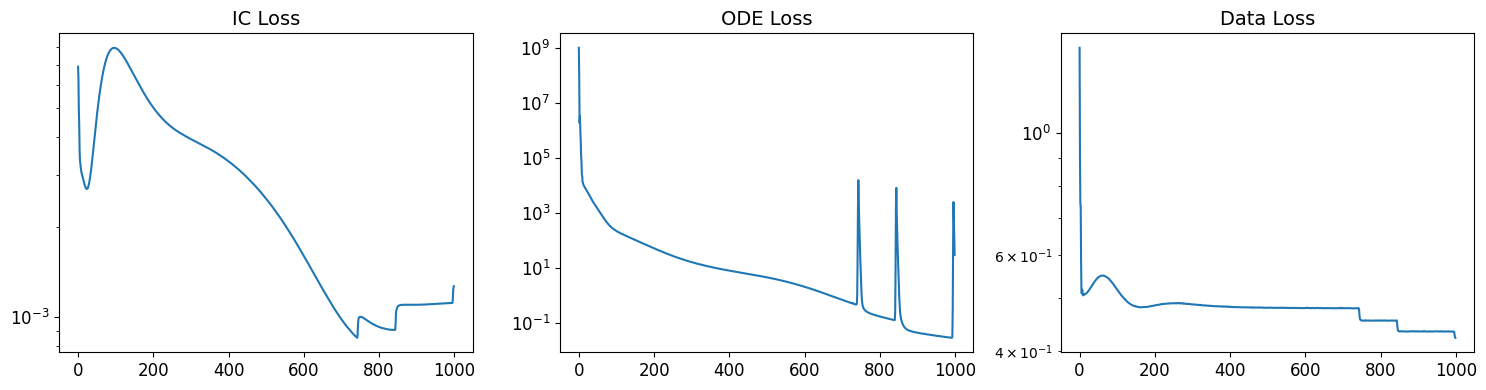

In [122]:
# History
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'])
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'])
ax[2].plot(range(n_epochs), loss_tracker.loss_history['Data_loss'])
ax[0].set_title('IC Loss', fontsize=14)
ax[1].set_title('ODE Loss', fontsize=14)
ax[2].set_title('Data Loss', fontsize=14)
for axs in ax:
    axs.set_yscale('log')
    axs.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

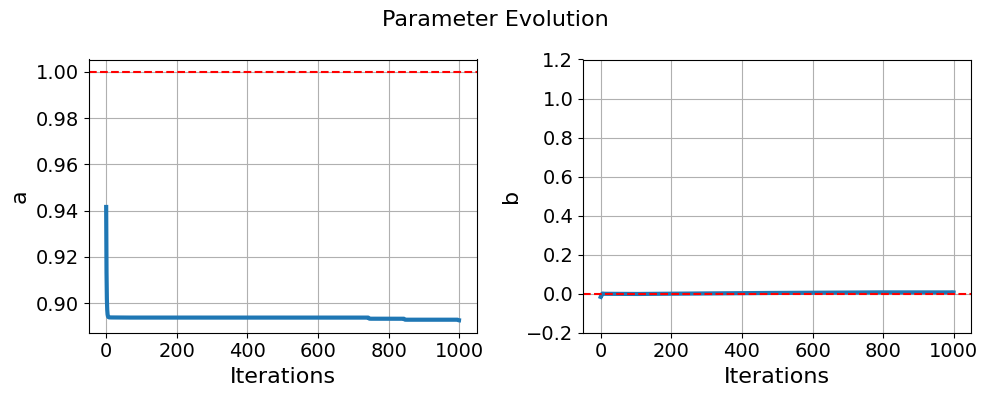

In [123]:
# Parameter history
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(range(n_epochs), a_list, lw=3)
ax[0].set_ylabel('a', fontsize=16)
ax[0].set_xlabel('Iterations', fontsize=16)
# ax[0].set_ylim((-2.2, -0.7))
ax[0].axhline(y=1, color='r', linestyle='--')

ax[1].plot(range(n_epochs), b_list, lw=3)
ax[1].set_ylabel('b', fontsize=16)
ax[1].set_xlabel('Iterations', fontsize=16)
ax[1].set_ylim((-0.2, 1.2))
ax[1].axhline(y=0, color='r', linestyle='--')

for axs in ax:
    axs.tick_params(axis='both', which='major', labelsize=14)
    axs.grid(True)
fig.suptitle('Parameter Evolution', fontsize=16)
plt.tight_layout()

#### Collect input/output of f-NN 

In [97]:
t = np.linspace(0, 200, 200000).reshape(-1, 1)
u, f = PINN.predict(t, batch_size=12800)

# Configure dataframe
df = pd.DataFrame({
    't': t.flatten(),
    'u1': u[:, 0],
    'u2': u[:, 1],
    'u3': u[:, 2],
    'u4': u[:, 3],
    'u5': u[:, 4],
    'f1': f[:, 0],
    'f2': f[:, 1],
    'f3': f[:, 2],
    'f4': f[:, 3],
    'f5': f[:, 4]
})
df.to_csv('f_NN_IO.csv', index=False)

16/16 [==============================] - 0s 607us/step


IndexError: index 2 is out of bounds for axis 1 with size 2

Text(0.5, 1.0, 'f2')

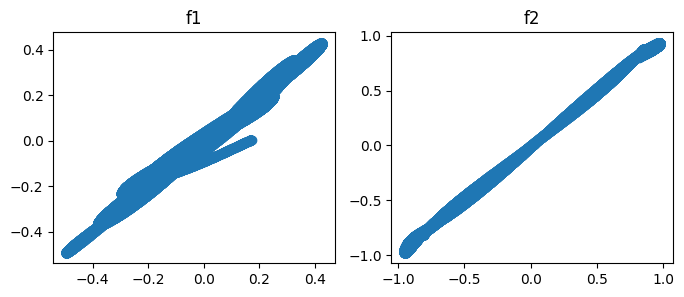

In [17]:
# Sanity check
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].scatter(np.exp(-df.t.values/10)*df.u2.values*df.u3.values, df.f1)
ax[0].set_title('f1')

ax[1].scatter(df.u1.values*df.u3.values, df.f2)
ax[1].set_title('f2')

#### Assess accuracy: u prediction

In [119]:
t = np.linspace(0, 200, 1000000).reshape(-1, 1)
pred_u, pred_f = PINN.predict(t, batch_size=12800)

79/79 [==============================] - 0s 598us/step


/tmp/ipykernel_375625/3288314124.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


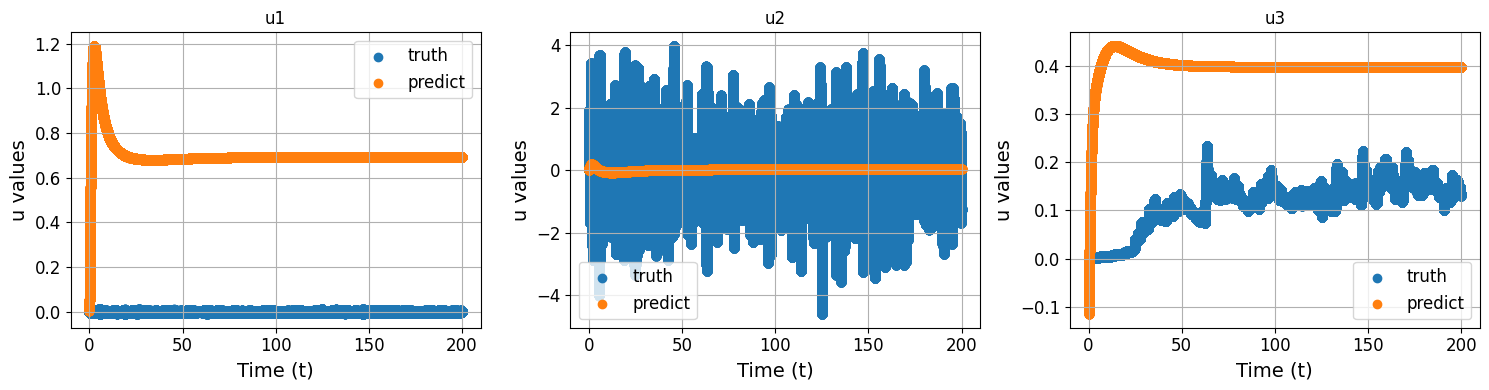

In [124]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(t.flatten(), y_test[:, 0], label='truth')
ax[0].scatter(t.flatten(), pred_u[:, 0], label='predict')
ax[0].set_title('u1')
ax[1].scatter(t.flatten(), y_test[:, 1], label='truth')
ax[1].scatter(t.flatten(), pred_u[:, 1], label='predict')
ax[1].set_title('u2')
ax[2].scatter(t.flatten(), y_test[:, 4], label='truth')
ax[2].scatter(t.flatten(), pred_u[:, 4], label='predict')
ax[2].set_title('u3')

for axs in ax:
    axs.set_xlabel('Time (t)', fontsize=14)
    axs.set_ylabel('u values', fontsize=14)
    axs.tick_params(axis='both', which='major', labelsize=12)
    axs.legend(fontsize=12, frameon=True)
    axs.grid(True)

plt.tight_layout()

#### Access accuracy: f prediction

In [13]:
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(X_test)
    u, f = PINN(X_test)

# Calculate gradients
dudt = tape.batch_jacobian(u, X_test)[:, :, 0]
du1_dt, du2_dt, du3_dt = dudt[:, :1], dudt[:, 1:2], dudt[:, 2:]

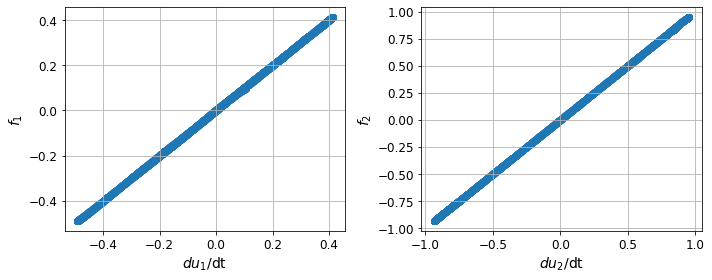

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(du1_dt.numpy().flatten(), f[:, 0].numpy())
ax[0].set_xlabel('$du_1$/dt', fontsize=14)
ax[0].set_ylabel('$f_1$', fontsize=14)
ax[1].scatter(du2_dt.numpy().flatten(), f[:, 1].numpy())
ax[1].set_xlabel('$du_2$/dt', fontsize=14)
ax[1].set_ylabel('$f_2$', fontsize=14)

for axs in ax:
    axs.tick_params(axis='both', which='major', labelsize=12)
    axs.grid(True)

plt.tight_layout()